In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


In [2]:
def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]

    cols_to_smooth = ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

areaName       date  covidOccupiedMVBeds  cumAdmissions  hospitalCases  \
0  South West 2020-04-08           120.000000           2091     925.000000   
1  South West 2020-04-09           119.000000           2212     938.000000   
2  South West 2020-04-10           121.000000           2343     954.000000   
3  South West 2020-04-11           121.000000           2470     962.500000   
4  South West 2020-04-12           122.000000           2599     977.400000   
5  South West 2020-04-13           121.666667           2712     989.000000   
6  South West 2020-04-14           121.000000           2818    1001.428571   
7  South West 2020-04-15           120.571429           2930    1023.571429   
8  South West 2020-04-16           120.142857           3048    1038.000000   
9  South West 2020-04-17           118.142857           3150    1047.571429   

   newAdmissions  new_confirmed  new_deceased  cumulative_confirmed  \
0            134     237.000000     51.000000           2893.000000   
1            121     241.500000     41.000000           3016.000000   
2            131     239.000000     48.333333           3135.000000   
3            127     222.500000     47.000000           3237.750000   
4            129     213.800000     45.000000           3335.200000   
5            113     210.333333     45.000000           3432.333333   
6            106     206.714286     43.428571           3528.142857   
7            112     203.142857     42.000000           3731.285714   
8            118     205.428571     43.142857           3936.714286   
9            102     206.285714     41.000000           4143.000000   

   cumulative_deceased  population  latitude  longitude              region  \
0           472.000000     5616381     50.96      -3.22  South West England   
1           487.500000     5616381     50.96      -3.22  South West England   
2           513.666667     5616381     50.96      -3.22  South West England   
3           537.500000     5616381     50.96      -3.22  South West England   
4           559.200000     5616381     50.96      -3.22  South West England   
5           581.166667     5616381     50.96      -3.22  South West England   
6           601.714286     5616381     50.96      -3.22  South West England   
7           643.714286     5616381     50.96      -3.22  South West England   
8           686.857143     5616381     50.96      -3.22  South West England   
9           727.857143     5616381     50.96      -3.22  South West England   

   epi_week  recovered  active_cases  
0    202015        0.0   2421.000000  
1    202015        0.0   2528.500000  
2    202015        0.0   2621.333333  
3    202015        0.0   2700.250000  
4    202016        0.0   2776.000000  
5    202016        0.0   2851.166667  
6    202016        0.0   2926.428571  
7    202016        0.0   3087.571429  
8    202016        0.0   3249.857143  
9    202016        0.0   3415.142857

In [24]:
def SEIRD_model(t, y, beta, gamma, delta, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, I, R, D

def split_and_scale_data(data, train_size, features, device):
    """Split and scale data into training and validation sets."""
    scaler = MinMaxScaler()
    scaler.fit(data[features])

    # Split data into training and validation sets
    train_data = data.iloc[:train_size].reset_index(drop=True)
    val_data = data.iloc[train_size:].reset_index(drop=True)

    scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
    scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

    t_train, I_train, R_train, D_train = prepare_tensors(scaled_train_data, device)
    t_val, I_val, R_val, D_val = prepare_tensors(scaled_val_data, device)

    tensor_data = {
        "train": (t_train, I_train, R_train, D_train),
        "val": (t_val, I_val, R_val, D_val),
    }

    return tensor_data, scaler

# Define features and data split
features = ["active_cases", "recovered", "new_deceased"]
train_size = 65  # days

In [25]:
# Split and scale data
tensor_data, scaler = split_and_scale_data(data, train_size, features, device)

t_train, I_train, R_train, D_train = tensor_data["train"]
t_val, I_val, R_val, D_val = tensor_data["val"]

t_data = torch.cat([t_train, t_val]).requires_grad_(True)
I_data = torch.cat([I_train, I_val])
R_data = torch.cat([R_train, R_val])
D_data = torch.cat([D_train, D_val])

tensor([[7.2462e-02],
        [7.6088e-02],
        [7.9219e-02],
        [8.1881e-02],
        [8.4436e-02],
        [8.6971e-02],
        [8.9509e-02],
        [9.4944e-02],
        [1.0042e-01],
        [1.0599e-01],
        [1.1157e-01],
        [1.1718e-01],
        [1.2276e-01],
        [1.2849e-01],
        [1.3463e-01],
        [1.4090e-01],
        [1.4726e-01],
        [1.5384e-01],
        [1.6073e-01],
        [1.6833e-01],
        [1.7624e-01],
        [1.7276e-01],
        [1.6806e-01],
        [1.6274e-01],
        [1.5685e-01],
        [1.4999e-01],
        [1.4169e-01],
        [1.3216e-01],
        [1.3277e-01],
        [1.3307e-01],
        [1.3281e-01],
        [1.3206e-01],
        [1.3110e-01],
        [1.3069e-01],
        [1.3026e-01],
        [1.2938e-01],
        [1.2806e-01],
        [1.2631e-01],
        [1.2436e-01],
        [1.2195e-01],
        [1.1818e-01],
        [1.1375e-01],
        [1.0888e-01],
        [1.0417e-01],
        [9.9122e-02],
        [9

In [5]:
class SEIRDNet(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, inverse=False, init_beta=None, init_gamma=None, init_delta=None, retain_seed=42, num_layers=4, hidden_neurons=20):
        super(SEIRDNet, self).__init__()
        self.retain_seed = retain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        
        if inverse:
            self._beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
            self._gamma = nn.Parameter(torch.tensor([init_gamma if init_gamma is not None else torch.rand(1)], device=device), requires_grad=True)
            self._delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        else:
            self._beta = None
            self._gamma = None
            self._delta = None
        
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None

    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * 0.09 + 0.01 if self._gamma is not None else None
    
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.09 + 0.01 if self._delta is not None else None
    
    def init_xavier(self):
        torch.manual_seed(self.retain_seed)
        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)
        self.apply(init_weights)

In [6]:
def pinn_loss(t, I_data, R_data, D_data, train_size, parameters, model_output, N, sigma=None):
    """Physics-Informed Neural Network loss function."""
    
    S = N - I_data - R_data - D_data # Susceptible population  
    beta, gamma, delta = parameters # Unpack parameters
    
    # Compute gradients
    S_pred, E_pred, I_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4] # Unpack model output
    
    # Compute first order derivatives
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Compute derivatives of the differential equations
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta, gamma, delta, sigma, N)
    
    # Compute loss on the data using training data over all time points
    loss_data = torch.mean((I_pred[:train_size] - I_data[:train_size])**2) + torch.mean((R_pred[:train_size] - R_data[:train_size])**2) + torch.mean((D_pred[:train_size] - D_data[:train_size])**2)
    
    # Compute loss on the physics using training data over all time points
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)  
    
    # initial condition loss
    loss_init = torch.mean((S_pred[0] - N)**2) + torch.mean((E_pred[0])**2) + torch.mean((I_pred[0])**2) + torch.mean((R_pred[0])**2) + torch.mean((D_pred[0])**2)
    
    # boundary condition loss
    loss_boundary = torch.mean((S_pred[t-1] - S_pred[0])**2) + torch.mean((E_pred[t-1])**2) + torch.mean((I_pred[t-1])**2) + torch.mean((R_pred[t-1])**2) + torch.mean((D_pred[t-1])**2)
    
    # regularization loss
    loss_reg = torch.mean(beta**2) + torch.mean(gamma**2) + torch.mean(delta**2)
    
    total_loss = loss_data + loss_physics + loss_init + loss_boundary + loss_reg
    
    return total_loss


In [7]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Initialize the models
model = SEIRDNet(num_layers=6, hidden_neurons=32, init_beta=0.1, init_delta=0.01, init_gamma=0.01, inverse=True).to(device)

# Initialize the optimizers
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler = StepLR(model_optimizer, step_size=2000, gamma=0.9)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Loss history
loss_history = []

# Total population
N = data["population"].values[0]

In [8]:
def train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=1000):
    """Training loop for the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        model_optimizer.zero_grad()
        
        params = [model.beta, model.gamma, model.delta]
        
        t_train, I_train, R_train, D_train = tensor_data["train"]
        t_val, I_val, R_val, D_val = tensor_data["val"]

        t_data = torch.cat([t_train, t_val]).requires_grad_(True)
        t_data = torch.cat([I_train, I_val])
        R_data = torch.cat([R_train, R_val])
        D_data = torch.cat([D_train, D_val])
        
        # Shuffle the training indices
        idx = torch.randperm(t_train.size(0))
        t_train_shuffled = t_train[idx]

        model_output = model(t_train)

        loss = pinn_loss(t_data, t_data, R_data, D_data, t_train_shuffled, params, model_output, N, sigma=1/5)
        loss.backward()
        
        model_optimizer.step()
        
        scheduler.step()

        loss_history.append(loss.item())

        if early_stopping(loss.item()):
            print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
            break

        if epoch % 500 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {loss.item():.6f}")

    print("Finished Training")
    return loss_history, model

In [9]:
# train the model
loss_history, model = train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: One of the differentiated Tensors does not require grad

In [ ]:
# def pinn_loss(t_data, I_data, R_data, D_data, tensor_data, parameters, model_output, t, N, sigma=None):
#     """Compute the PINN loss."""
#     t.requires_grad_(True)
#     S = N - I_data - R_data - D_data
#     beta, gamma, delta = parameters
#     dSdt, dEdt, dIdt, dRdt, dDdt = model_output

#     # Compute the loss
#     loss = nn.MSELoss()(dIdt, -sigma * dEdt)
#     loss += nn.MSELoss()(dRdt, gamma * I_data)
#     loss += nn.MSELoss()(dDdt, delta * I_data)
#     loss += nn.MSELoss()(dSdt, -beta * S * I_data / N)
#     loss += nn.MSELoss()(dEdt, beta * S * I_data / N - sigma * dEdt)

#     # Compute the gradients
#     grads = grad(loss, parameters, create_graph=True)

#     # Compute the second-order derivatives
#     grad_grads = grad(grads[0].sum(), parameters, create_graph=True)

#     # Compute the residual loss
#     loss += nn.MSELoss()(grads[0].sum(), torch.zeros_like(grads[0]))
#     loss += nn.MSELoss()(grad_grads[0].sum(), torch.zeros_like(grad_grads[0]))

#     return loss

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, delta, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + delta) * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def split_and_scale_data(data, train_size, features, device):
    """Split and scale data into training and validation sets."""
    scaler = MinMaxScaler()
    scaler.fit(data[features])

    # Split data into training and validation sets
    train_data = data.iloc[:train_size].reset_index(drop=True)
    val_data = data.iloc[train_size:].reset_index(drop=True)

    scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
    scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

    t_train, S_train, I_train, R_train, D_train = prepare_tensors(scaled_train_data, device)
    t_val, S_val, I_val, R_val, D_val = prepare_tensors(scaled_val_data, device)

    tensor_data = {
        "train": (t_train, S_train, I_train, R_train, D_train),
        "val": (t_val, S_val, I_val, R_val, D_val),
    }

    return tensor_data, scaler

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]
train_size = 65  # days

# Split and scale data
tensor_data, scaler = split_and_scale_data(data, train_size, features, device)

t_train, S_train, I_train, R_train, D_train = tensor_data["train"]
t_val, S_val, I_val, R_val, D_val = tensor_data["val"]    

t_data = torch.cat([t_train, t_val])
S_data = torch.cat([S_train, S_val])    
I_data = torch.cat([I_train, I_val])
R_data = torch.cat([R_train, R_val])
D_data = torch.cat([D_train, D_val])

class SEIRDNet(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, inverse=False, init_beta=None, init_gamma=None, init_delta=None, retain_seed=42, num_layers=4, hidden_neurons=20):
        super(SEIRDNet, self).__init__()
        self.retain_seed = retain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        
        if inverse:
            self._beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
            self._gamma = nn.Parameter(torch.tensor([init_gamma if init_gamma is not None else torch.rand(1)], device=device), requires_grad=True)
            self._delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        else:
            self._beta = None
            self._gamma = None
            self._delta = None
        
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None

    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * 0.09 + 0.01 if self._gamma is not None else None
    
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.09 + 0.01 if self._delta is not None else None
    
    def init_xavier(self):
        torch.manual_seed(self.retain_seed)
        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)
        self.apply(init_weights)

def pinn_loss(t, tensor_data, parameters, model_output, N, sigma=None):
    """Physics-Informed Neural Network loss function."""
    
    # S_data = N - I_data - R_data - D_data # Susceptible population  
    beta, gamma, delta = parameters # Unpack parameters
    
    # extract data  
    S_data, I_data, R_data, D_data = tensor_data    
    
    # Compute gradients
    S_pred, E_pred, I_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4] # Unpack model output
    
    # Compute first order derivatives
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Compute derivatives of the differential equations
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta, gamma, delta, sigma, N)
    
    # Compute data loss
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute loss on the physics using training data over all time points
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial condition loss
    loss_init = torch.mean((S_pred[0] - N)**2) + torch.mean((E_pred[0])**2) + torch.mean((I_pred[0])**2) + torch.mean((R_pred[0])**2) + torch.mean((D_pred[0])**2)
    
    # # boundary condition loss
    loss_boundary = torch.mean((S_pred[t-1] - S_pred[0])**2) + torch.mean((E_pred[t-1])**2) + torch.mean((I_pred[t-1])**2) + torch.mean((R_pred[t-1])**2) + torch.mean((D_pred[t-1])**2)
    
    # regularization loss
    loss_reg = torch.mean(beta**2) + torch.mean(gamma**2) + torch.mean(delta**2)
    
    total_loss = loss_data + loss_physics + loss_init + loss_reg + loss_boundary
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Initialize the models
model = SEIRDNet(num_layers=6, hidden_neurons=32, init_beta=0.1, init_delta=0.01, init_gamma=0.01, inverse=True).to(device)

# Initialize the optimizers
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

# Learning rate scheduler
scheduler = StepLR(model_optimizer, step_size=2000, gamma=0.9)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Loss history
loss_history = []

# Total population
N = data["population"].values[0]

def train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=1000):
    """Training loop for the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        model_optimizer.zero_grad()
        
        params = [model.beta, model.gamma, model.delta]
        
        t_train, S_train, I_train, R_train, D_train = tensor_data["train"]
        t_val, S_val, I_val, R_val, D_val = tensor_data["val"]

        t_data = torch.cat([t_train, t_val]).requires_grad_(True)
        S_data = torch.cat([S_train, S_val])
        I_data = torch.cat([I_train, I_val])
        R_data = torch.cat([R_train, R_val])
        D_data = torch.cat([D_train, D_val])
        
        # Shuffle the training indices
        idx = torch.randperm(t_train.size(0))
        t_train_shuffled = t_train[idx]

        model_output = model(t_train)

        loss = pinn_loss(t_data, [S_data, I_data, R_data, D_data], params, model_output, N, sigma=1/5)
        loss.backward()
        
        model_optimizer.step()
        
        scheduler.step()

        loss_history.append(loss.item())

        if early_stopping(loss.item()):
            print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
            break

        if epoch % 500 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {loss.item():.6f}")
            
        return loss_history, model 
    
# train the model
loss_history, model = train_model(tensor_data, model, model_optimizer, scheduler, early_stopping, num_epochs=5000)


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

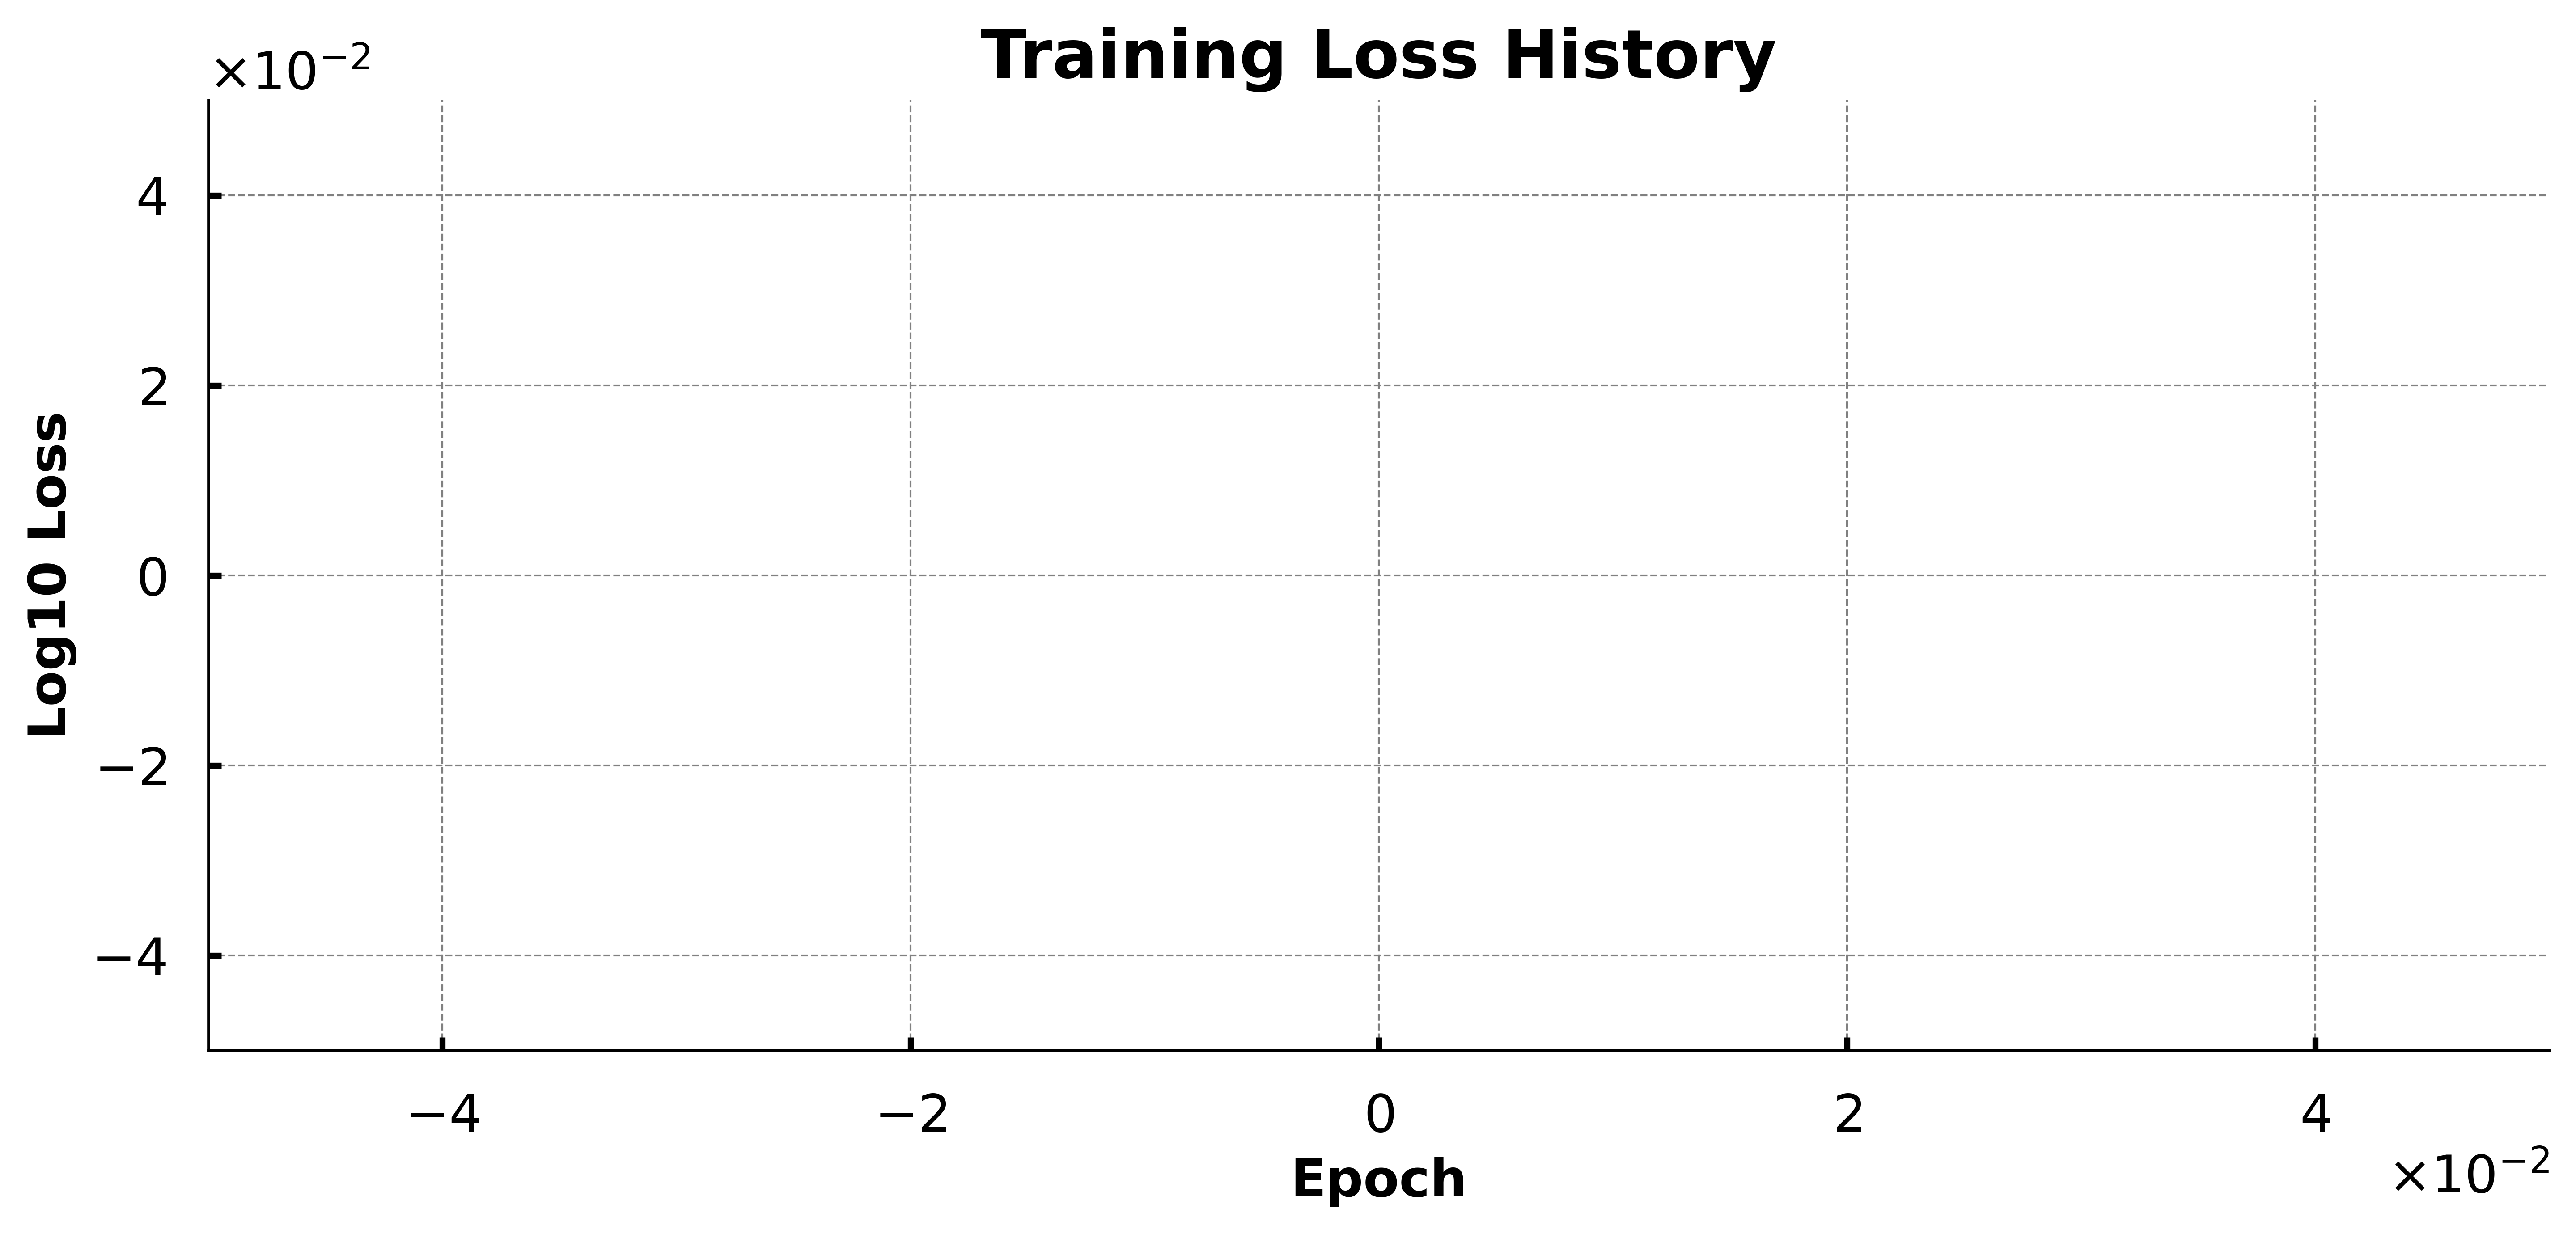

In [45]:
# loss history 
plt.plot(np.log10(loss_history))
plt.xlabel("Epoch")
plt.ylabel("Log10 Loss")
plt.title("Training Loss History")
plt.show()  


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 5/5000 [00:00<01:45, 47.53it/s]

Epoch [0/5000], Loss: 1.051304


  1%|          | 30/5000 [00:00<01:50, 44.83it/s]

 10%|█         | 510/5000 [00:08<01:39, 45.17it/s] 

Epoch [500/5000], Loss: 0.297305


 20%|██        | 1010/5000 [00:19<01:28, 45.29it/s]

Epoch [1000/5000], Loss: 0.297192


 30%|███       | 1508/5000 [00:30<01:17, 45.05it/s]

Epoch [1500/5000], Loss: 0.297123


 40%|████      | 2010/5000 [00:41<01:01, 48.36it/s]

Epoch [2000/5000], Loss: 0.297083


 50%|█████     | 2507/5000 [00:52<00:55, 44.78it/s]

Epoch [2500/5000], Loss: 0.297060


 60%|██████    | 3007/5000 [01:03<00:44, 44.70it/s]

Epoch [3000/5000], Loss: 0.297045


 70%|███████   | 3521/5000 [01:08<00:12, 117.59it/s]

Epoch [3500/5000], Loss: 0.297035


 80%|████████  | 4013/5000 [01:12<00:08, 117.14it/s]

Epoch [4000/5000], Loss: 0.297028


 90%|█████████ | 4515/5000 [01:20<00:04, 110.02it/s]

Epoch [4500/5000], Loss: 0.297024


100%|██████████| 5000/5000 [01:25<00:00, 58.64it/s] 


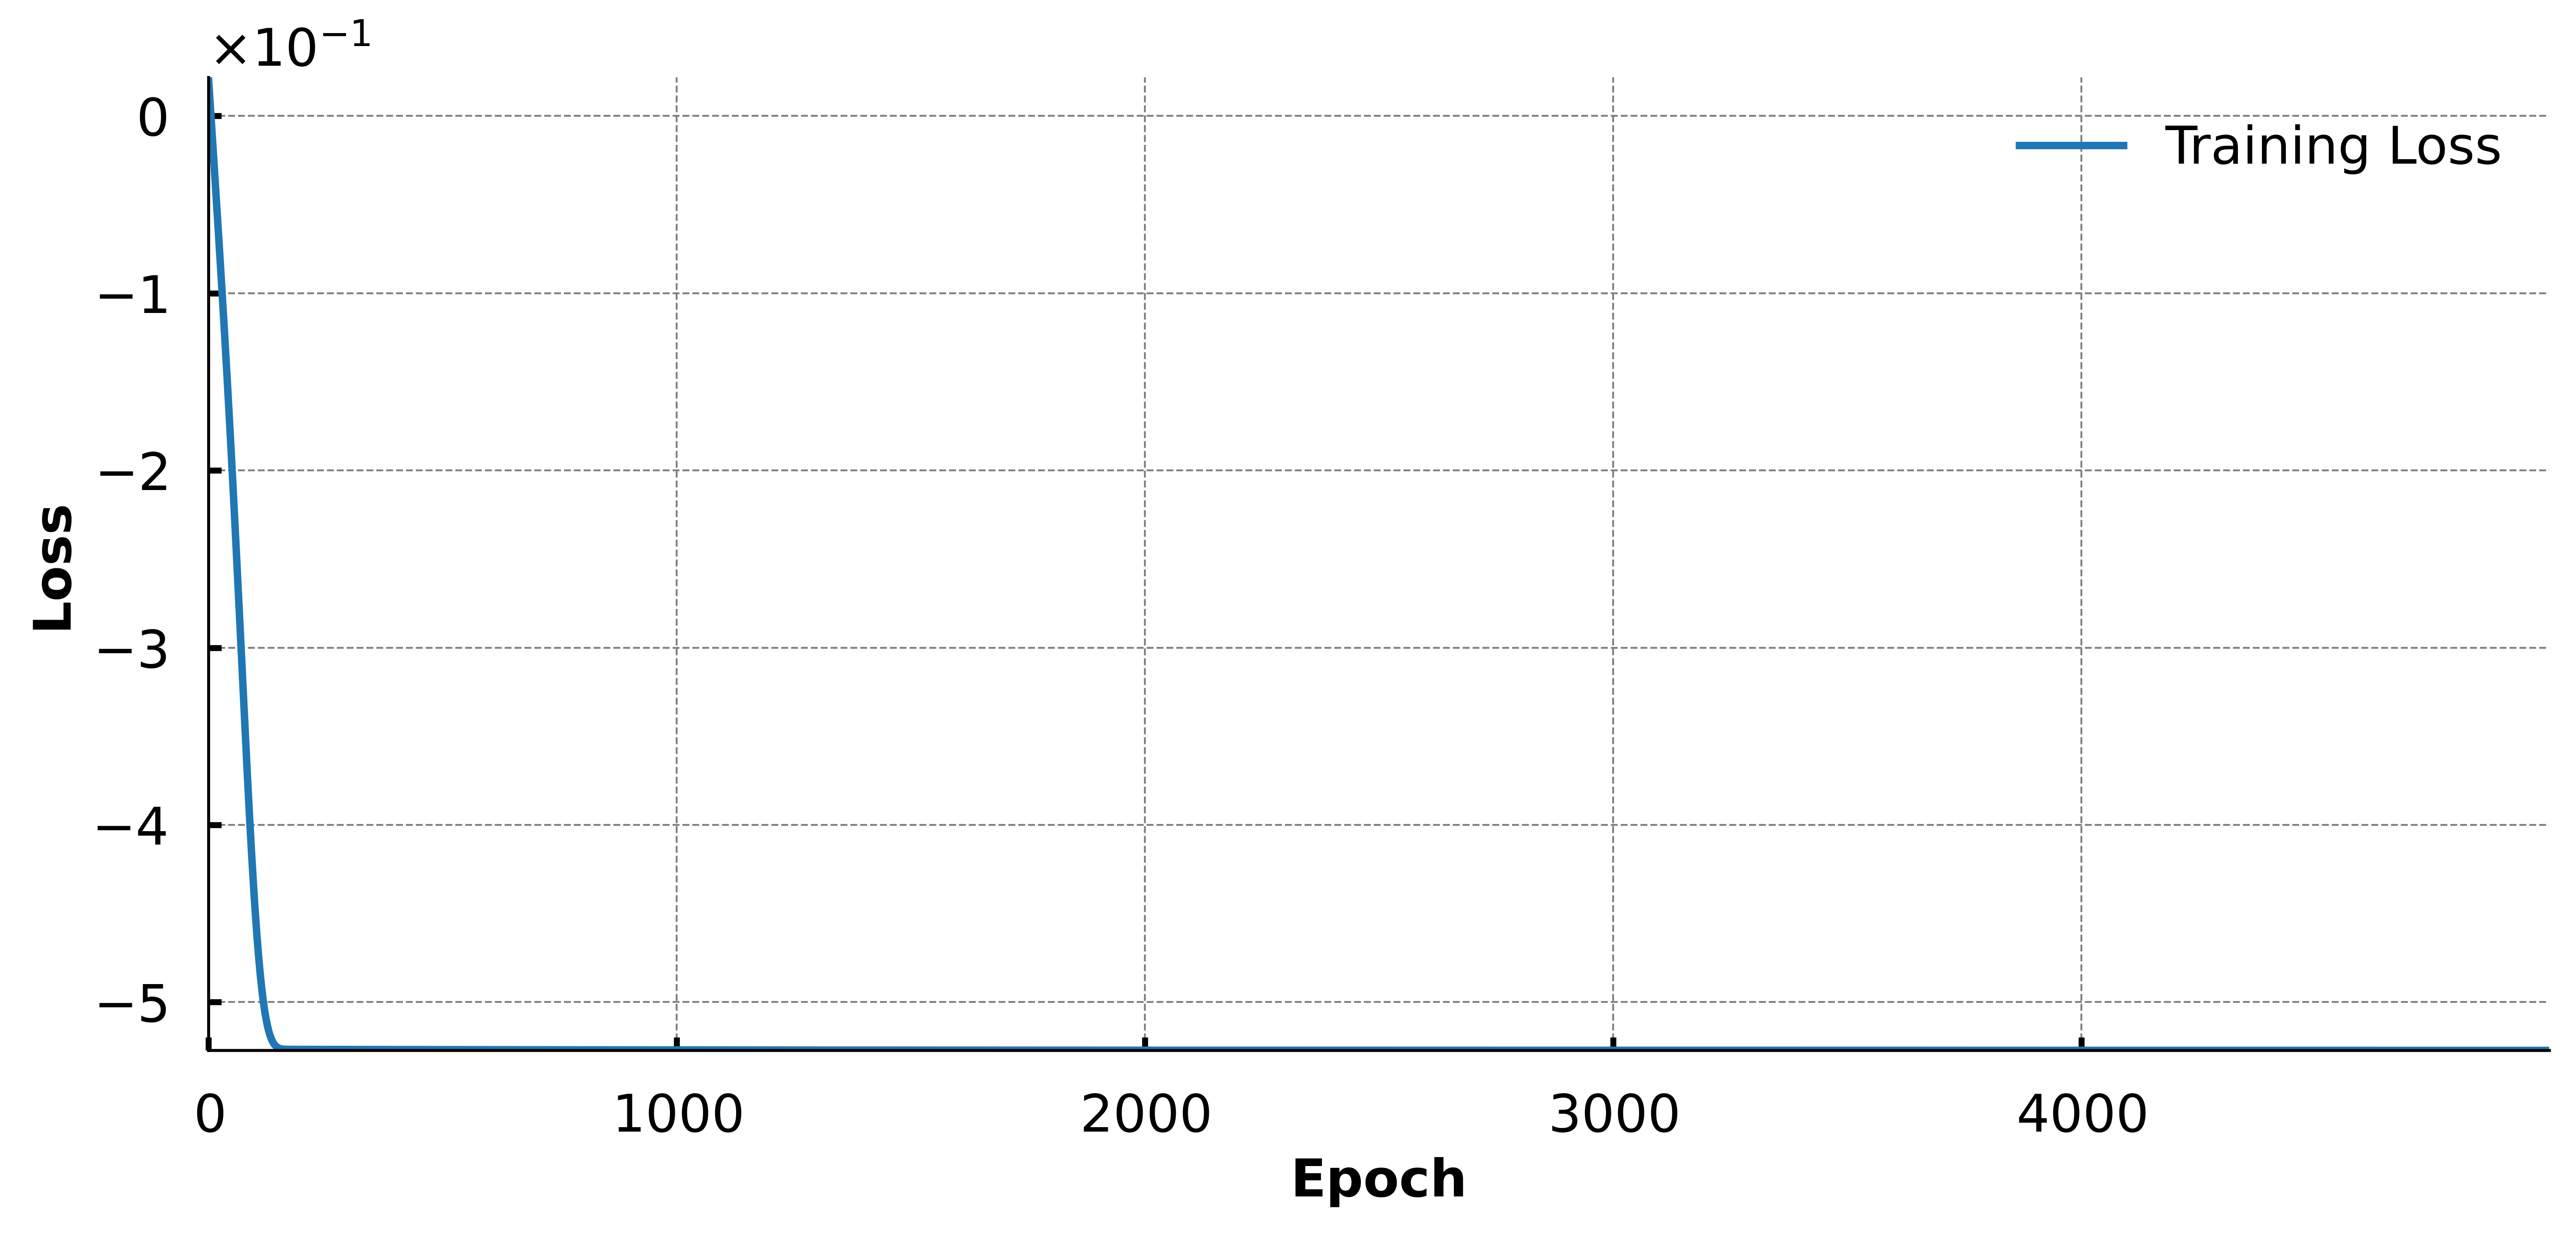

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def split_and_scale_data(data, train_size, features, device):
    """Split and scale data into training and validation sets."""
    scaler = MinMaxScaler()
    scaler.fit(data[features])

    # Split data into training and validation sets
    train_data = data.iloc[:train_size].reset_index(drop=True)
    val_data = data.iloc[train_size:].reset_index(drop=True)

    scaled_train_data = pd.DataFrame(scaler.transform(train_data[features]), columns=features)
    scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)

    t_train, S_train, I_train, R_train, D_train = prepare_tensors(scaled_train_data, device)
    t_val, S_val, I_val, R_val, D_val = prepare_tensors(scaled_val_data, device)

    tensor_data = {
        "train": (t_train, S_train, I_train, R_train, D_train),
        "val": (t_val, S_val, I_val, R_val, D_val),
    }

    return tensor_data, scaler

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]
train_size = 65  # days

# Split and scale data
tensor_data, scaler = split_and_scale_data(data, train_size, features, device)

t_train, S_train, I_train, R_train, D_train = tensor_data["train"]
t_val, S_val, I_val, R_val, D_val = tensor_data["val"]    

t_data = torch.cat([t_train, t_val])
S_data = torch.cat([S_train, S_val])
I_data = torch.cat([I_train, I_val])
R_data = torch.cat([R_train, R_val])
D_data = torch.cat([D_train, D_val])

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return torch.tanh(self.alpha * x) + self.epsilon

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), ModifiedTanh(alpha, epsilon)])
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

def pinn_loss(t, data, state_nn, param_nn, N, sigma):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    params_pred = param_nn(t)
    beta_pred, gamma_pred, mu_pred = params_pred[:, 0], params_pred[:, 1], params_pred[:, 2]
    
    # SEIRD model residuals
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, N)
    
    # Compute E dynamically
    E_calculated = I_t + (gamma_pred + mu_pred) * I_pred - sigma * E_pred
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # Total loss
    total_loss = loss_data + loss_physics
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 5000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = t_data
    
    data_tensors = (S_data, I_data, R_data, D_data)
    
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label="Training Loss")    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 11/50000 [00:00<07:44, 107.67it/s]

Epoch [1/50000], Loss: 2.744179


  1%|          | 523/50000 [00:05<07:52, 104.61it/s]

Epoch [501/50000], Loss: 0.305455


  2%|▏         | 1018/50000 [00:15<07:48, 104.49it/s]

Epoch [1001/50000], Loss: 0.303796


  3%|▎         | 1505/50000 [00:25<18:42, 43.20it/s] 

Epoch [1501/50000], Loss: 0.302983


  4%|▍         | 2005/50000 [00:37<18:37, 42.94it/s]

Epoch [2001/50000], Loss: 0.302532


  5%|▌         | 2505/50000 [00:48<18:18, 43.23it/s]

Epoch [2501/50000], Loss: 0.302284


  6%|▌         | 3005/50000 [01:00<18:09, 43.13it/s]

Epoch [3001/50000], Loss: 0.302143


  7%|▋         | 3505/50000 [01:11<17:50, 43.43it/s]

Epoch [3501/50000], Loss: 0.302049


  8%|▊         | 4005/50000 [01:23<17:43, 43.26it/s]

Epoch [4001/50000], Loss: 0.301969


  9%|▉         | 4505/50000 [01:34<17:31, 43.26it/s]

Epoch [4501/50000], Loss: 0.301894


 10%|█         | 5005/50000 [01:46<17:29, 42.87it/s]

Epoch [5001/50000], Loss: 0.301820


 11%|█         | 5505/50000 [01:58<17:16, 42.94it/s]

Epoch [5501/50000], Loss: 0.301742


 12%|█▏        | 6005/50000 [02:09<16:58, 43.20it/s]

Epoch [6001/50000], Loss: 0.301654


 13%|█▎        | 6505/50000 [02:21<16:52, 42.94it/s]

Epoch [6501/50000], Loss: 0.301524


 14%|█▍        | 7005/50000 [02:32<16:34, 43.22it/s]

Epoch [7001/50000], Loss: 0.301149


 15%|█▌        | 7520/50000 [02:39<06:15, 113.15it/s]

Epoch [7501/50000], Loss: 0.300096


 16%|█▌        | 8012/50000 [02:43<06:11, 113.03it/s]

Epoch [8001/50000], Loss: 0.299812


 17%|█▋        | 8516/50000 [02:48<06:07, 113.01it/s]

Epoch [8501/50000], Loss: 0.299783


 18%|█▊        | 9020/50000 [02:52<06:04, 112.34it/s]

Epoch [9001/50000], Loss: 0.299777


 19%|█▉        | 9500/50000 [02:57<08:36, 78.41it/s] 

Epoch [9501/50000], Loss: 0.299774


 20%|██        | 10008/50000 [03:08<15:24, 43.24it/s]

Epoch [10001/50000], Loss: 0.299773


 21%|██        | 10508/50000 [03:20<15:11, 43.34it/s]

Epoch [10501/50000], Loss: 0.299773


 22%|██▏       | 11023/50000 [03:26<05:45, 112.89it/s]

Epoch [11001/50000], Loss: 0.299772


 23%|██▎       | 11515/50000 [03:30<05:41, 112.65it/s]

Epoch [11501/50000], Loss: 0.299772


 24%|██▍       | 12019/50000 [03:34<05:36, 112.79it/s]

Epoch [12001/50000], Loss: 0.299772


 25%|██▌       | 12516/50000 [03:41<05:32, 112.65it/s]

Epoch [12501/50000], Loss: 0.299772


 26%|██▌       | 13007/50000 [03:47<13:37, 45.24it/s] 

Epoch [13001/50000], Loss: 0.299772


 27%|██▋       | 13507/50000 [03:58<14:06, 43.09it/s]

Epoch [13501/50000], Loss: 0.299772


 28%|██▊       | 14008/50000 [04:10<13:49, 43.41it/s]

Epoch [14001/50000], Loss: 0.299772


 29%|██▉       | 14508/50000 [04:21<13:43, 43.09it/s]

Epoch [14501/50000], Loss: 0.299772


 30%|███       | 15008/50000 [04:30<12:46, 45.67it/s] 

Epoch [15001/50000], Loss: 0.299772


 31%|███       | 15508/50000 [04:42<13:22, 42.98it/s]

Epoch [15501/50000], Loss: 0.299772


 32%|███▏      | 16005/50000 [04:53<12:50, 44.11it/s]

Epoch [16001/50000], Loss: 0.299772


 33%|███▎      | 16505/50000 [05:05<12:54, 43.24it/s]

Epoch [16501/50000], Loss: 0.299772


 34%|███▍      | 17005/50000 [05:16<12:41, 43.35it/s]

Epoch [17001/50000], Loss: 0.299772


 35%|███▌      | 17505/50000 [05:28<12:30, 43.31it/s]

Epoch [17501/50000], Loss: 0.299772


 36%|███▌      | 18012/50000 [05:39<10:30, 50.76it/s]

Epoch [18001/50000], Loss: 0.299772


 37%|███▋      | 18505/50000 [05:51<12:13, 42.92it/s]

Epoch [18501/50000], Loss: 0.299773


 38%|███▊      | 19008/50000 [06:02<11:14, 45.93it/s]

Epoch [19001/50000], Loss: 0.299772


 39%|███▉      | 19523/50000 [06:12<04:36, 110.40it/s]

Epoch [19501/50000], Loss: 0.299772


 40%|████      | 20017/50000 [06:17<04:26, 112.66it/s]

Epoch [20001/50000], Loss: 0.299772


 41%|████      | 20518/50000 [06:21<04:35, 106.95it/s]

Epoch [20501/50000], Loss: 0.299773


 42%|████▏     | 21021/50000 [06:26<04:17, 112.62it/s]

Epoch [21001/50000], Loss: 0.299772


 43%|████▎     | 21521/50000 [06:30<04:17, 110.50it/s]

Epoch [21501/50000], Loss: 0.299772


 44%|████▍     | 22018/50000 [06:35<04:34, 101.91it/s]

Epoch [22001/50000], Loss: 0.299773


 45%|████▌     | 22512/50000 [06:42<06:50, 66.94it/s] 

Epoch [22501/50000], Loss: 0.299772


 46%|████▌     | 23012/50000 [06:46<04:13, 106.27it/s]

Epoch [23001/50000], Loss: 0.299772


 47%|████▋     | 23512/50000 [06:51<03:55, 112.41it/s]

Epoch [23501/50000], Loss: 0.299772


 48%|████▊     | 24013/50000 [06:55<03:58, 109.05it/s]

Epoch [24001/50000], Loss: 0.299772


 49%|████▉     | 24508/50000 [07:01<09:37, 44.18it/s] 

Epoch [24501/50000], Loss: 0.299772


 50%|█████     | 25009/50000 [07:12<09:28, 43.94it/s]

Epoch [25001/50000], Loss: 0.299772


 51%|█████     | 25509/50000 [07:24<09:22, 43.53it/s]

Epoch [25501/50000], Loss: 0.299772


 52%|█████▏    | 26009/50000 [07:35<09:06, 43.87it/s]

Epoch [26001/50000], Loss: 0.299772


 53%|█████▎    | 26508/50000 [07:47<09:01, 43.38it/s]

Epoch [26501/50000], Loss: 0.299772


 54%|█████▍    | 27008/50000 [07:58<08:56, 42.89it/s]

Epoch [27001/50000], Loss: 0.299772


 55%|█████▌    | 27506/50000 [08:10<08:44, 42.85it/s]

Epoch [27501/50000], Loss: 0.299772


 56%|█████▌    | 28007/50000 [08:21<08:32, 42.90it/s]

Epoch [28001/50000], Loss: 0.299773


 57%|█████▋    | 28507/50000 [08:33<08:18, 43.11it/s]

Epoch [28501/50000], Loss: 0.299772


 58%|█████▊    | 29007/50000 [08:44<08:09, 42.92it/s]

Epoch [29001/50000], Loss: 0.299772


 59%|█████▉    | 29508/50000 [08:55<07:59, 42.74it/s]

Epoch [29501/50000], Loss: 0.299773


 60%|██████    | 30006/50000 [09:07<07:44, 43.03it/s]

Epoch [30001/50000], Loss: 0.299772


 61%|██████    | 30508/50000 [09:18<06:31, 49.76it/s]

Epoch [30501/50000], Loss: 0.299772


 62%|██████▏   | 31008/50000 [09:29<07:14, 43.74it/s]

Epoch [31001/50000], Loss: 0.299772


 63%|██████▎   | 31508/50000 [09:41<07:10, 42.93it/s]

Epoch [31501/50000], Loss: 0.299772


 64%|██████▍   | 32005/50000 [09:51<05:33, 53.93it/s]

Epoch [32001/50000], Loss: 0.299772


 65%|██████▌   | 32512/50000 [09:57<02:34, 112.88it/s]

Epoch [32501/50000], Loss: 0.299772


 66%|██████▌   | 33005/50000 [10:05<06:32, 43.30it/s] 

Epoch [33001/50000], Loss: 0.299772


 67%|██████▋   | 33506/50000 [10:16<06:22, 43.14it/s]

Epoch [33501/50000], Loss: 0.299772


 68%|██████▊   | 34006/50000 [10:28<06:06, 43.67it/s]

Epoch [34001/50000], Loss: 0.299772


 69%|██████▉   | 34506/50000 [10:39<05:57, 43.38it/s]

Epoch [34501/50000], Loss: 0.299772


 70%|███████   | 35006/50000 [10:51<05:44, 43.54it/s]

Epoch [35001/50000], Loss: 0.299772


 71%|███████   | 35507/50000 [11:02<05:36, 43.02it/s]

Epoch [35501/50000], Loss: 0.299772


 72%|███████▏  | 36005/50000 [11:13<05:17, 44.10it/s]

Epoch [36001/50000], Loss: 0.299772


 73%|███████▎  | 36509/50000 [11:25<05:09, 43.55it/s]

Epoch [36501/50000], Loss: 0.299772


 74%|███████▍  | 37005/50000 [11:36<05:01, 43.09it/s]

Epoch [37001/50000], Loss: 0.299772


 75%|███████▌  | 37507/50000 [11:48<04:44, 43.94it/s]

Epoch [37501/50000], Loss: 0.299772


 76%|███████▌  | 38007/50000 [11:59<04:40, 42.82it/s]

Epoch [38001/50000], Loss: 0.299772


 77%|███████▋  | 38507/50000 [12:11<04:24, 43.48it/s]

Epoch [38501/50000], Loss: 0.299772


 78%|███████▊  | 39007/50000 [12:22<04:02, 45.38it/s]

Epoch [39001/50000], Loss: 0.299773


 79%|███████▉  | 39507/50000 [12:34<04:03, 43.13it/s]

Epoch [39501/50000], Loss: 0.299772


 80%|████████  | 40007/50000 [12:45<03:51, 43.21it/s]

Epoch [40001/50000], Loss: 0.299772


 81%|████████  | 40508/50000 [12:57<03:33, 44.44it/s]

Epoch [40501/50000], Loss: 0.299772


 82%|████████▏ | 41005/50000 [13:08<03:27, 43.36it/s]

Epoch [41001/50000], Loss: 0.299772


 83%|████████▎ | 41506/50000 [13:20<03:16, 43.17it/s]

Epoch [41501/50000], Loss: 0.299772


 84%|████████▍ | 42006/50000 [13:31<03:02, 43.77it/s]

Epoch [42001/50000], Loss: 0.299772


 85%|████████▌ | 42506/50000 [13:43<02:53, 43.13it/s]

Epoch [42501/50000], Loss: 0.299773


 86%|████████▌ | 43009/50000 [13:54<02:32, 45.75it/s]

Epoch [43001/50000], Loss: 0.299773


 87%|████████▋ | 43509/50000 [14:05<02:29, 43.46it/s]

Epoch [43501/50000], Loss: 0.299772


 88%|████████▊ | 44009/50000 [14:17<02:17, 43.42it/s]

Epoch [44001/50000], Loss: 0.299772


 89%|████████▉ | 44509/50000 [14:28<02:03, 44.33it/s]

Epoch [44501/50000], Loss: 0.299772


 90%|█████████ | 45007/50000 [14:40<01:56, 42.82it/s]

Epoch [45001/50000], Loss: 0.299772


 91%|█████████ | 45509/50000 [14:51<01:43, 43.44it/s]

Epoch [45501/50000], Loss: 0.299772


 92%|█████████▏| 46006/50000 [15:03<01:27, 45.44it/s]

Epoch [46001/50000], Loss: 0.299772


 93%|█████████▎| 46506/50000 [15:14<01:21, 43.06it/s]

Epoch [46501/50000], Loss: 0.299773


 94%|█████████▍| 47006/50000 [15:26<01:09, 43.06it/s]

Epoch [47001/50000], Loss: 0.299772


 95%|█████████▌| 47506/50000 [15:37<00:57, 43.27it/s]

Epoch [47501/50000], Loss: 0.299772


 96%|█████████▌| 48005/50000 [15:49<00:45, 43.50it/s]

Epoch [48001/50000], Loss: 0.299773


 97%|█████████▋| 48505/50000 [16:00<00:34, 43.09it/s]

Epoch [48501/50000], Loss: 0.299772


 98%|█████████▊| 49005/50000 [16:12<00:23, 43.00it/s]

Epoch [49001/50000], Loss: 0.299773


 99%|█████████▉| 49505/50000 [16:23<00:11, 42.55it/s]

Epoch [49501/50000], Loss: 0.299772


100%|██████████| 50000/50000 [16:35<00:00, 50.25it/s]


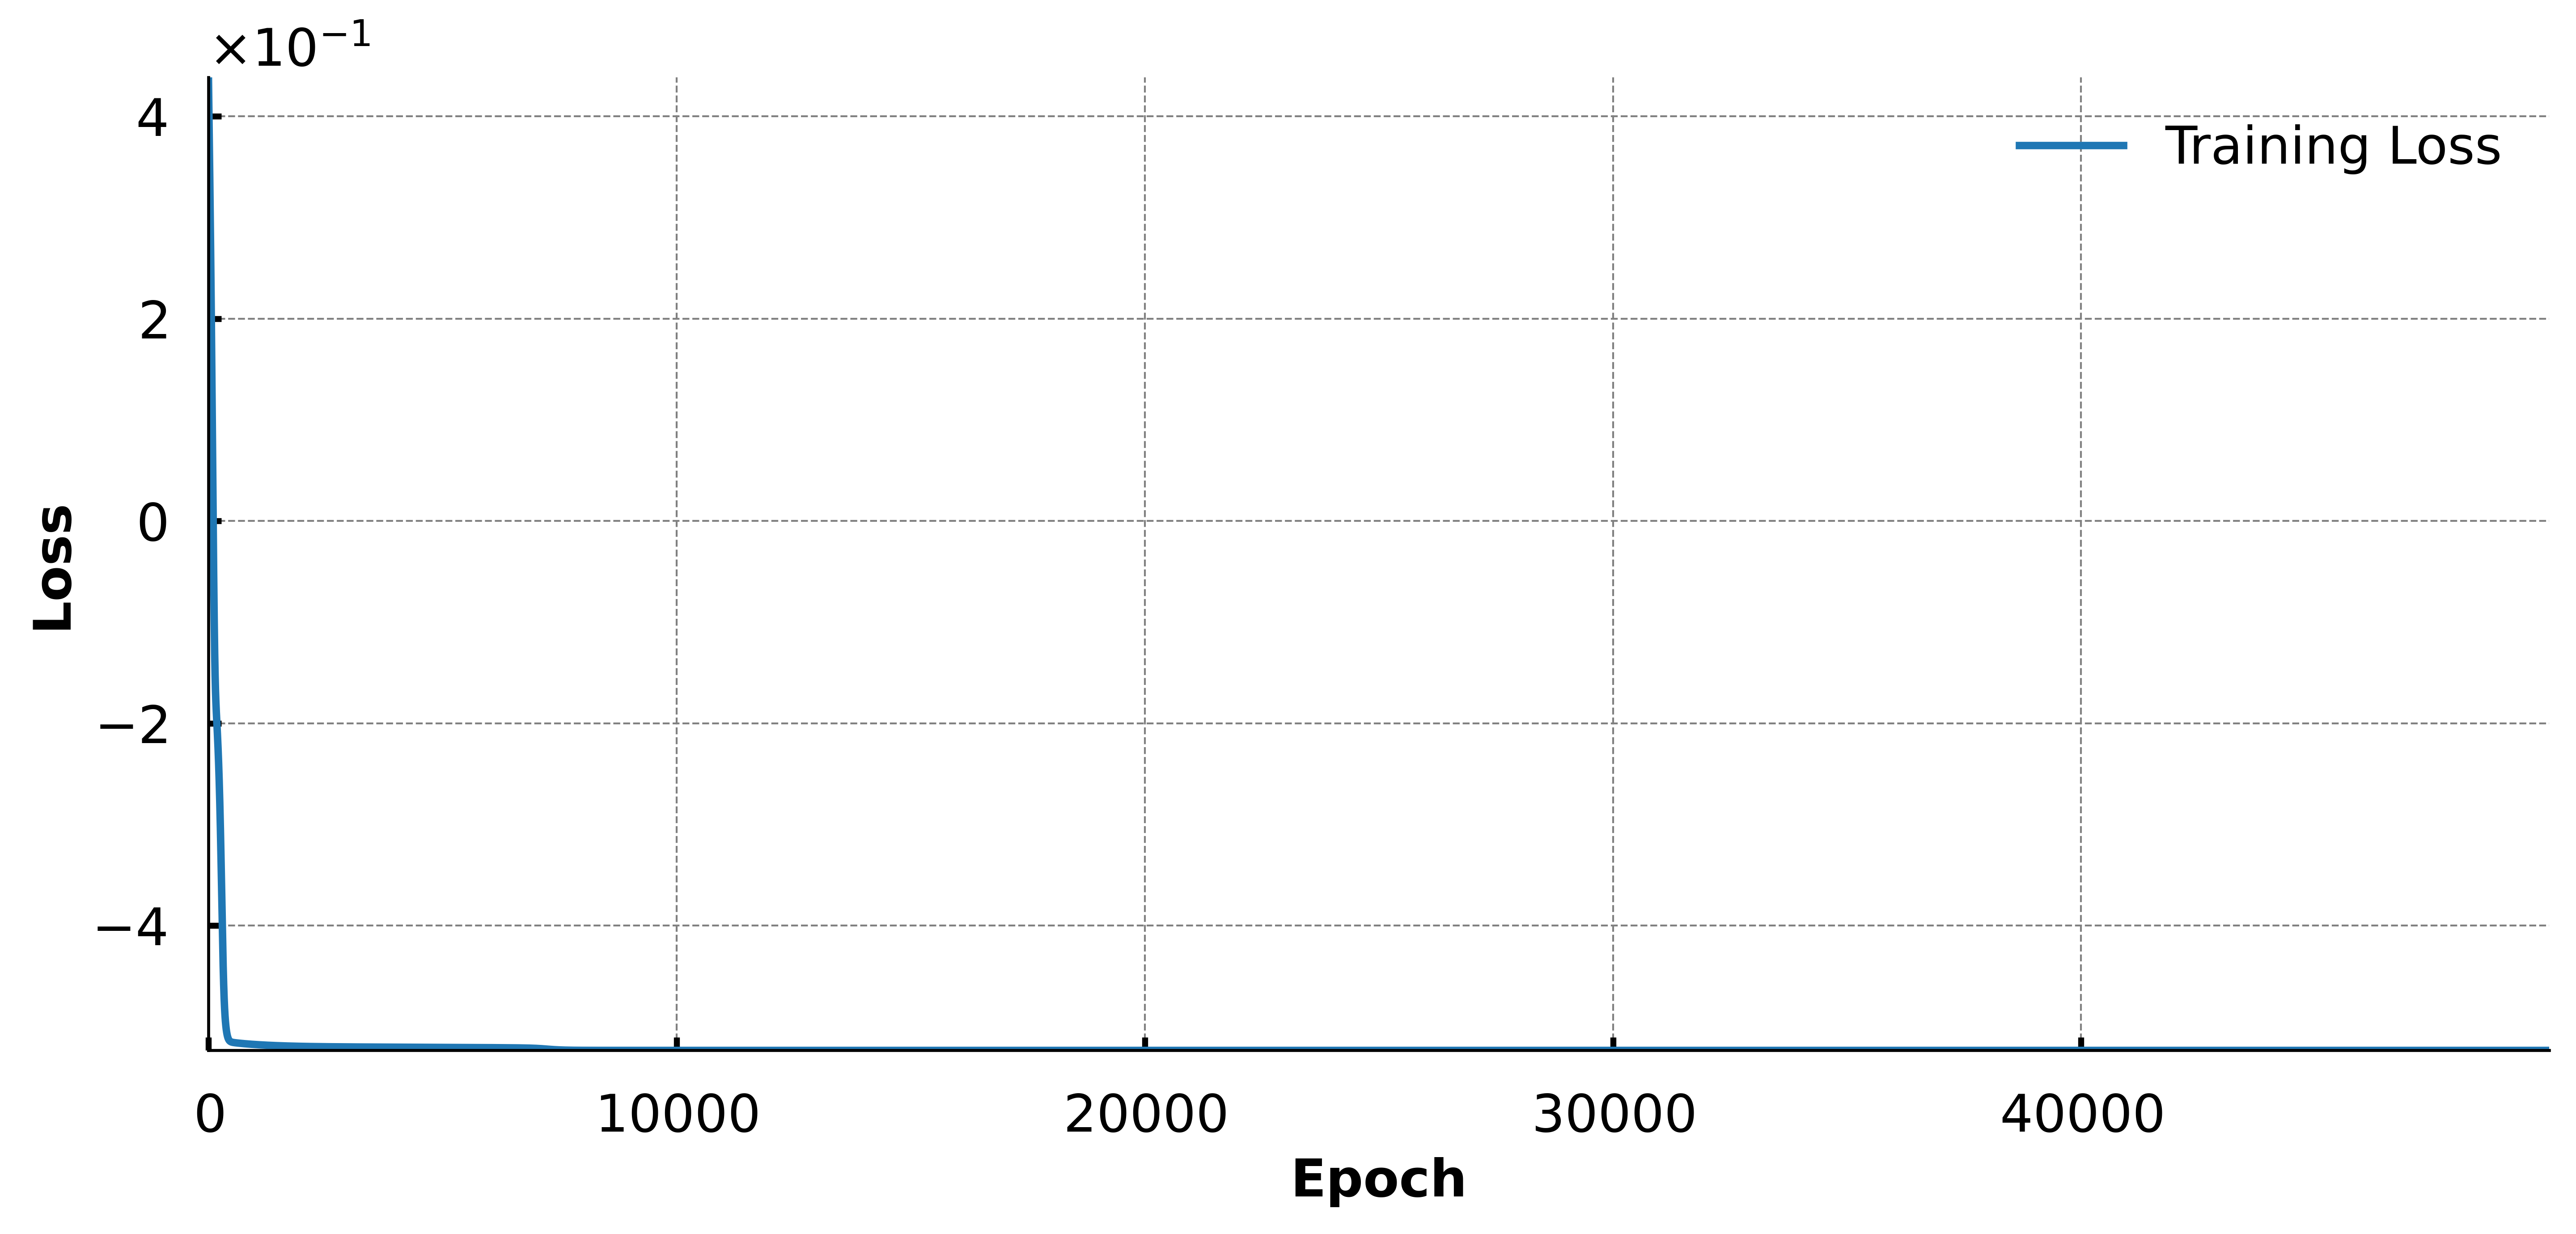

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return torch.tanh(self.alpha * x) + self.epsilon

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), ModifiedTanh(alpha, epsilon)])
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

def pinn_loss(t, data, state_nn, param_nn, N, sigma):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    params_pred = param_nn(t)
    beta_pred, gamma_pred, mu_pred = params_pred[:, 0], params_pred[:, 1], params_pred[:, 2]
    
    # SEIRD model residuals
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, N)
    
    # # Compute E dynamically
    # E_calculated = (I_t + (gamma_pred + mu_pred) * I_pred - sigma * E_pred) / sigma
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial conditions loss
    loss_init = torch.mean((S_pred[0] - S_data[0])**2) + torch.mean((I_pred[0] - I_data[0])**2) + torch.mean((R_pred[0] - R_data[0])**2) + torch.mean((D_pred[0] - D_data[0])**2)   
    
    # Total loss
    total_loss = loss_data + loss_physics + loss_init
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = t_data
    
    data_tensors = (S_data, I_data, R_data, D_data)
    
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

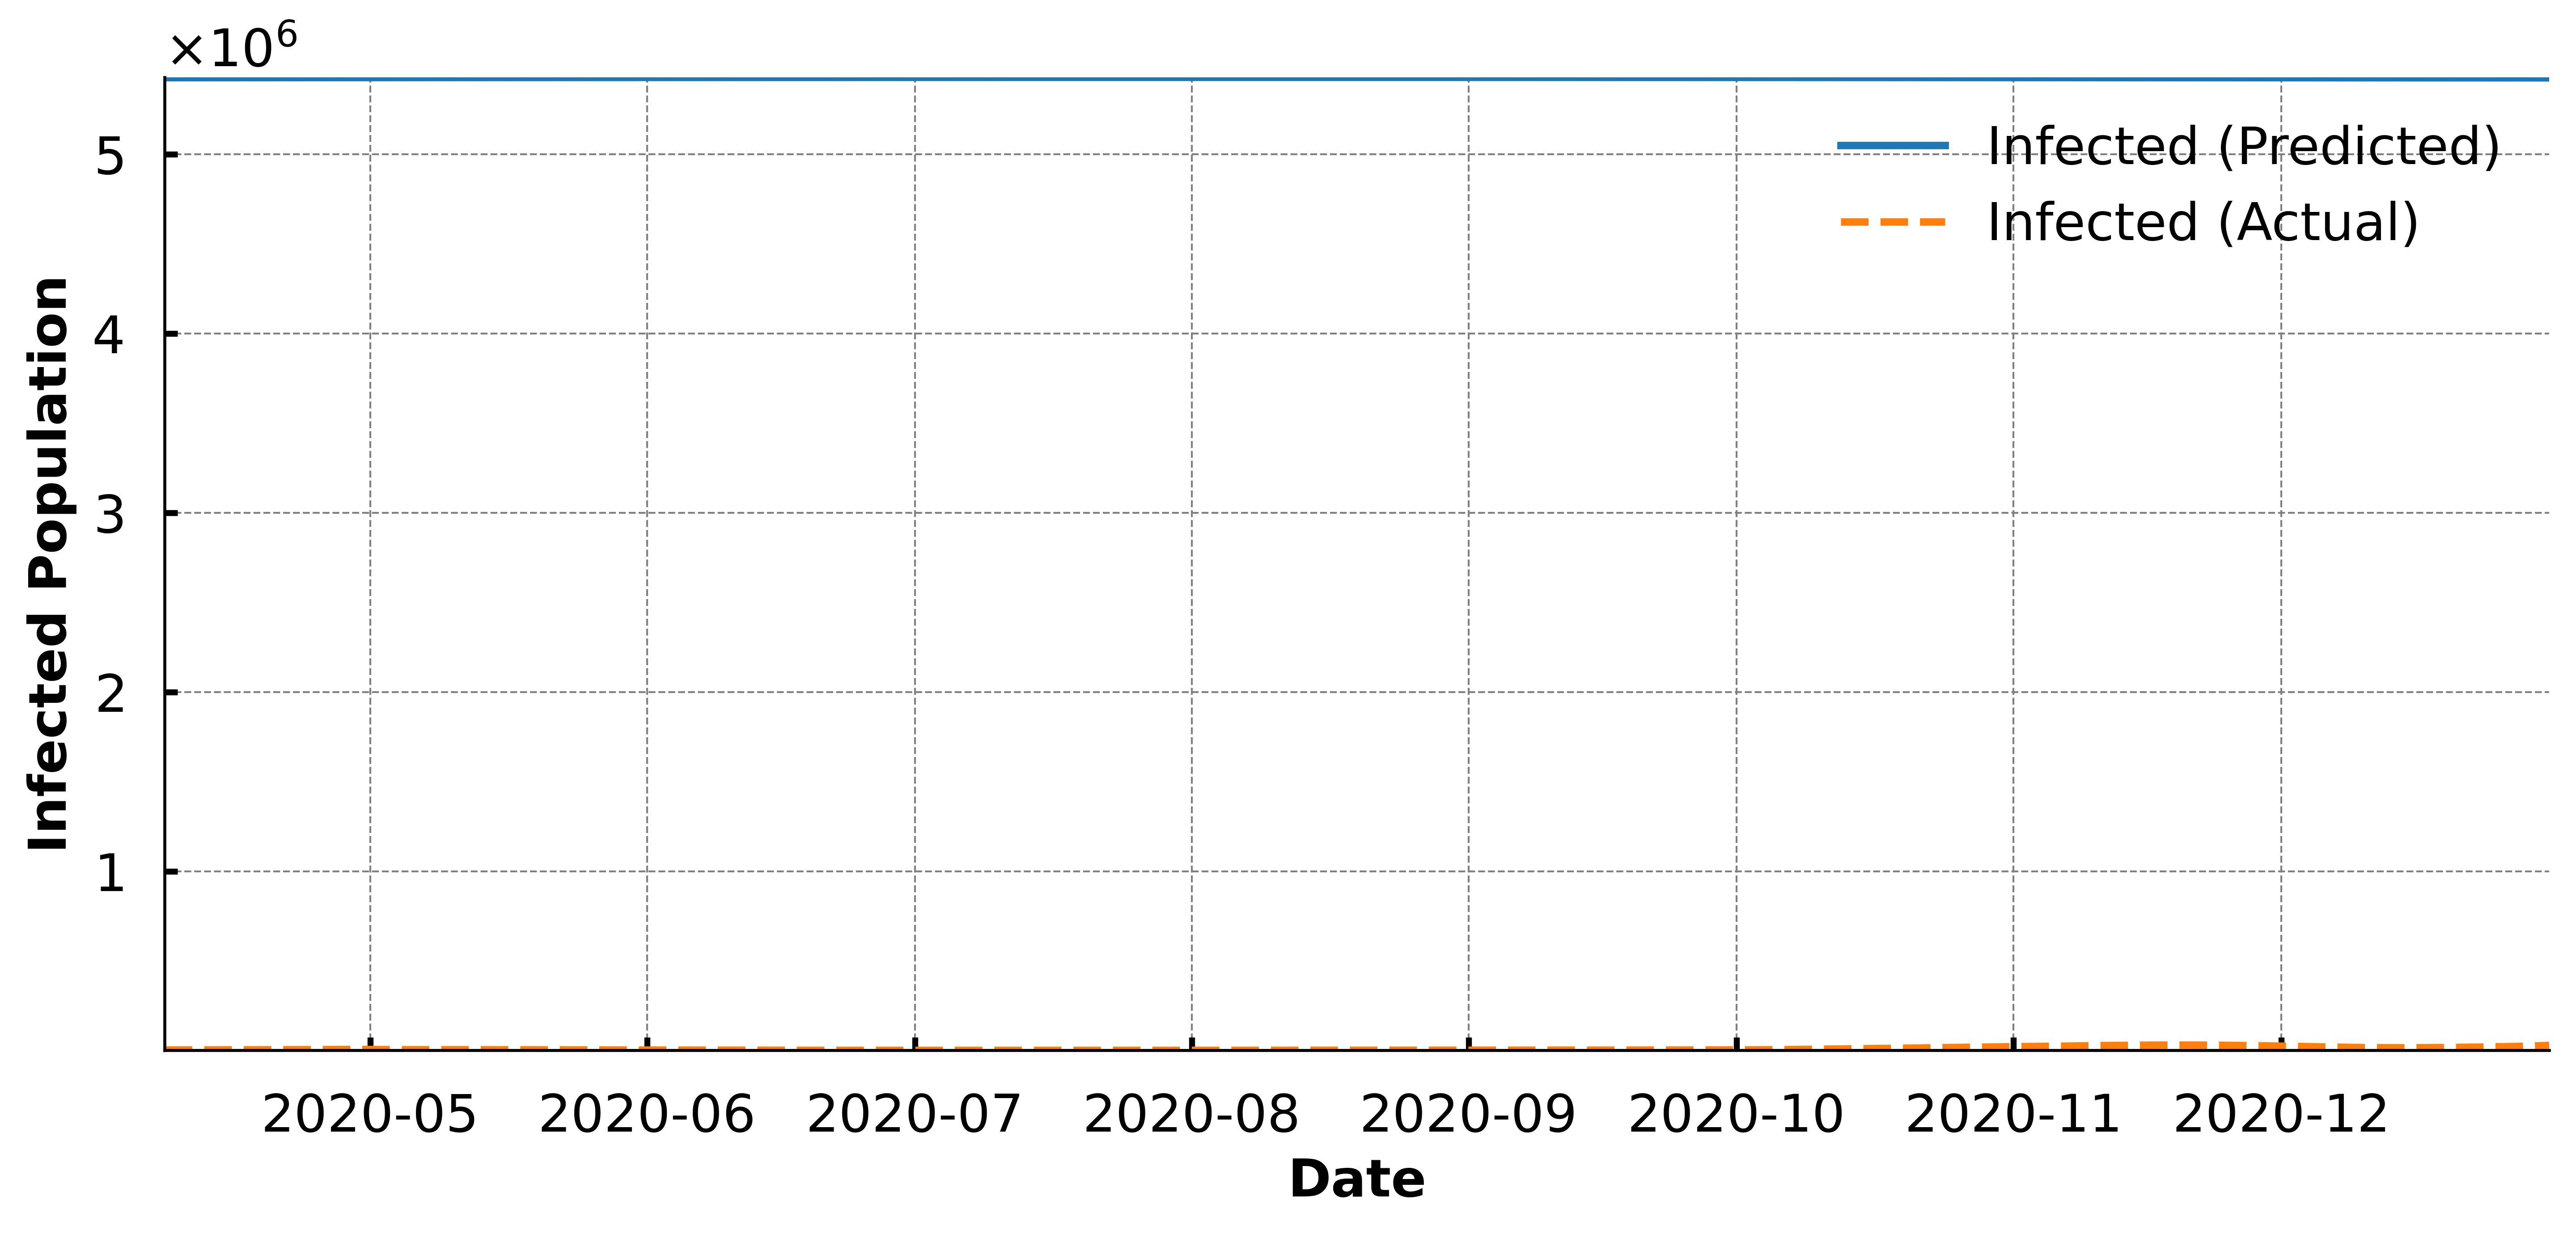

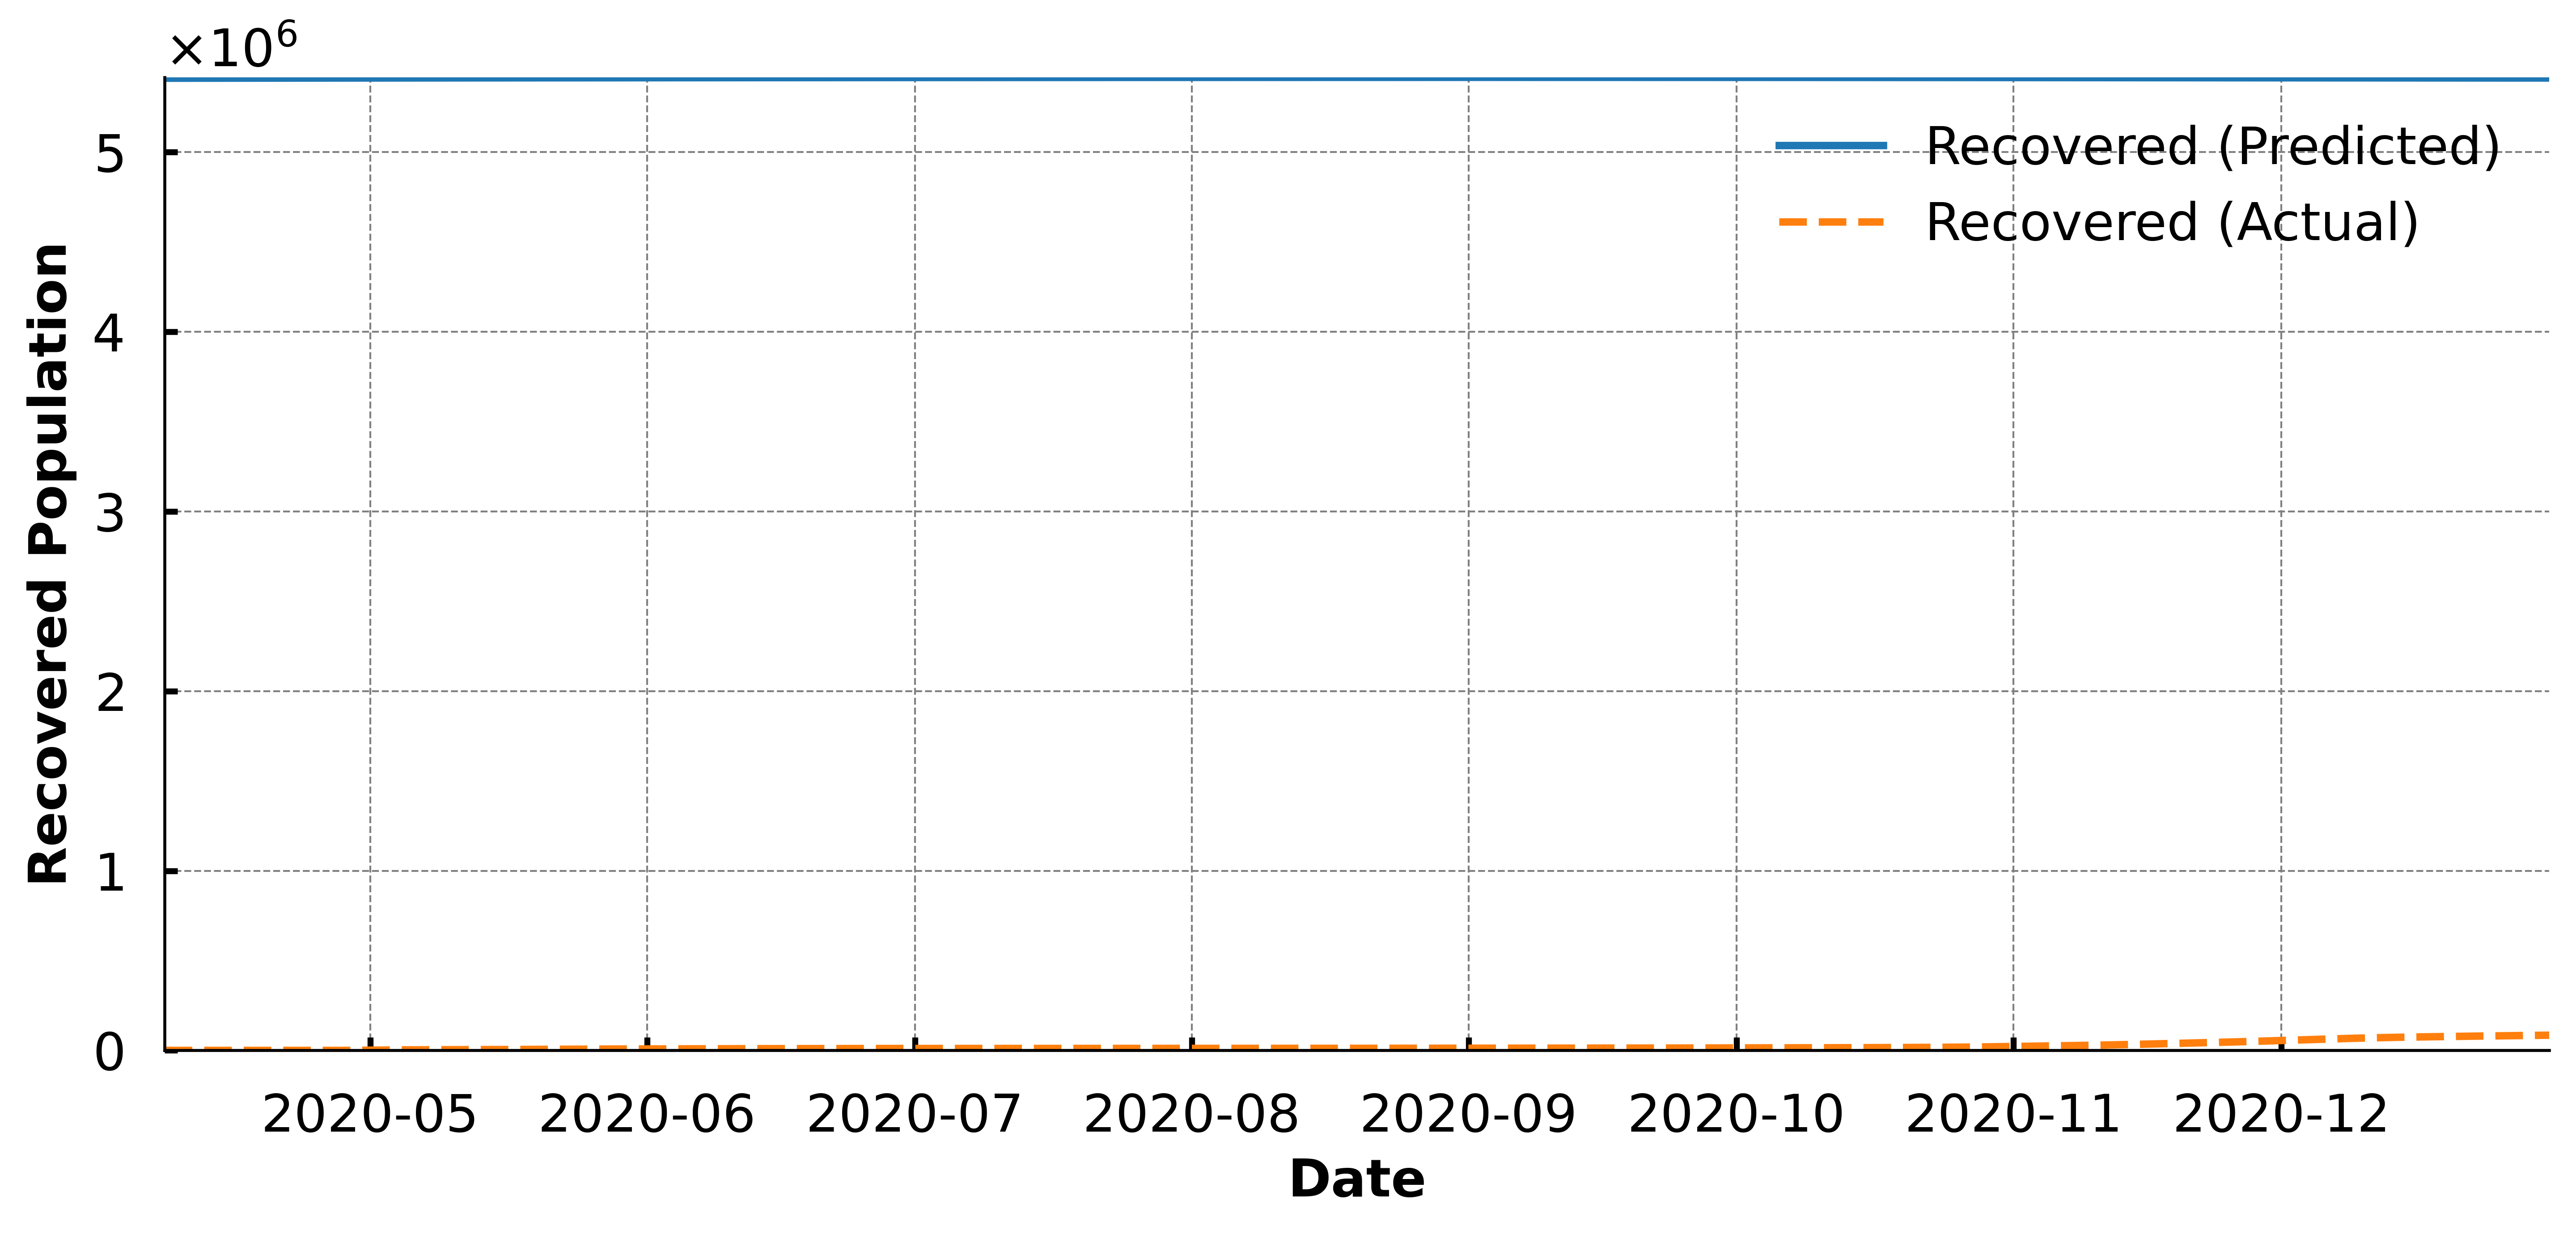

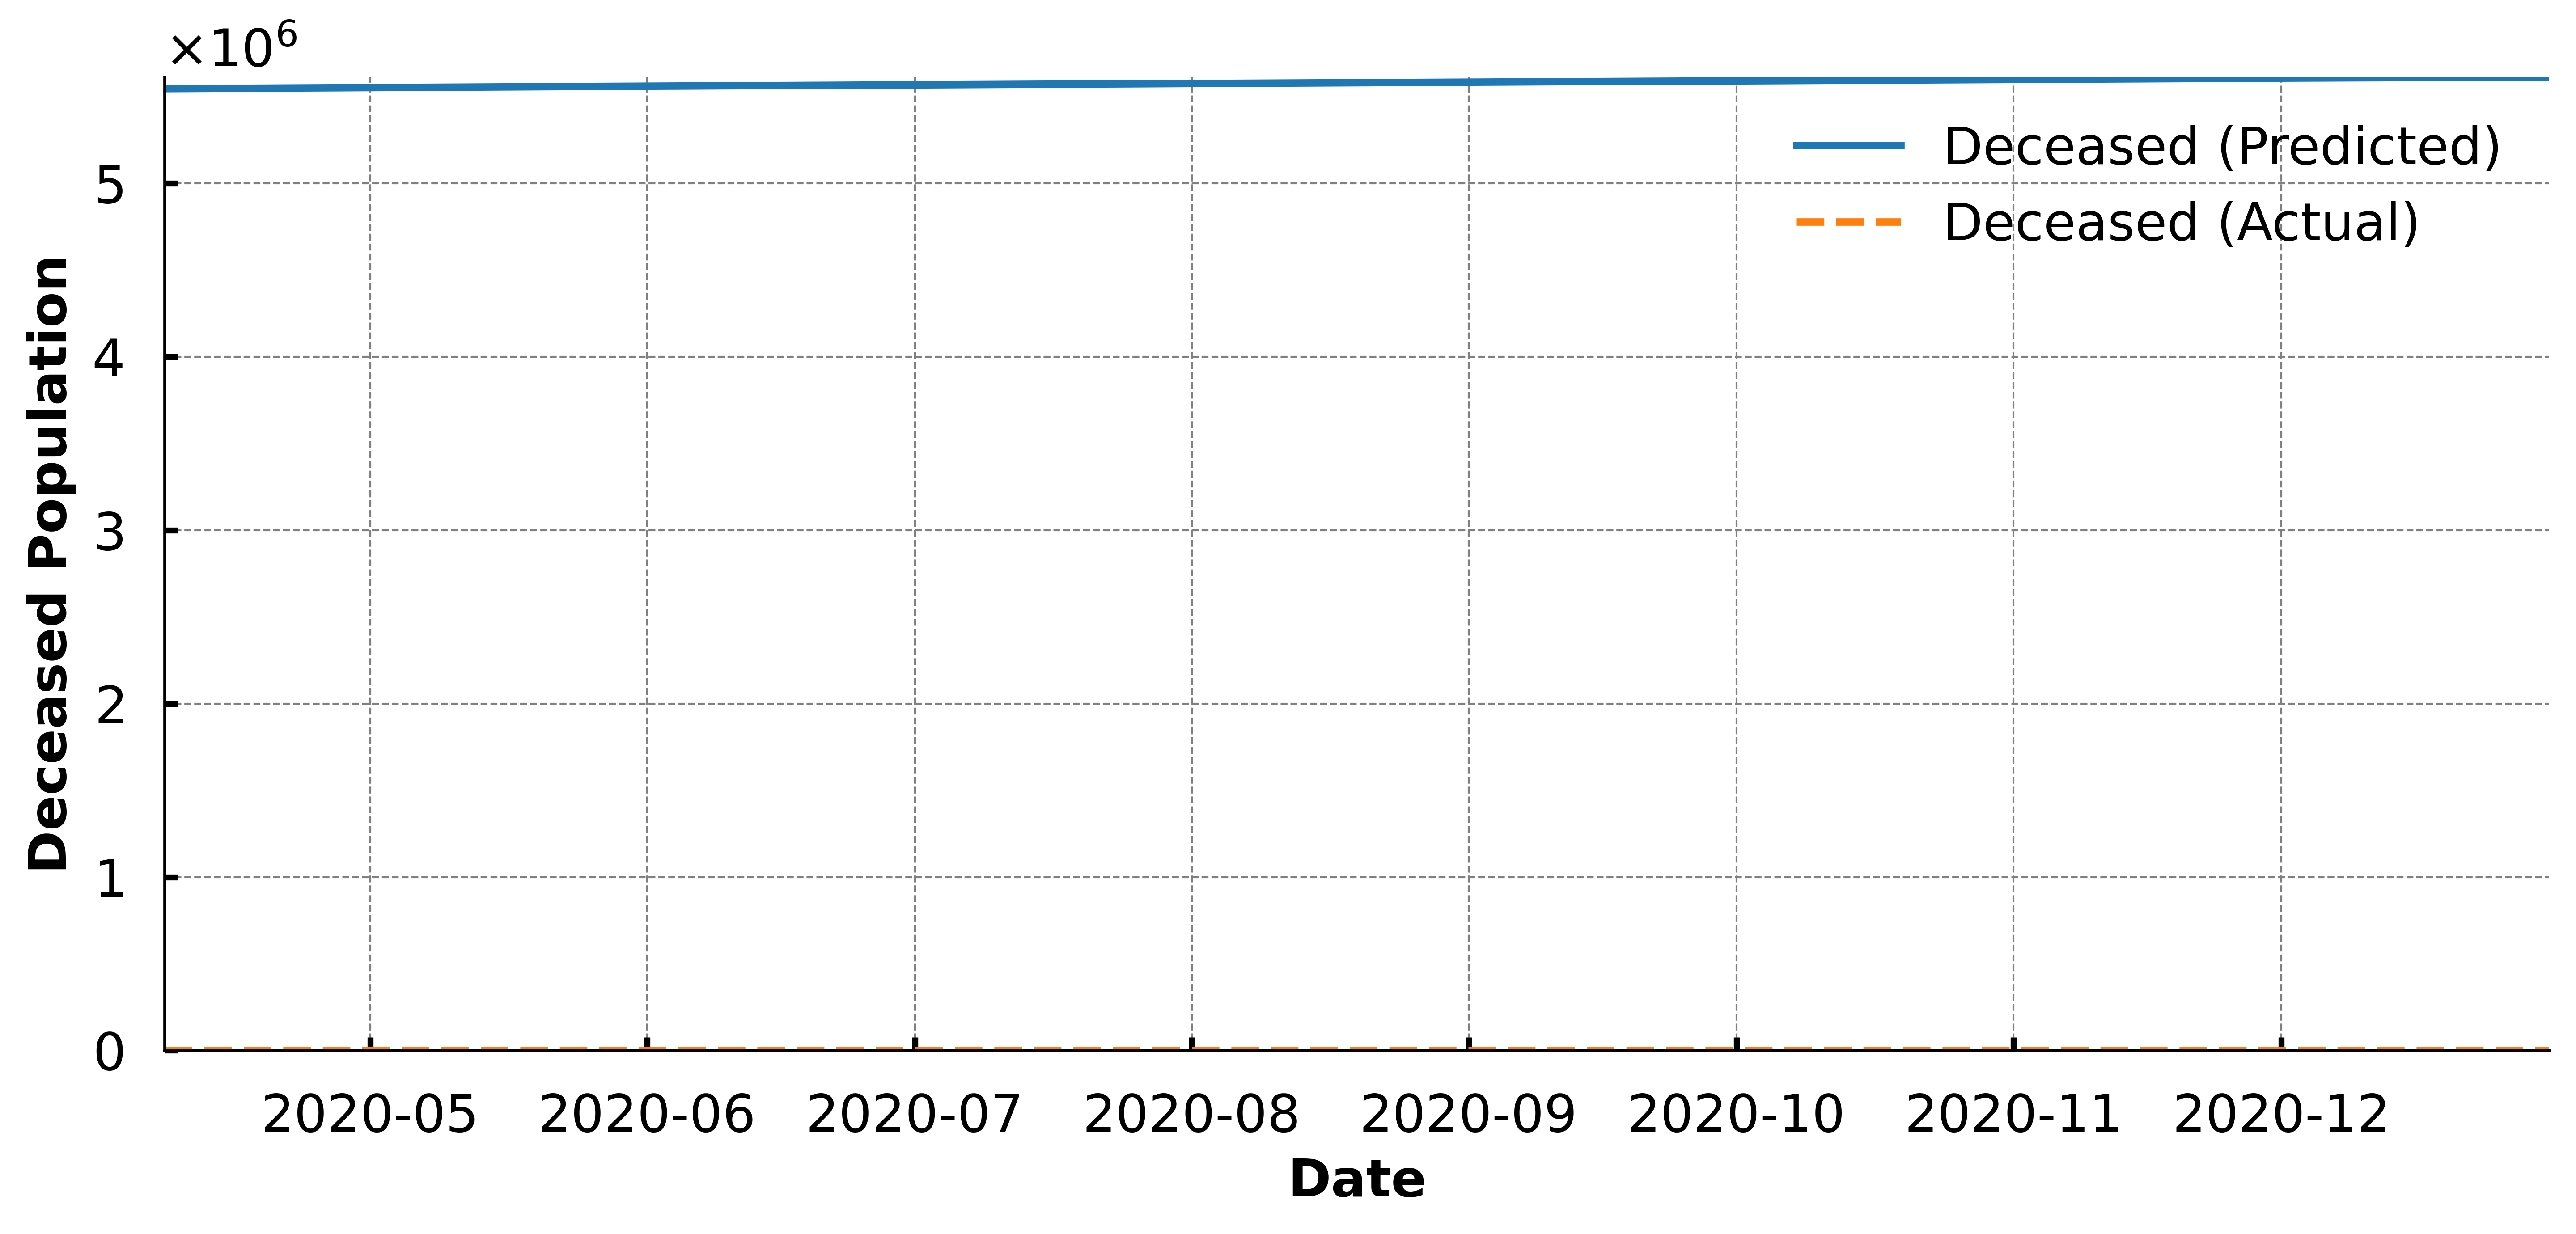

In [6]:
# Predict and plot the results
state_nn.eval()
param_nn.eval()

with torch.no_grad():
    t = torch.linspace(0, 1, steps=len(t_data)).view(-1, 1).to(device)
    states_pred = state_nn(t).cpu().numpy()
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_pred = scaler.inverse_transform(np.concatenate([I_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    R_pred = scaler.inverse_transform(np.concatenate([R_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    D_pred = scaler.inverse_transform(np.concatenate([D_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]

# Plot infected predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot recovered predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot deceased predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch [1/50000], Loss: 43.687660
Epoch [501/50000], Loss: 0.263308
Epoch [1001/50000], Loss: 0.238098
Epoch [1501/50000], Loss: 0.228444
Epoch [2001/50000], Loss: 0.224868
Epoch [2501/50000], Loss: 0.223406
Epoch [3001/50000], Loss: 0.222750
Epoch [3501/50000], Loss: 0.222425
Epoch [4001/50000], Loss: 0.222229
Epoch [4501/50000], Loss: 0.222094
Epoch [5001/50000], Loss: 0.221996
Epoch [5501/50000], Loss: 0.221942
Epoch [6001/50000], Loss: 0.221899
Epoch [6501/50000], Loss: 0.221866
Epoch [7001/50000], Loss: 0.221840
Epoch [7501/50000], Loss: 0.221822
Epoch [8001/50000], Loss: 0.221807
Epoch [8501/50000], Loss: 0.221795
Epoch [9001/50000], Loss: 0.221788
Epoch [9501/50000], Loss: 0.221775
Epoch [10001/50000], Loss: 0.221766
Epoch [10501/50000], Loss: 0.221759
Epoch [11001/50000], Loss: 0.221751
Epoch [11501/50000], Loss: 0.221742
Epoch [12001/50000], Loss: 0.221736
Epoch [12501/50000], Loss: 0.221725
Epoch [13001/50000], Loss: 0.221716
Epoch [13501/50000], Loss: 0.221717
Epoch [14001/50

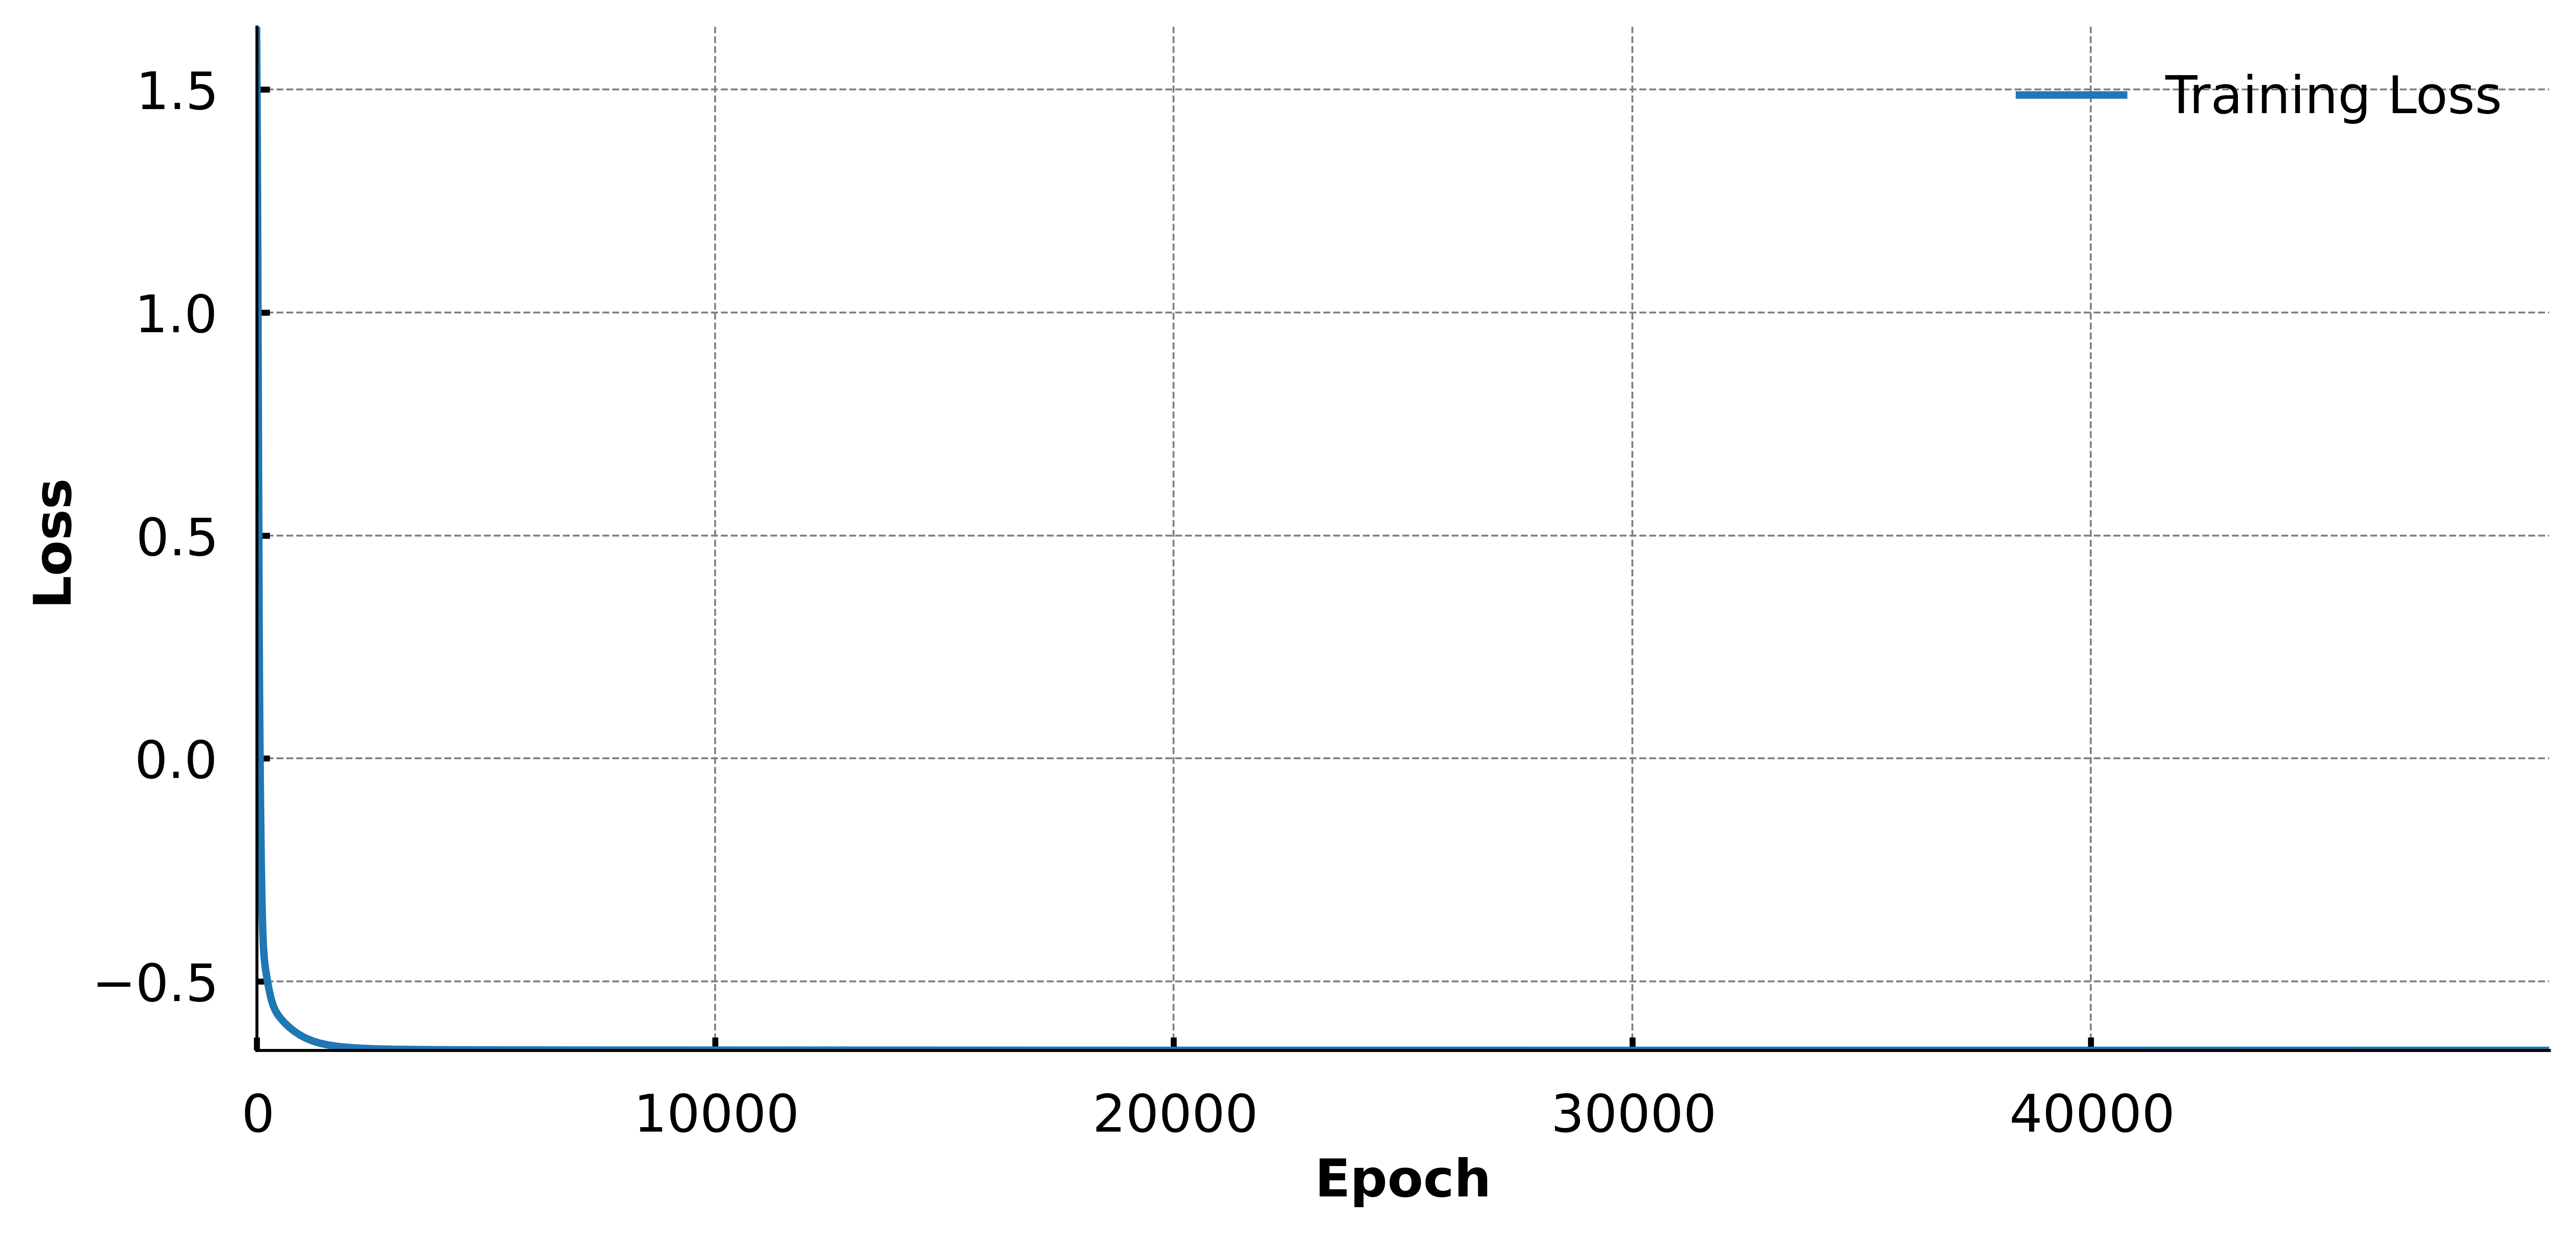

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2021-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return 0.5 * torch.tanh(self.alpha * x) + self.epsilon

class ResBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        identity = x.clone()
        out = self.fc(x)
        out = self.activation(out)
        if out.shape == identity.shape:
            out = out + identity
        return out

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

    def predict_parameters(self, t):
        params = self.net(t)
        # Ensure beta, gamma, and mu are in a valid range
        beta = torch.sigmoid(params[:, 0]) * 0.5  # range: [0, 0.5]
        gamma = torch.sigmoid(params[:, 1]) * 0.1  # range: [0, 0.1]
        mu = torch.sigmoid(params[:, 2]) * 0.1  # range: [0, 0.1]
        return beta, gamma, mu

def pinn_loss(t, data, state_nn, param_nn, N, sigma):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True, retain_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True, retain_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True, retain_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True, retain_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True, retain_graph=True)[0]
    
    # Predicted parameters
    beta_pred, gamma_pred, mu_pred = param_nn.predict_parameters(t)
    
    # SEIRD model residuals
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, N)
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial conditions loss
    loss_init = torch.mean((S_pred[0] - S_data[0])**2) + torch.mean((I_pred[0] - I_data[0])**2) + torch.mean((R_pred[0] - R_data[0])**2) + torch.mean((D_pred[0] - D_data[0])**2)
    
    total_loss = loss_data + loss_physics + loss_init       
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# scheduler 
scheduler_state = StepLR(optimizer_state, step_size=5000, gamma=0.7)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
# torch.autograd.set_detect_anomaly(True)
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = t_data
    
    data_tensors = (S_data, I_data, R_data, D_data)
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    scheduler_state.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

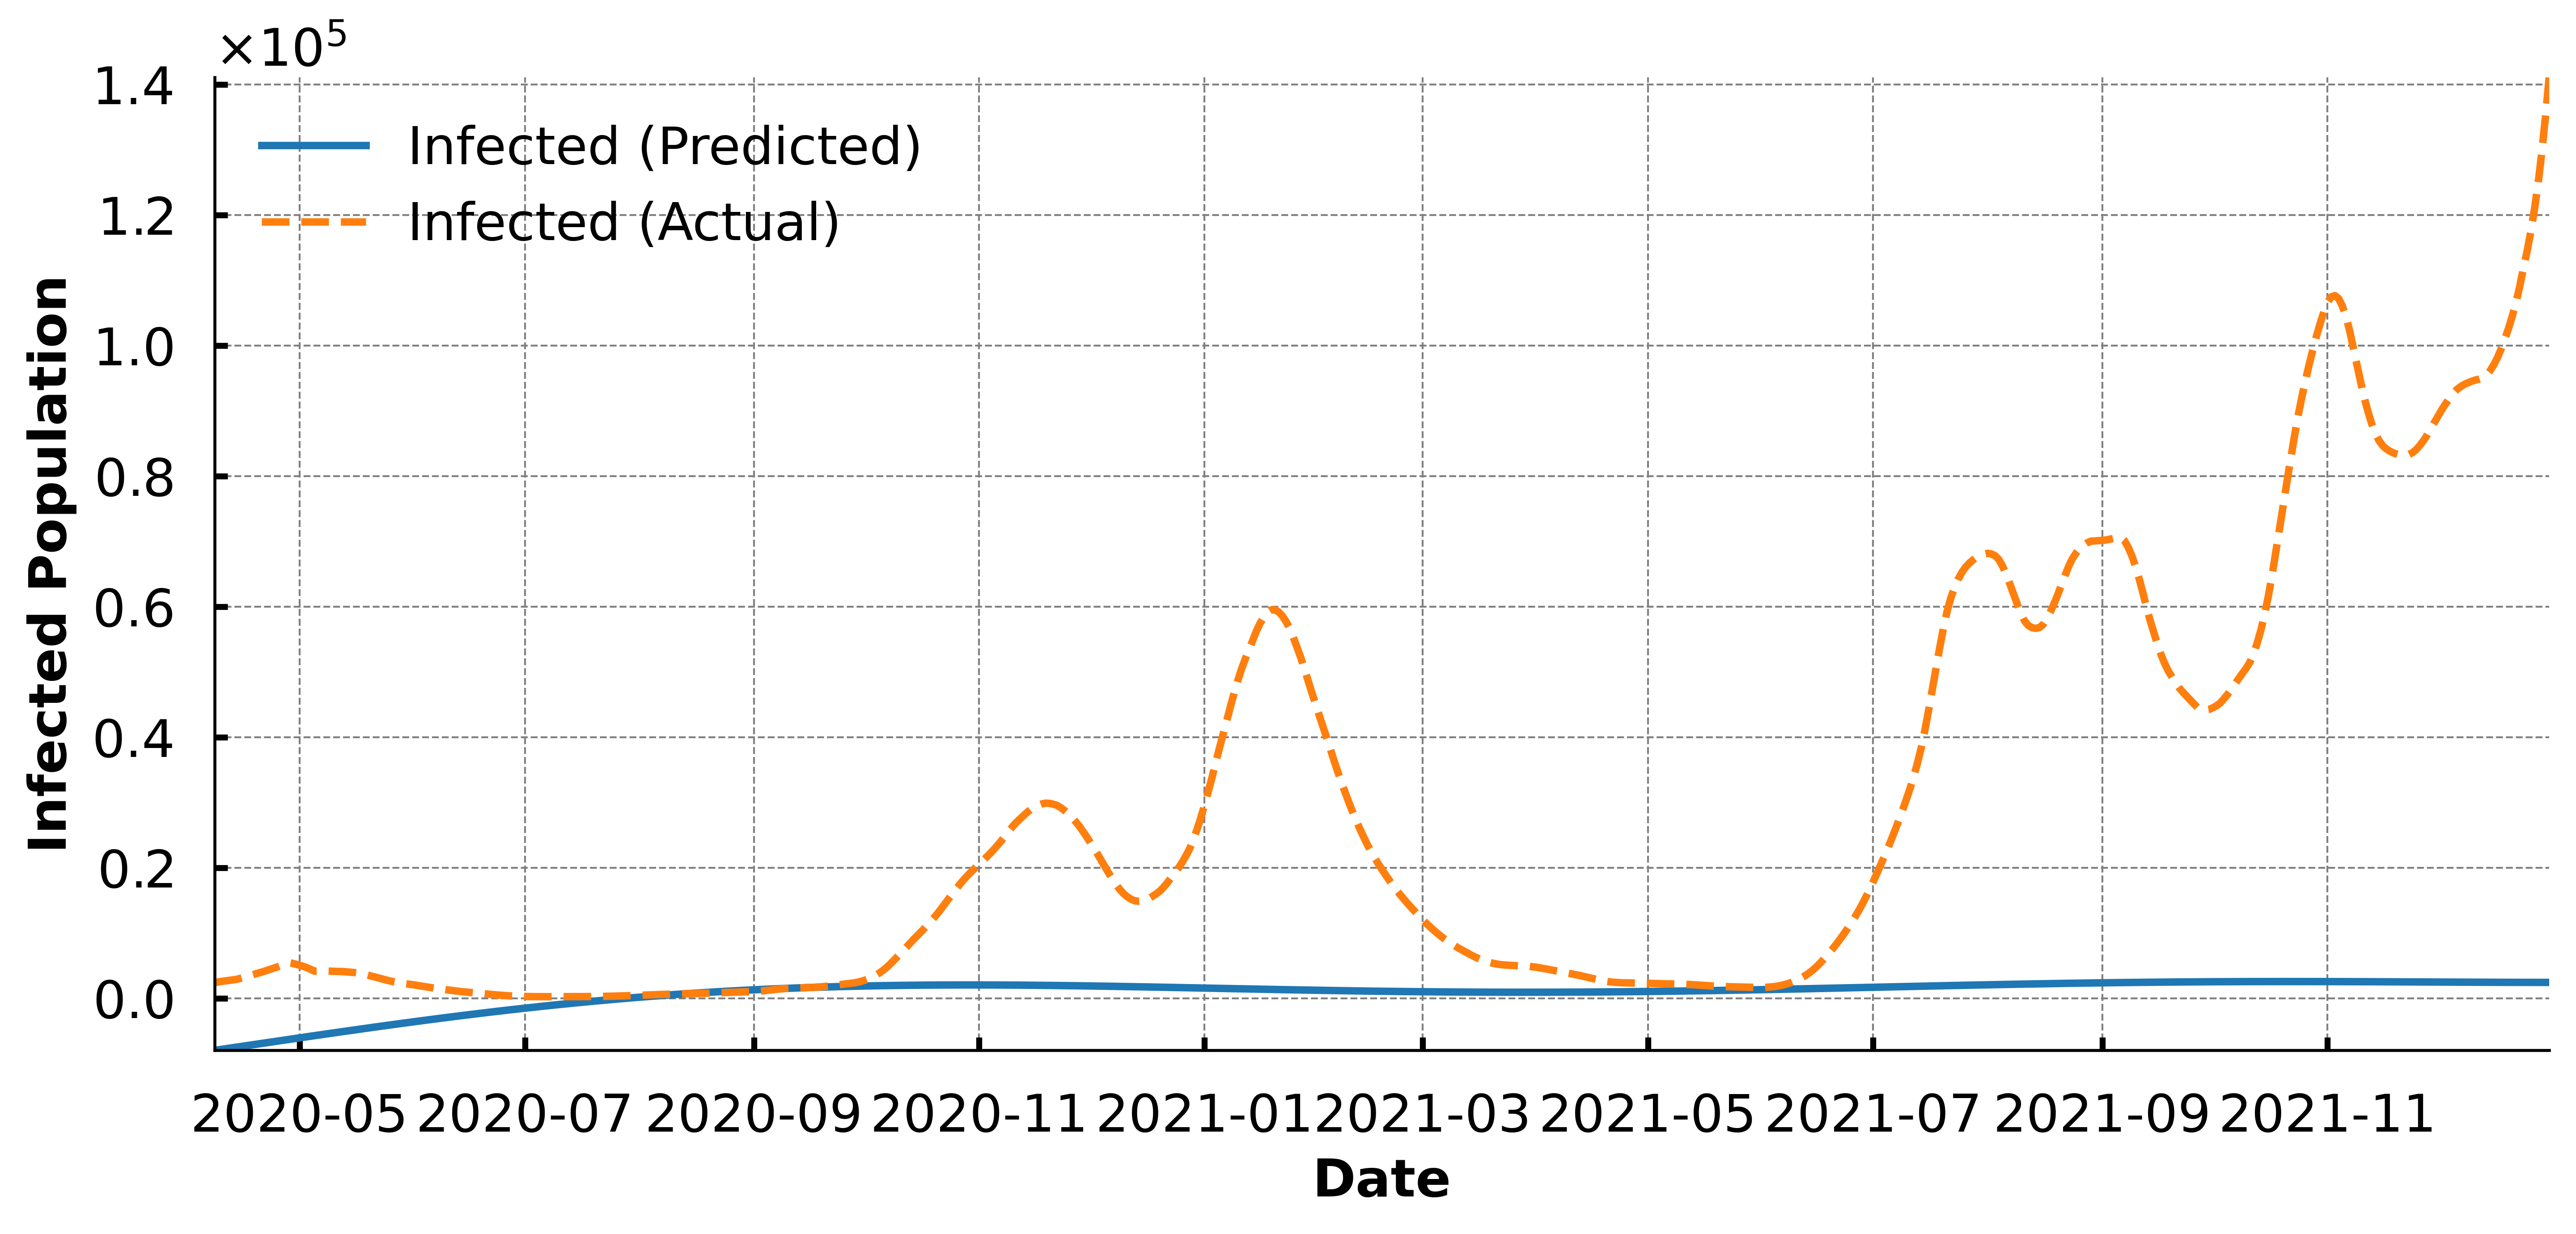

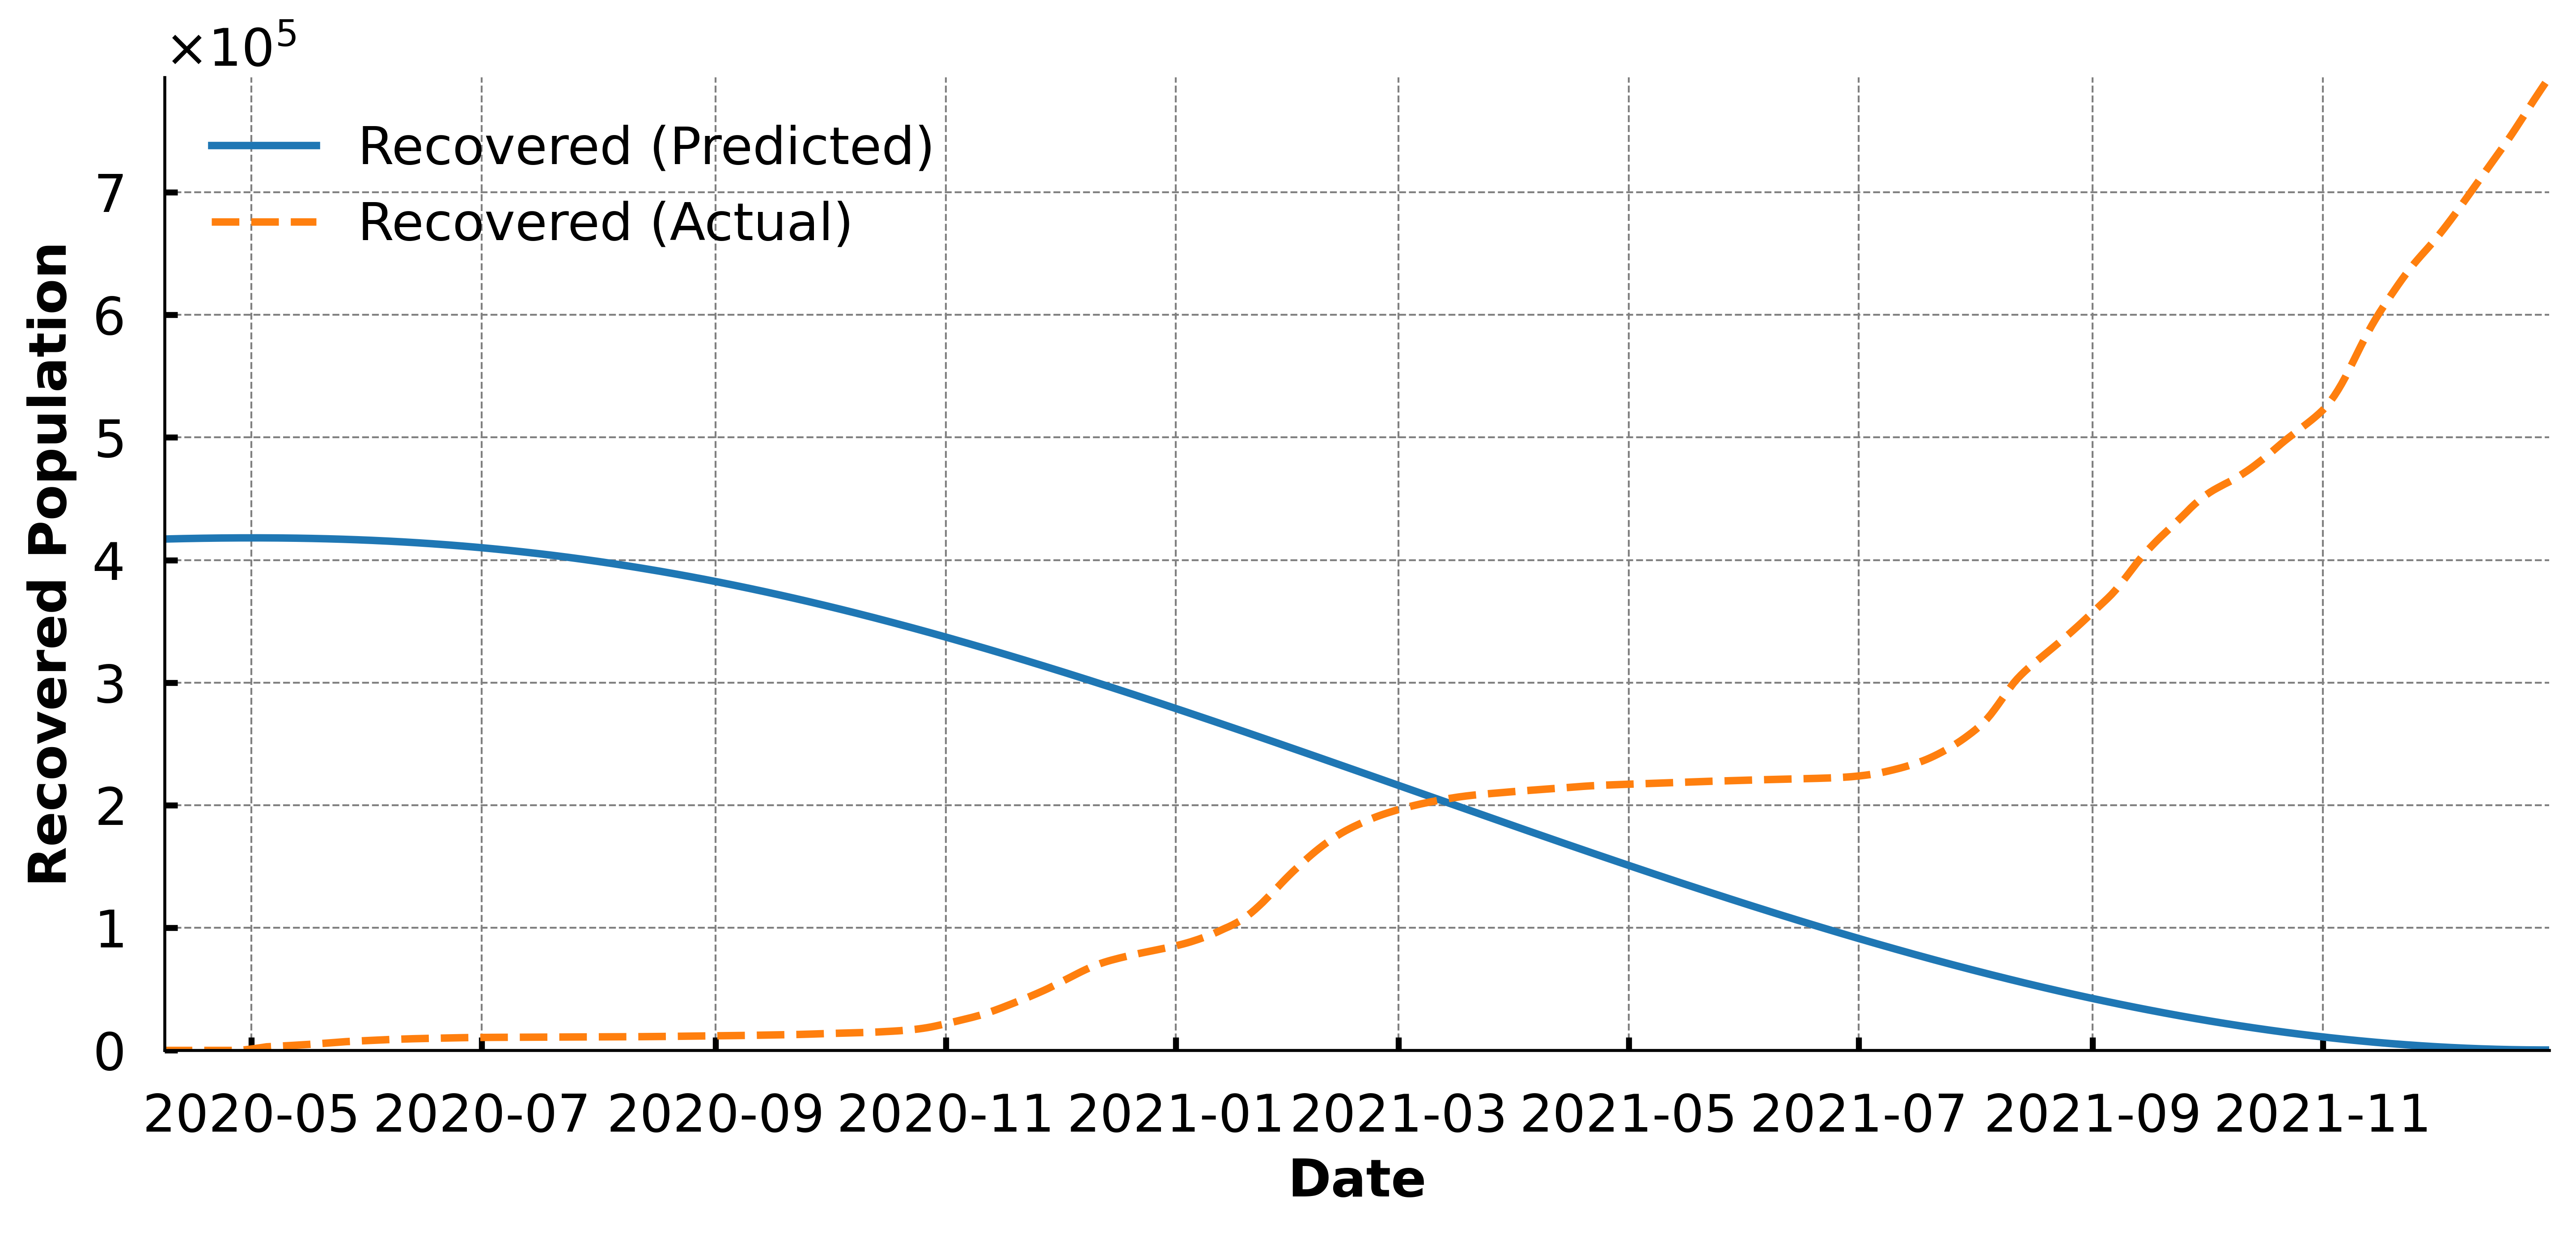

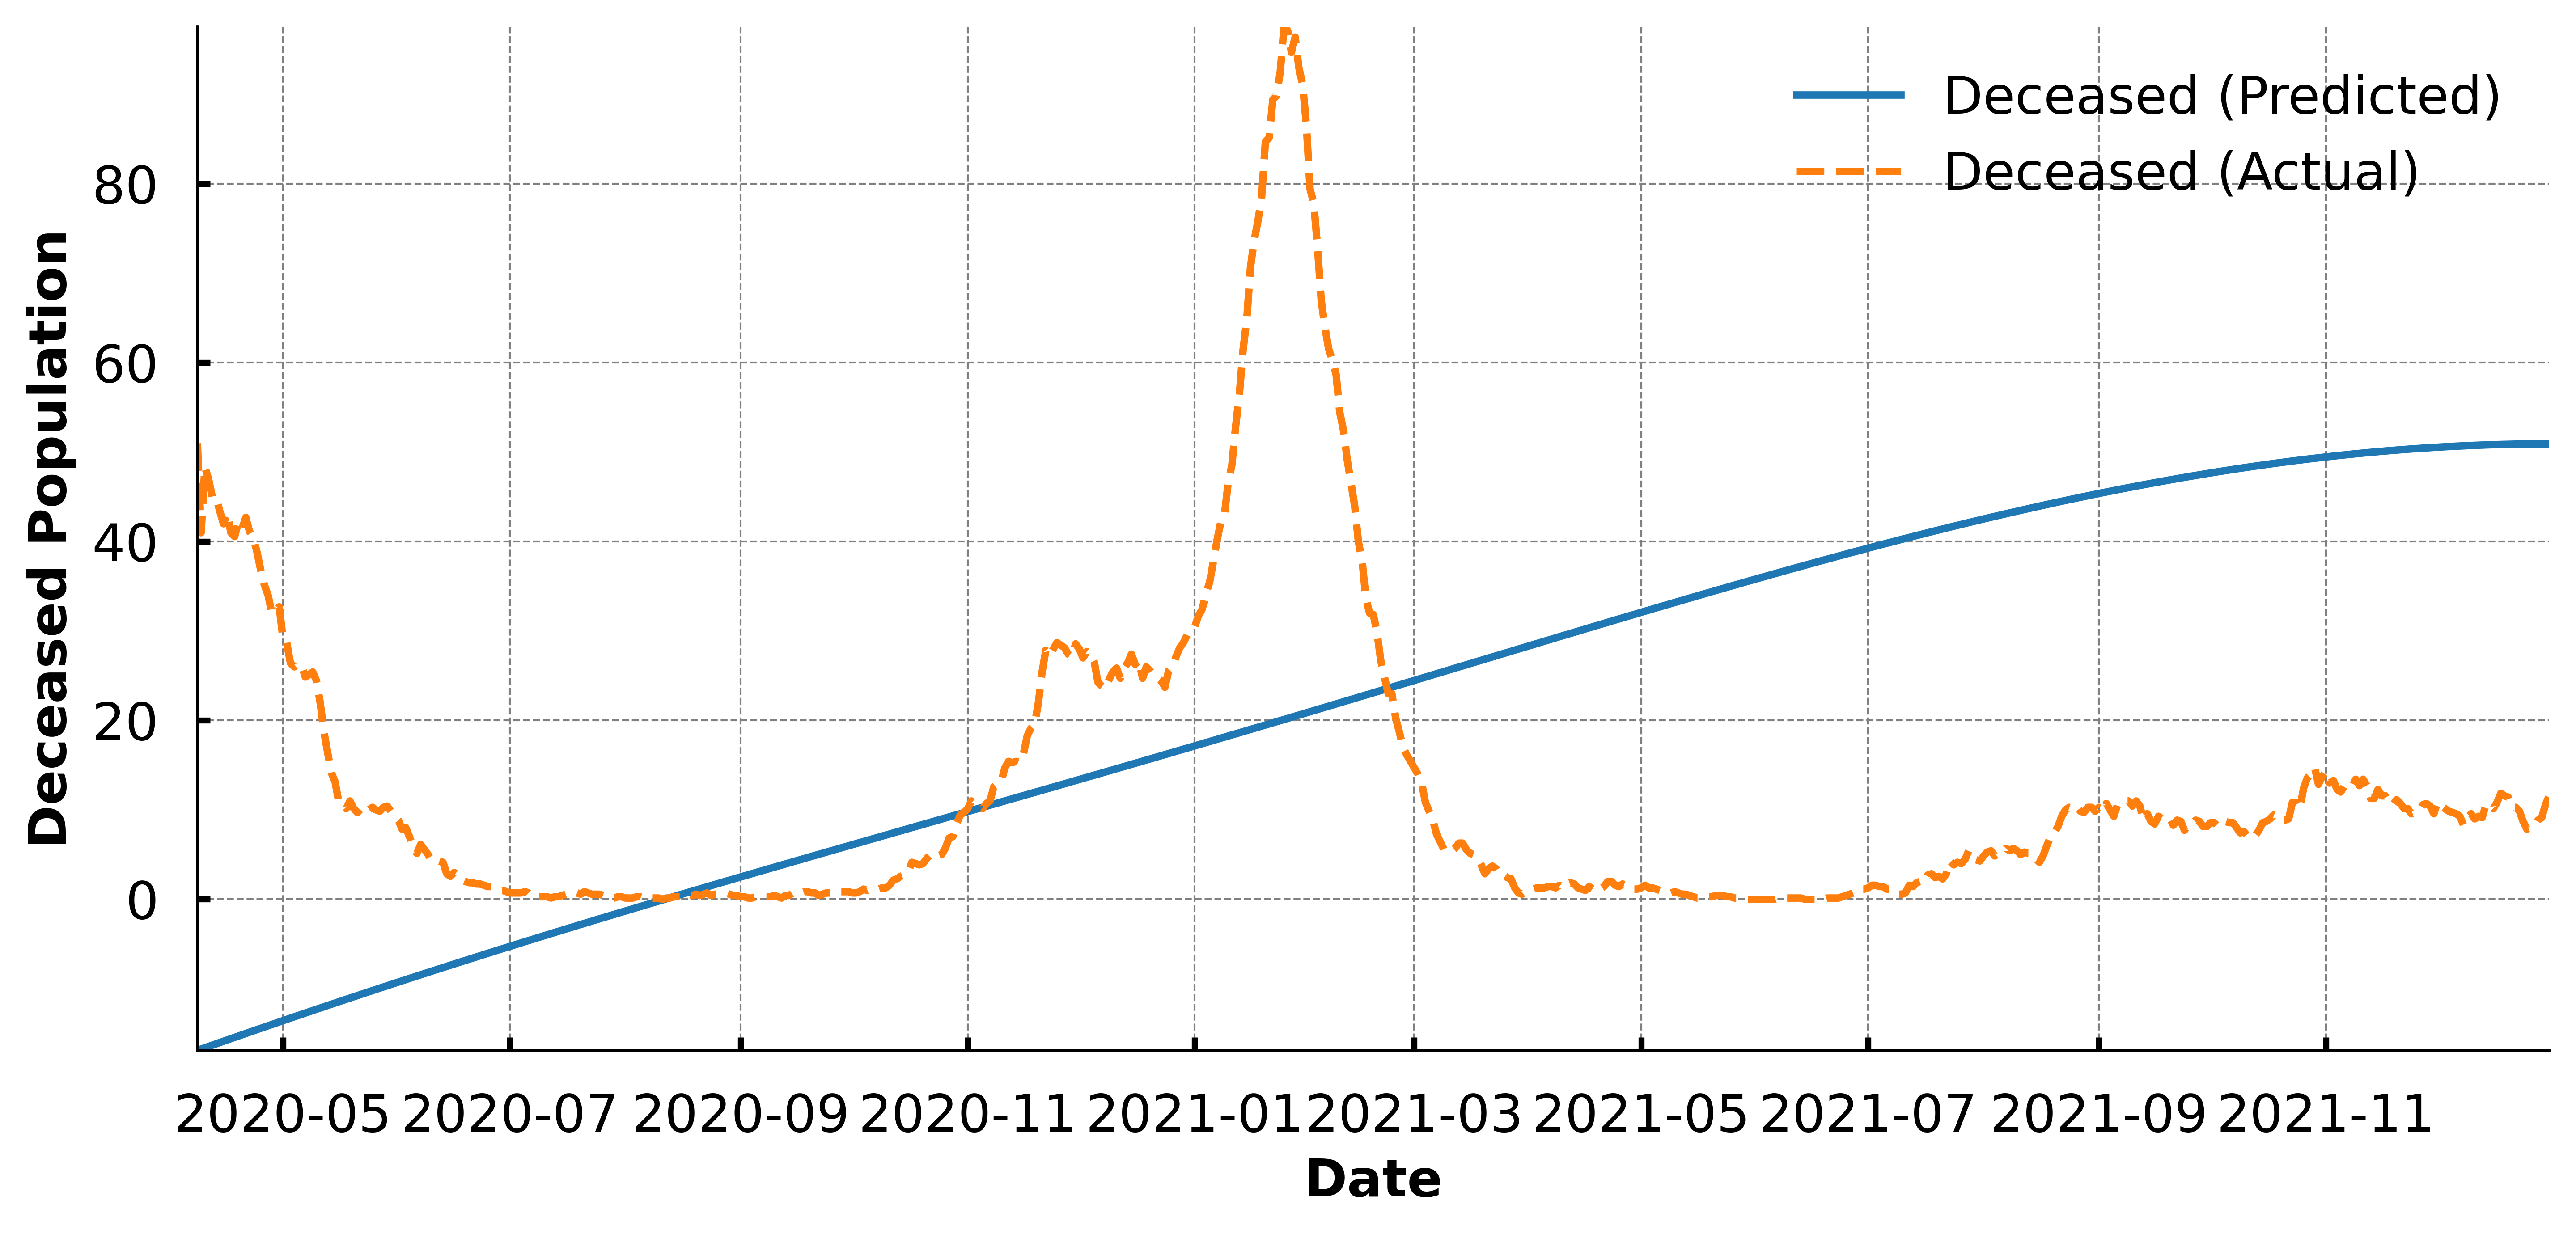

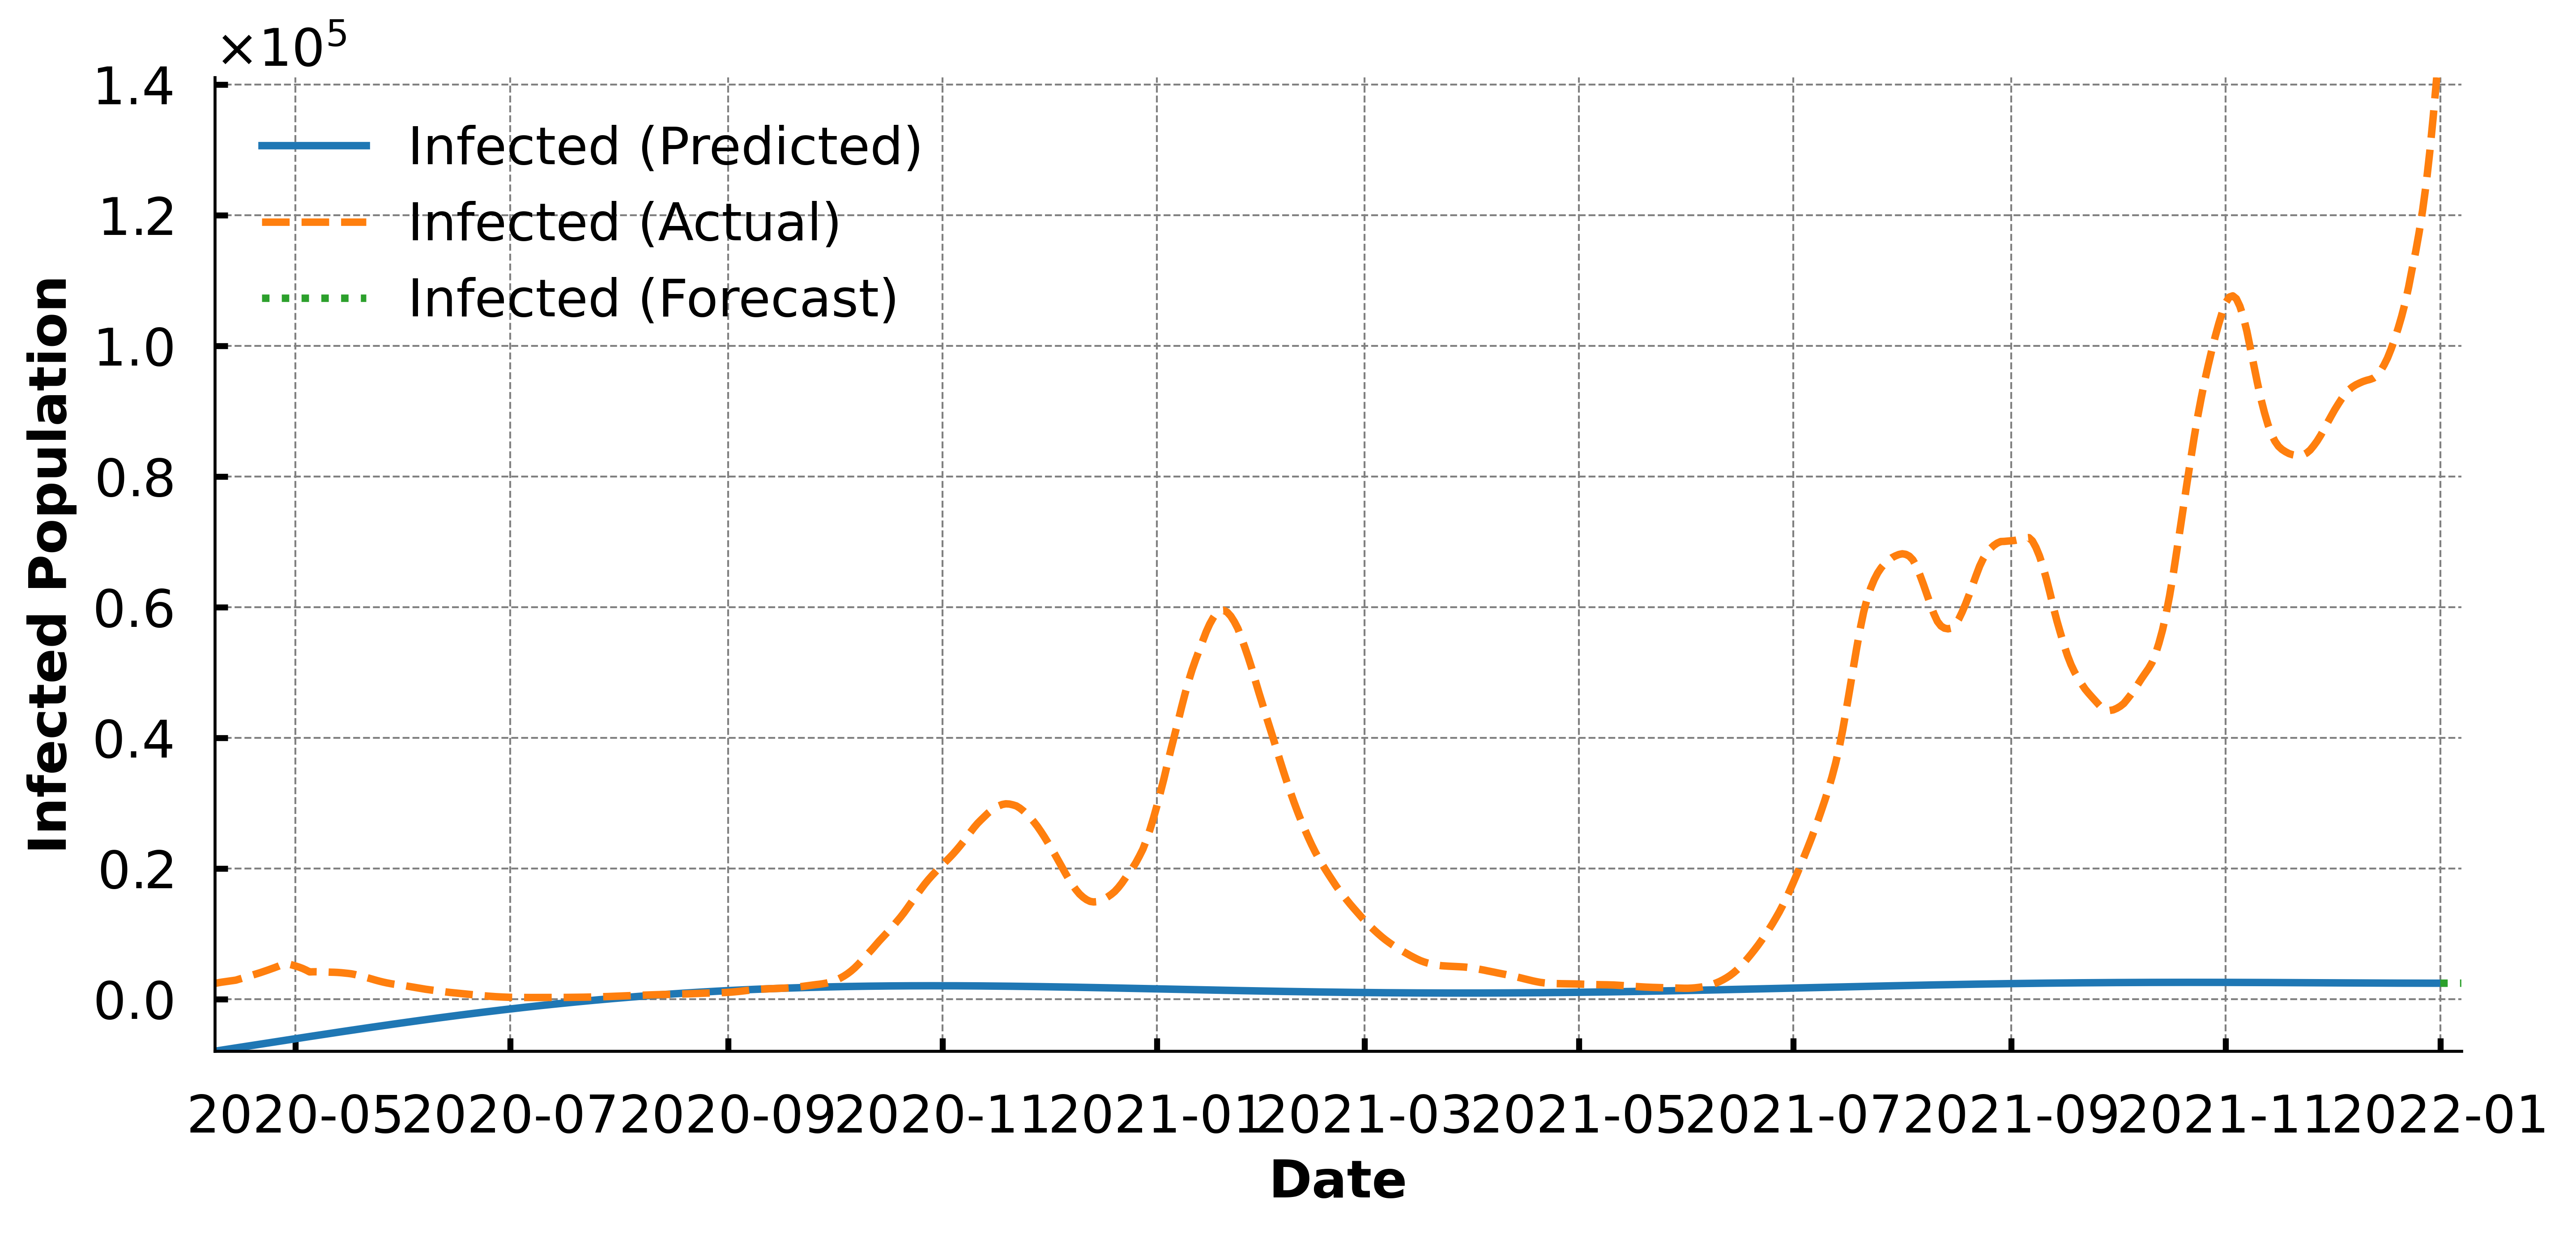

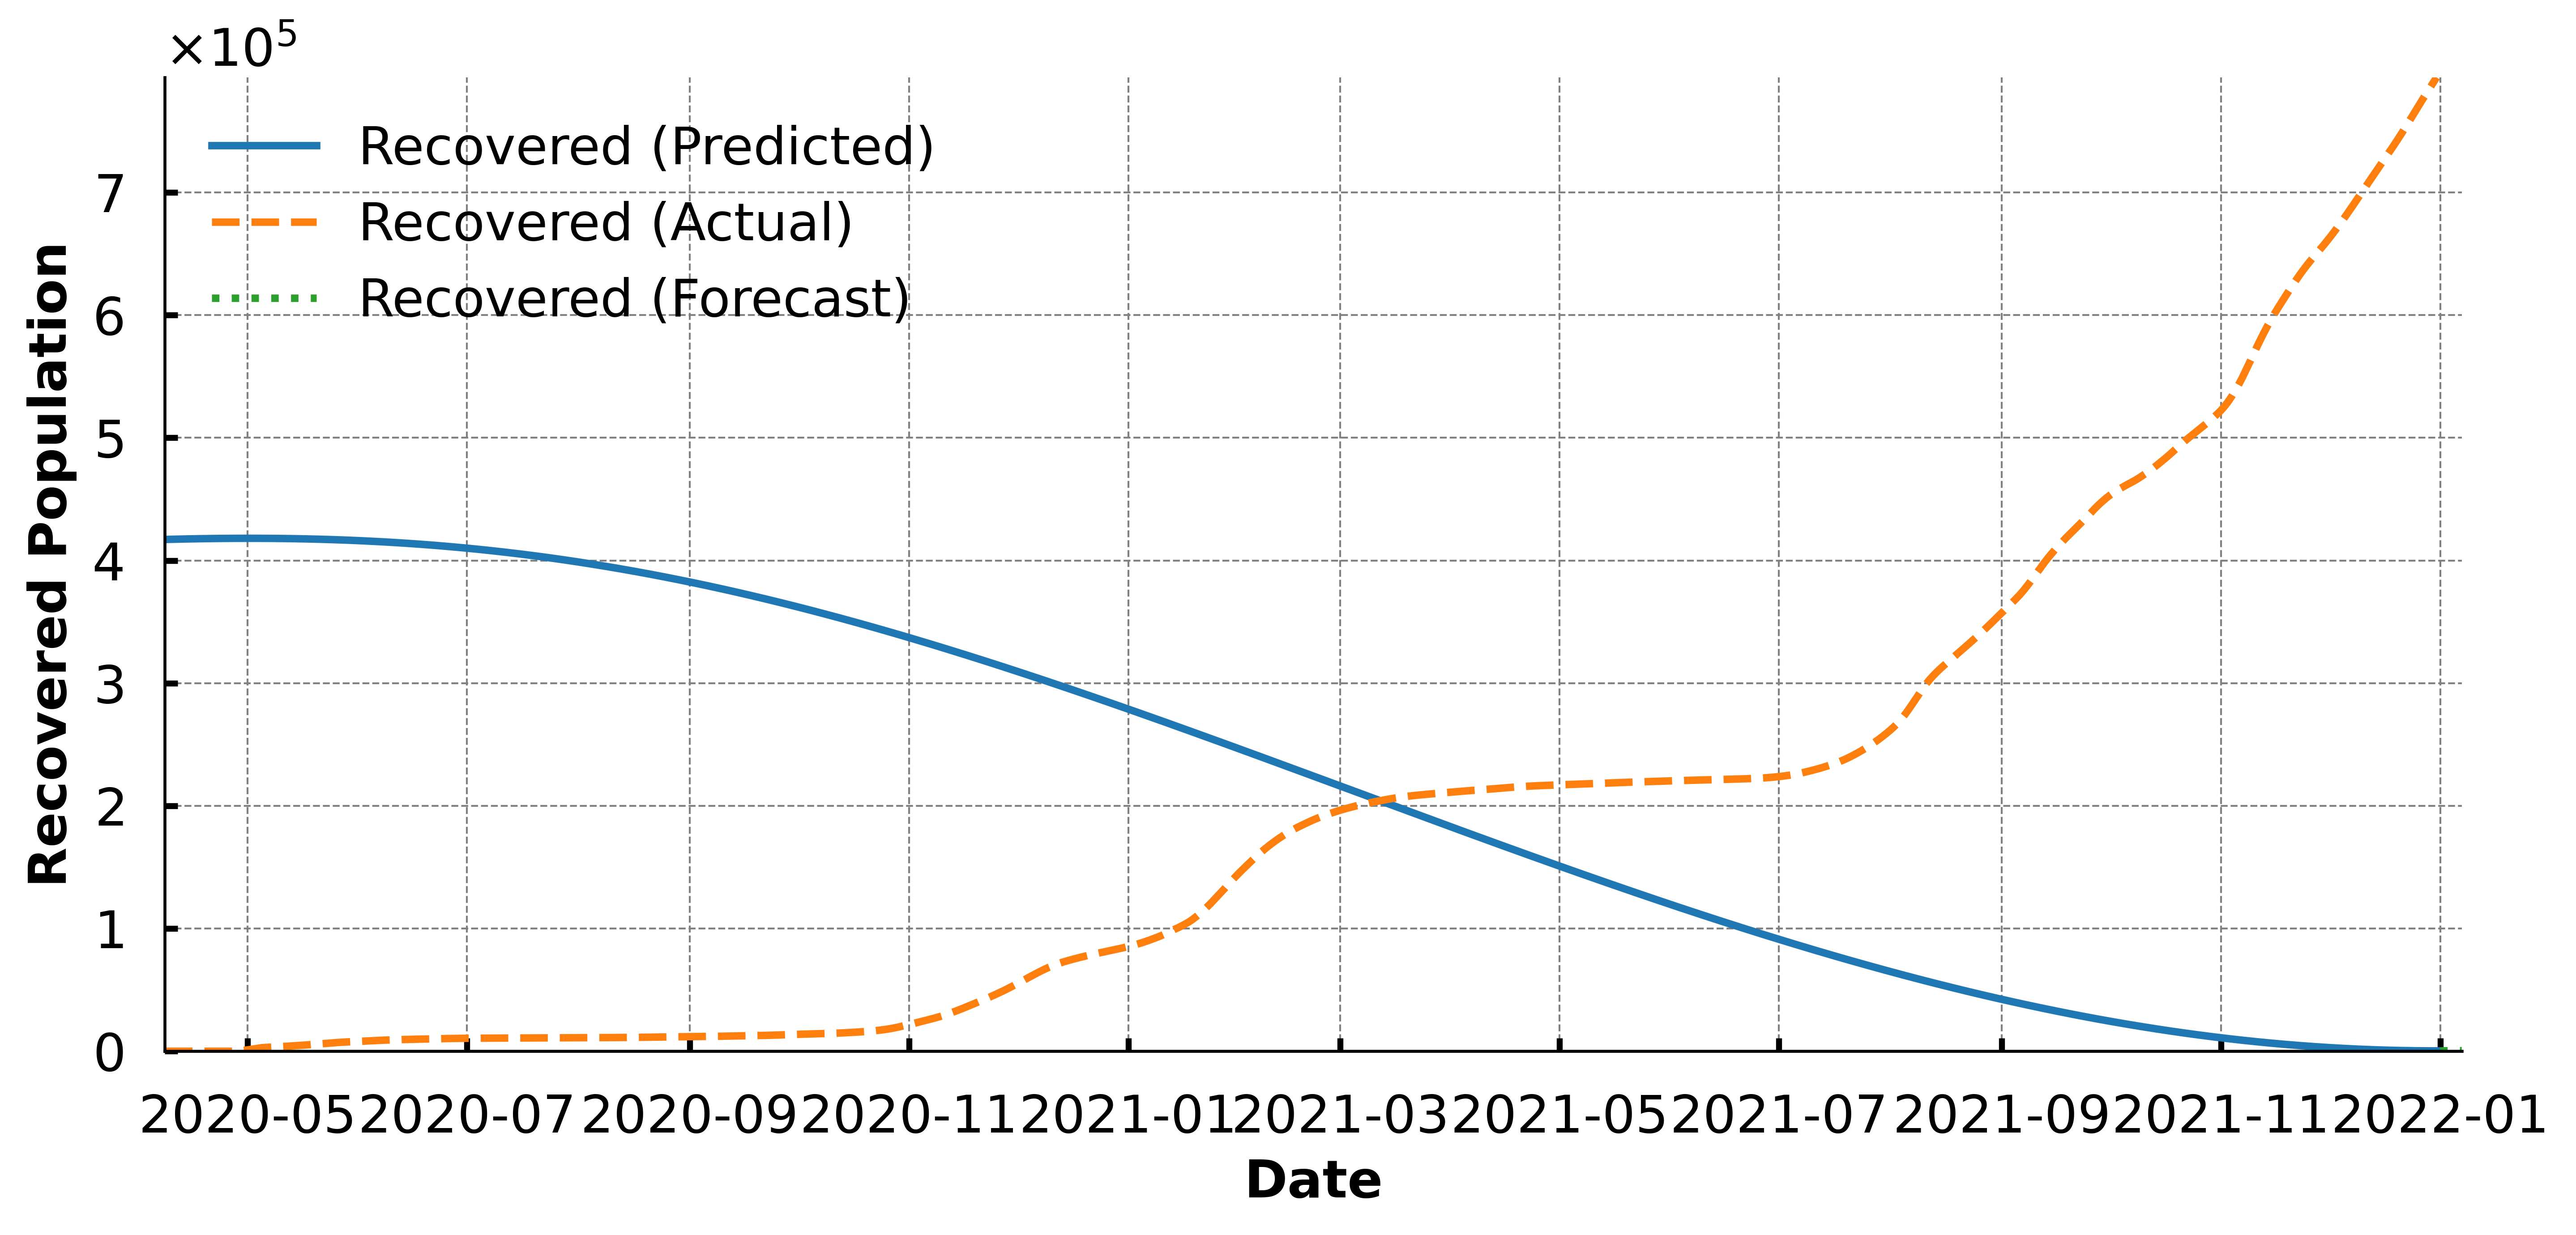

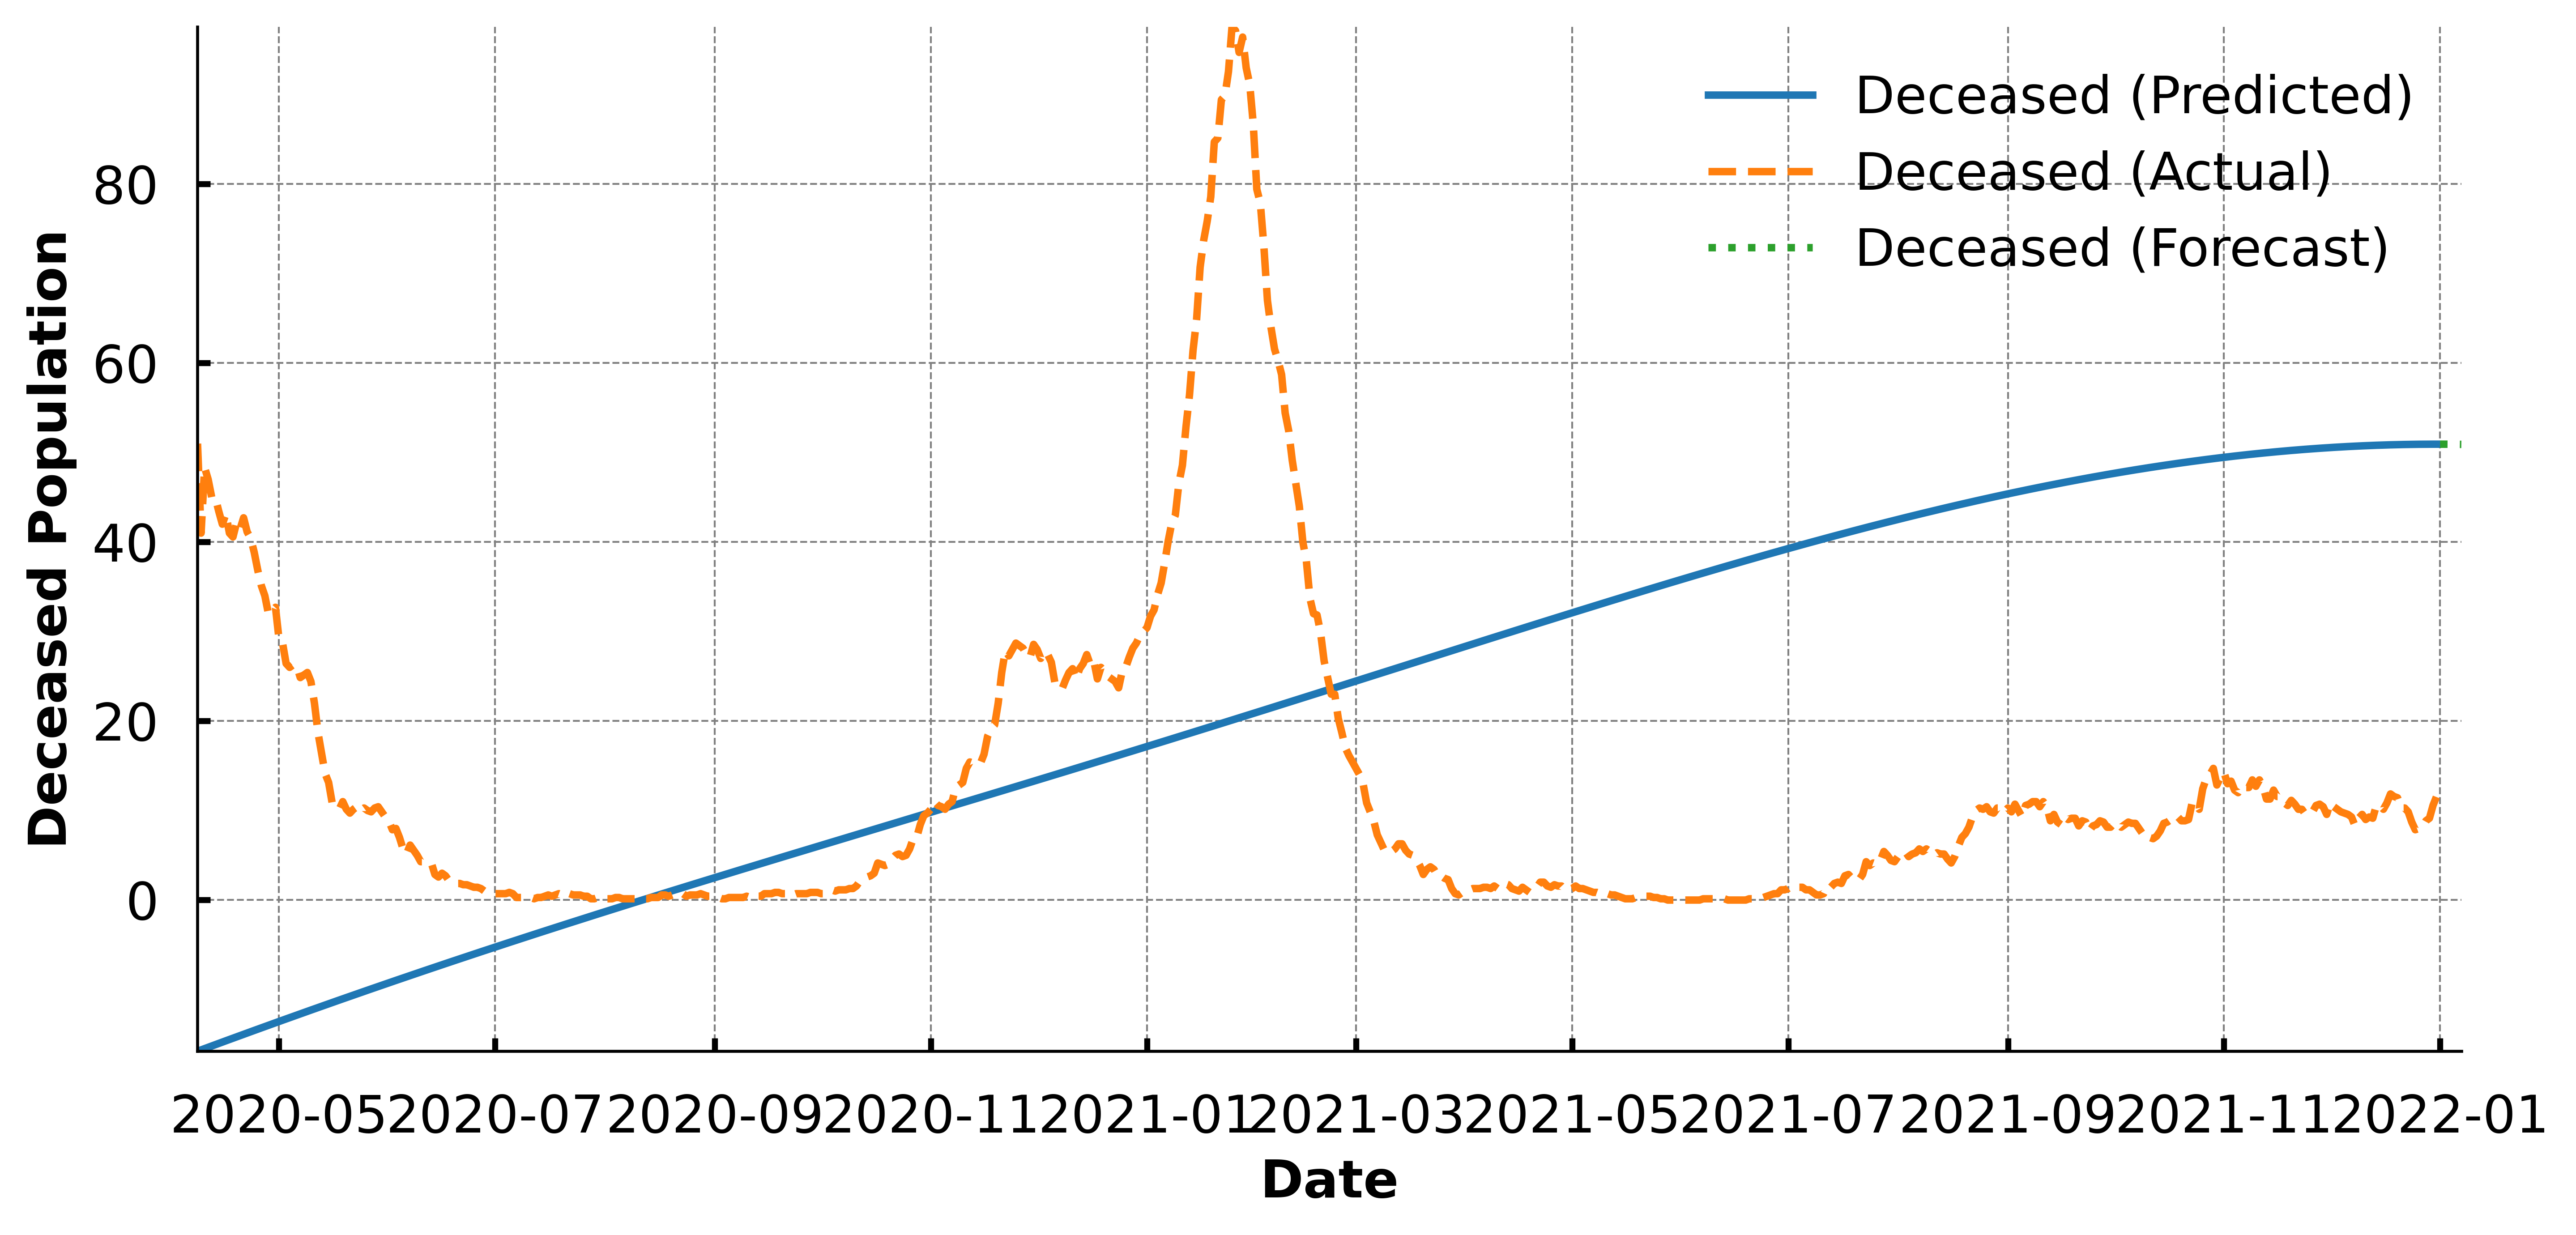

In [3]:
# Predict and plot the results
state_nn.eval()
param_nn.eval()

with torch.no_grad():
    t = torch.linspace(0, 1, steps=len(t_data)).view(-1, 1).to(device)
    states_pred = state_nn(t).cpu().numpy()
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_pred = scaler.inverse_transform(np.concatenate([I_pred.reshape(-1, 1)] * len(features), axis=1))[:, 1]
    R_pred = scaler.inverse_transform(np.concatenate([R_pred.reshape(-1, 1)] * len(features), axis=1))[:, 2]
    D_pred = scaler.inverse_transform(np.concatenate([D_pred.reshape(-1, 1)] * len(features), axis=1))[:, 3]

# Plot infected predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot recovered predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot deceased predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()

# Forecast for the next 7 days
with torch.no_grad():
    t_forecast = torch.linspace(0, 1 + 7 / len(t_data), steps=len(t_data) + 7).view(-1, 1).to(device)
    states_forecast = state_nn(t_forecast).cpu().numpy()
    S_forecast, E_forecast, I_forecast, R_forecast, D_forecast = states_forecast[:, 0], states_forecast[:, 1], states_forecast[:, 2], states_forecast[:, 3], states_forecast[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_forecast = scaler.inverse_transform(np.concatenate([I_forecast.reshape(-1, 1)] * len(features), axis=1))[:, 1]
    R_forecast = scaler.inverse_transform(np.concatenate([R_forecast.reshape(-1, 1)] * len(features), axis=1))[:, 2]
    D_forecast = scaler.inverse_transform(np.concatenate([D_forecast.reshape(-1, 1)] * len(features), axis=1))[:, 3]

# Save model outputs
forecast_data = pd.DataFrame({
    "date": pd.date_range(start=data["date"].iloc[-1] + pd.Timedelta(days=1), periods=7),
    "I_forecast": I_forecast[-7:],
    "R_forecast": R_forecast[-7:],
    "D_forecast": D_forecast[-7:]
})
forecast_data.to_csv('../../reports/output/forecast_data.csv', index=False)

# Plot forecasted infected vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.plot(forecast_data["date"], I_forecast[-7:], label='Infected (Forecast)', linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot forecasted recovered vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.plot(forecast_data["date"], R_forecast[-7:], label='Recovered (Forecast)', linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot forecasted deceased vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.plot(forecast_data["date"], D_forecast[-7:], label='Deceased (Forecast)', linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import odeint

import torch
import torch.nn as nn
from torch.autograd import grad, Variable
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler

from collections import deque

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(seed)

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["active_cases"] - df["recovered"] - df["cumulative_deceased"]

    cols_to_smooth = ["S(t)", "cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, start_date="2020-04-01", end_date="2021-12-31").drop(columns=["Unnamed: 0"], axis=1)

# Split data into training and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['S(t)', 'active_cases', 'recovered', 'cumulative_deceased']])
test_scaled = scaler.transform(test_data[['S(t)', 'active_cases', 'recovered', 'cumulative_deceased']])

# SEIRD model definition
def seird_model(y, t, beta, gamma, delta, alpha):
    S, E, I, R, D = y
    N = S + E + I + R + D
    dS_dt = -beta * S * I / N
    dE_dt = beta * S * I / N - delta * E
    dI_dt = delta * E - gamma * I - alpha * I
    dR_dt = gamma * I
    dD_dt = alpha * I
    return [dS_dt, dE_dt, dI_dt, dR_dt, dD_dt]

# Neural network for SEIRD model
class Net_SEIRD(nn.Module):
    def __init__(self):
        super(Net_SEIRD, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the network
pinn_seird = Net_SEIRD().to(device)
pinn_seird.apply(lambda m: nn.init.xavier_normal_(m.weight) if isinstance(m, nn.Linear) else None)

# Training settings
num_epochs = 50000
early_stopping_patience = 250
learning_rate = 1e-4

# Optimizer and scheduler
optimizer = optim.Adam(pinn_seird.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5000, gamma=0.998)

# Hyperparameters for SEIRD model
beta = Variable(torch.tensor([0.25]).to(device), requires_grad=True)
gamma = Variable(torch.tensor([0.15]).to(device), requires_grad=True)
delta = Variable(torch.tensor([0.1]).to(device), requires_grad=True)
alpha = Variable(torch.tensor([0.01]).to(device), requires_grad=True)

optimizer_params = optim.Adam([beta, gamma, delta, alpha], lr=learning_rate, weight_decay=0.01)
scheduler_params = StepLR(optimizer_params, step_size=5000, gamma=0.998)

# Loss functions
def residual_loss(t, beta, gamma, delta, alpha):
    t = t.reshape(-1, 1)
    t_tensor = torch.from_numpy(t).float().to(device)
    u = pinn_seird(t_tensor)
    dt = 1

    st2, st1 = u[1:, 0], u[:-1, 0]
    et2, et1 = u[1:, 1], u[:-1, 1]
    it2, it1 = u[1:, 2], u[:-1, 2]
    rt2, rt1 = u[1:, 3], u[:-1, 3]
    dt2, dt1 = u[1:, 4], u[:-1, 4]

    ds = (st2 - st1) / dt
    de = (et2 - et1) / dt
    di = (it2 - it1) / dt
    dr = (rt2 - rt1) / dt
    dd = (dt2 - dt1) / dt

    loss_s = (-(beta * st1 * it1 / N) - ds) ** 2
    loss_e = ((beta * st1 * it1 / N - delta * et1) - de) ** 2
    loss_i = ((delta * et1 - gamma * it1 - alpha * it1) - di) ** 2
    loss_r = (gamma * it1 - dr) ** 2
    loss_d = (alpha * it1 - dd) ** 2
    loss_n = (u[:, 0] + u[:, 1] + u[:, 2] + u[:, 3] + u[:, 4] - N) ** 2

    return loss_s.sum() + loss_e.sum() + loss_i.sum() + loss_r.sum() + loss_d.sum() + loss_n.sum()

def data_loss(t, index):
    t = t.reshape(-1, 1)
    t_tensor = torch.from_numpy(t).float().to(device)
    u = pinn_seird(t_tensor)
    loss_s = (u[index, 0] - torch.tensor(train_scaled[index, 0]).float().to(device)) ** 2
    loss_e = torch.zeros_like(loss_s).to(device)  # No data for exposed cases
    loss_i = (u[index, 2] - torch.tensor(train_scaled[index, 1]).float().to(device)) ** 2
    loss_r = (u[index, 3] - torch.tensor(train_scaled[index, 2]).float().to(device)) ** 2
    loss_d = (u[index, 4] - torch.tensor(train_scaled[index, 3]).float().to(device)) ** 2
    return loss_s.sum() + loss_e.sum() + loss_i.sum() + loss_r.sum() + loss_d.sum()

def initial_loss(t, S0, E0, I0, R0, D0):
    t = t.reshape(-1, 1)
    t_tensor = torch.from_numpy(t).float().to(device)
    u = pinn_seird(t_tensor)
    loss_s = (u[0, 0] - S0) ** 2
    loss_e = (u[0, 1] - E0) ** 2
    loss_i = (u[0, 2] - I0) ** 2
    loss_r = (u[0, 3] - R0) ** 2
    loss_d = (u[0, 4] - D0) ** 2
    return loss_s + loss_e + loss_i + loss_r + loss_d

# Initial conditions
S0 = torch.tensor(train_scaled[0, 0]).float().to(device)
E0 = torch.tensor(0.0).to(device)
I0 = torch.tensor(train_scaled[0, 1]).float().to(device)
R0 = torch.tensor(train_scaled[0, 2]).float().to(device)
D0 = torch.tensor(train_scaled[0, 3]).float().to(device)

# Training loop
t_points = np.linspace(0, len(train_scaled), len(train_scaled))
index = torch.randperm(len(train_scaled)).to(device)
alpha_0, alpha_1, alpha_2 = 150, 60000, 50

loss_history = deque(maxlen=early_stopping_patience + 1)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    optimizer_params.zero_grad()

    loss_res = residual_loss(t_points, beta, gamma, delta, alpha)
    loss_data = data_loss(t_points, index.cpu().numpy())
    loss_init = initial_loss(t_points, S0, E0, I0, R0, D0)
    loss = alpha_0 * loss_data + alpha_1 * loss_res + alpha_2 * loss_init

    loss.backward()
    optimizer.step()
    optimizer_params.step()
    scheduler.step()
    scheduler_params.step()

    loss_history.append(loss.item())

    if len(loss_history) > early_stopping_patience and loss_history.popleft() < min(loss_history):
        print(f"Early stopping at epoch {epoch}. No improvement in {early_stopping_patience} epochs.")
        break

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Finished Training")


PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000
Epoch 0, Loss: 9.576669575997806e+20
Epoch 1000, Loss: 9.576661131748505e+20
Epoch 2000, Loss: 9.576661131748505e+20
Epoch 3000, Loss: 9.576661131748505e+20
Epoch 4000, Loss: 9.576661131748505e+20
Epoch 5000, Loss: 9.576661131748505e+20
Epoch 6000, Loss: 9.576661131748505e+20
Epoch 7000, Loss: 9.576661131748505e+20
Epoch 8000, Loss: 9.576661131748505e+20
Epoch 9000, Loss: 9.576661131748505e+20
Epoch 10000, Loss: 9.576661131748505e+20
Epoch 11000, Loss: 9.576661131748505e+20
Epoch 12000, Loss: 9.576661131748505e+20
Epoch 13000, Loss: 9.576661131748505e+20
Epoch 14000, Loss: 9.576661131748505e+20
Epoch 15000, Loss: 9.576661131748505e+20
Epoch 16000, Loss: 9.576661131748505e+20
Epoch 17000, Loss: 9.576661131748505e+20
Epoch 18000, Loss: 9.576661131748505e+20
Epoch 19000, Loss: 9.576661131748505e+20
Epoch 20000, Loss: 9.576661131748505e+20
Epoch 21000, Loss: 

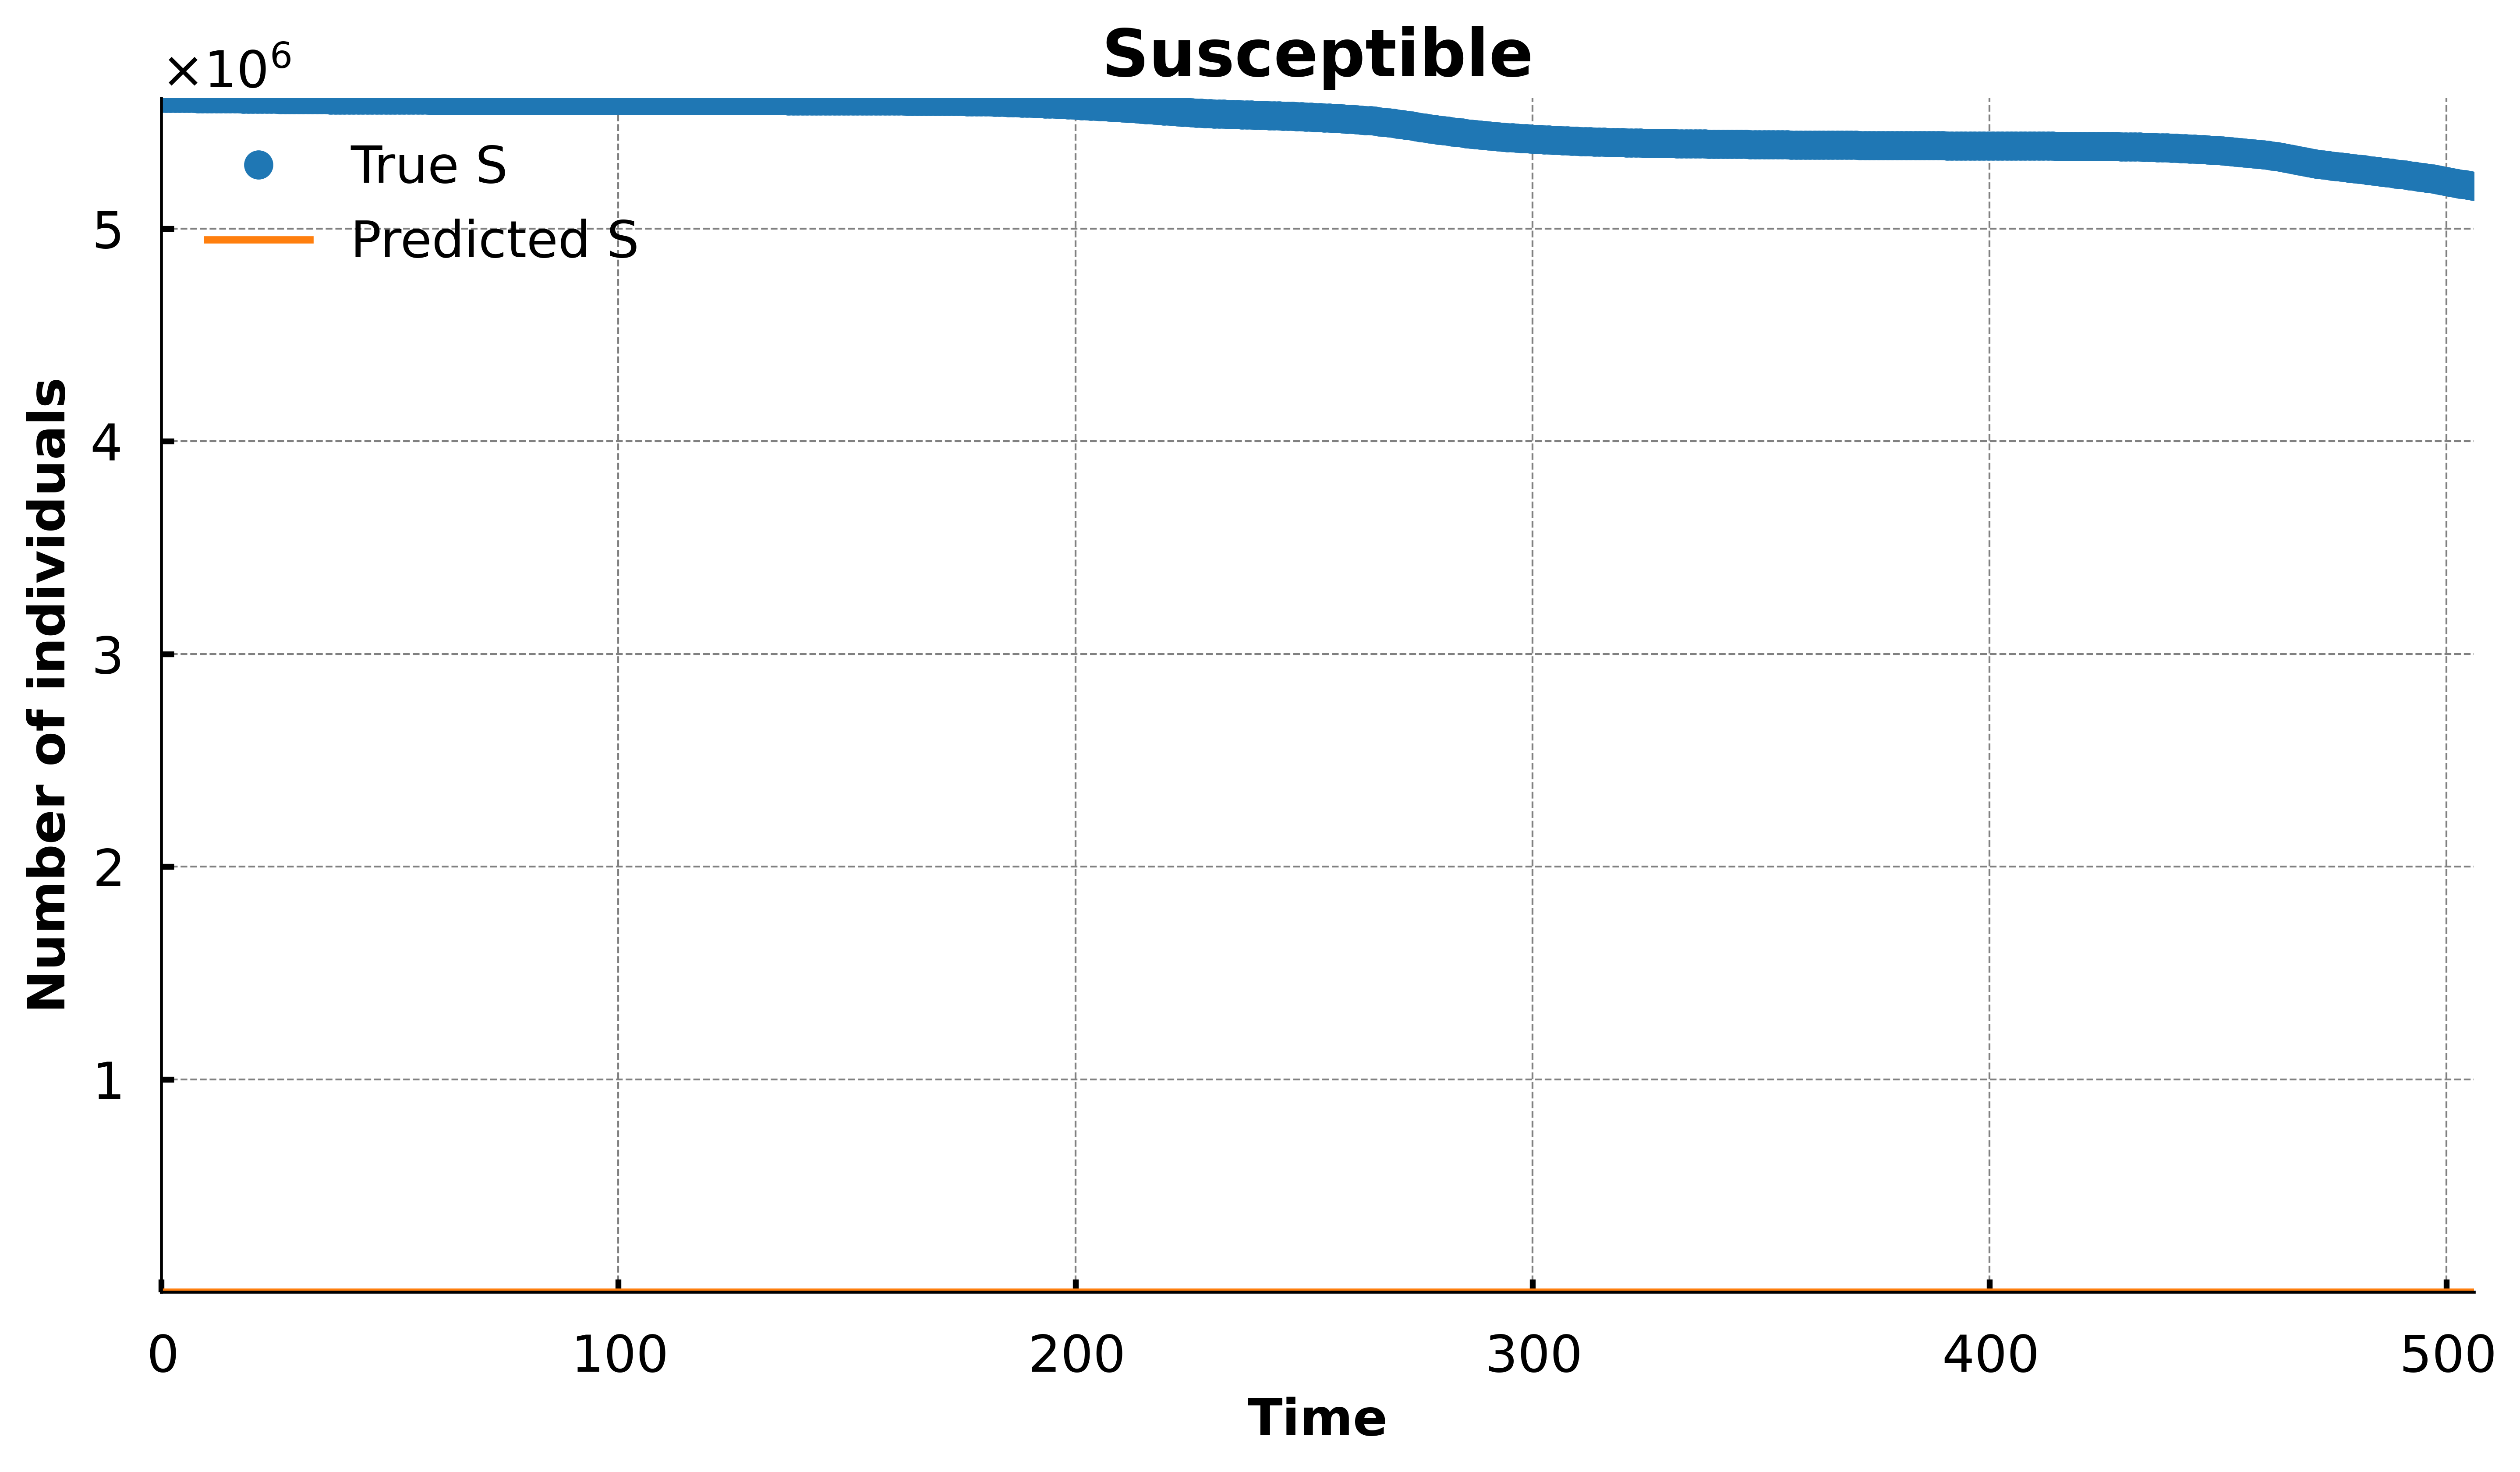

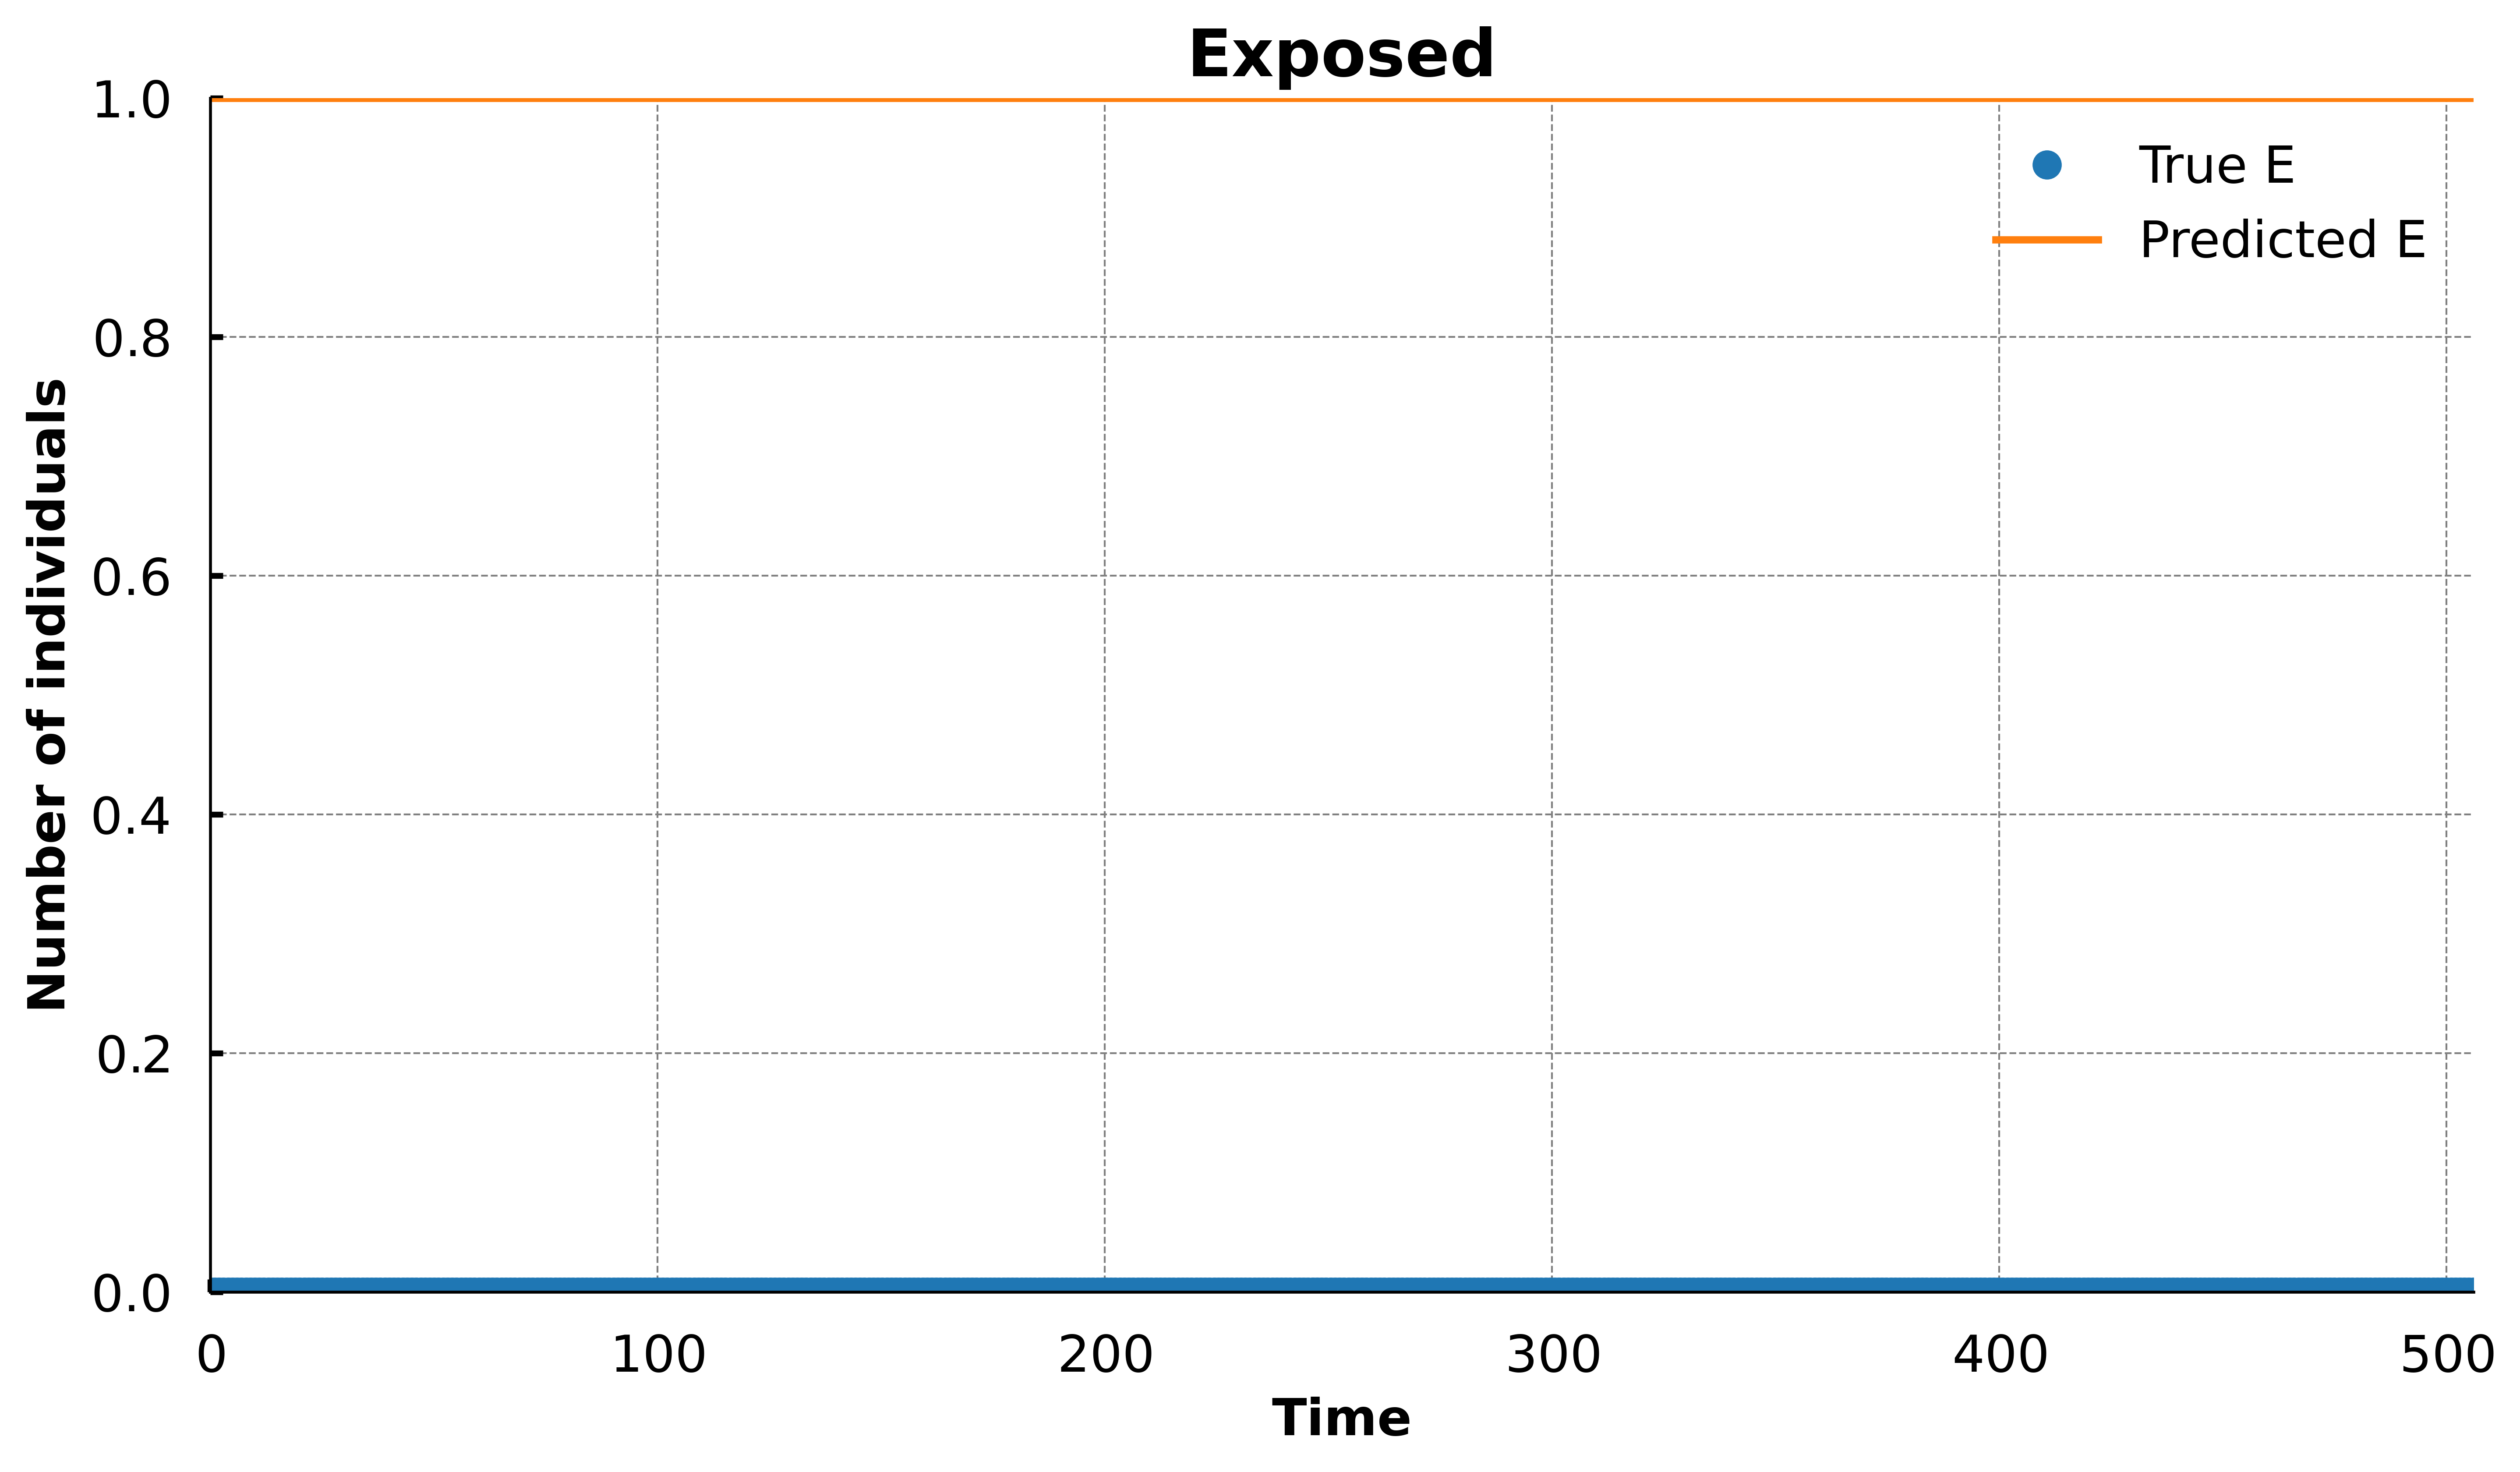

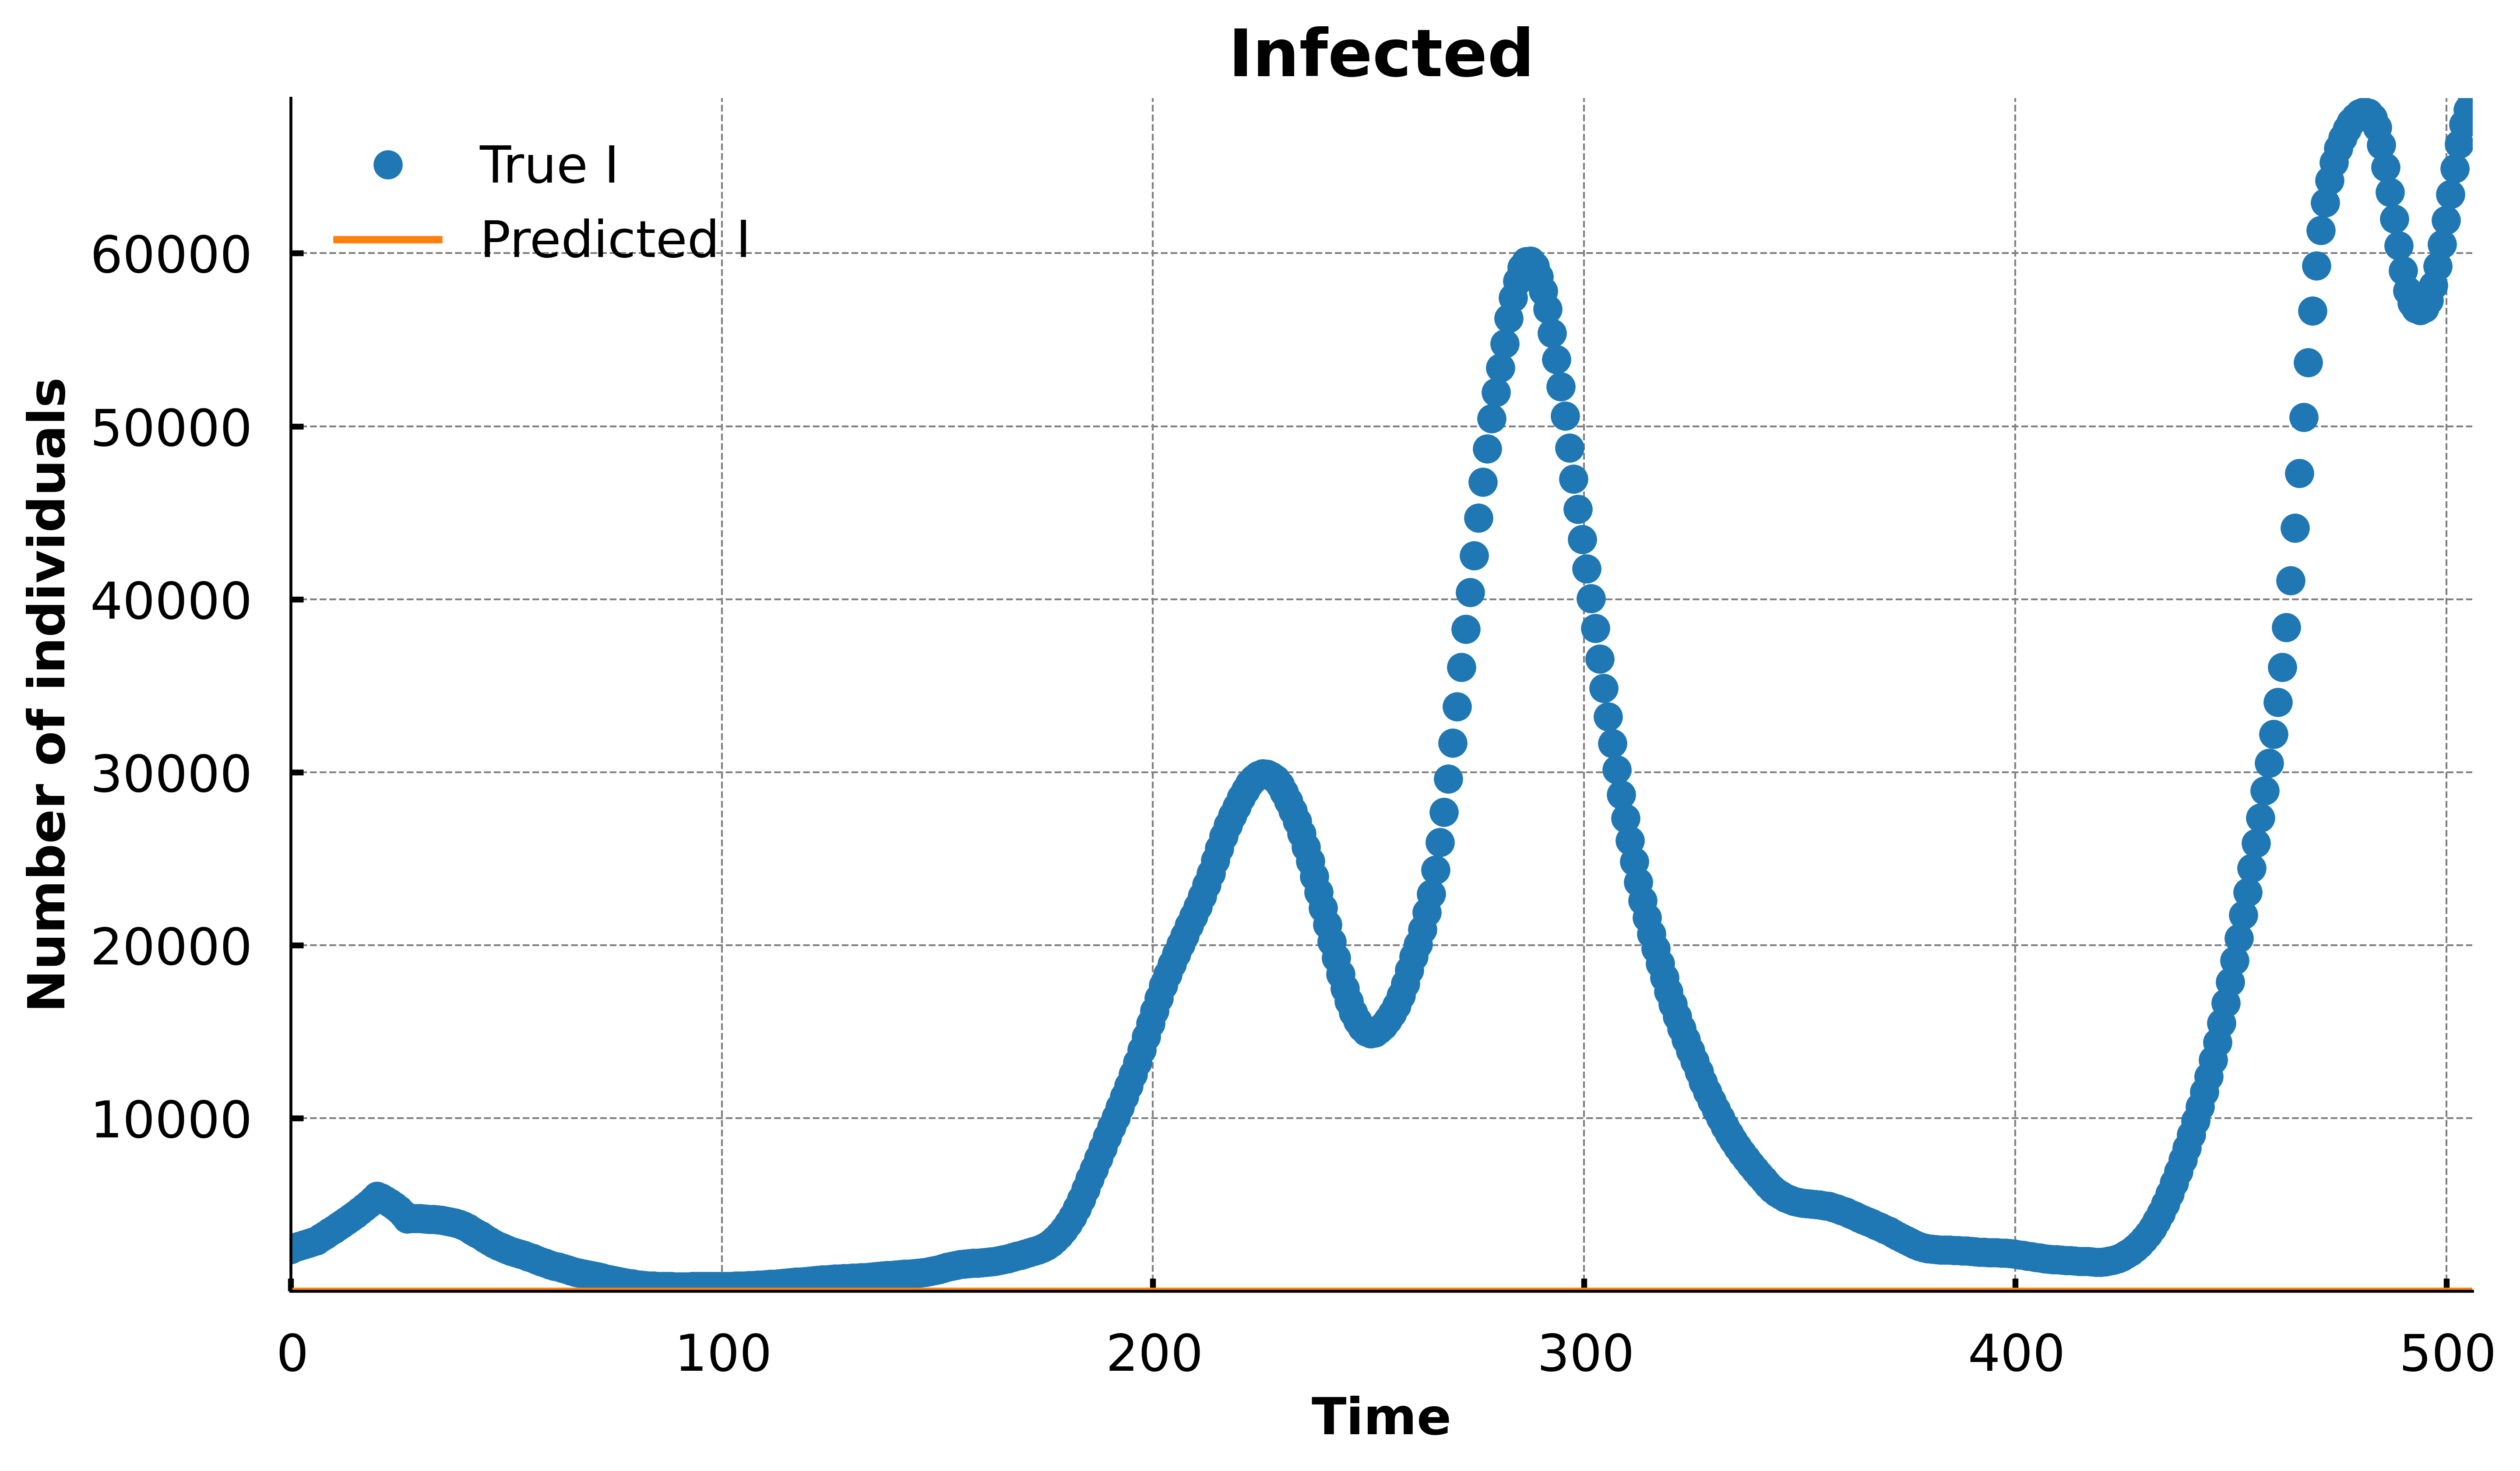

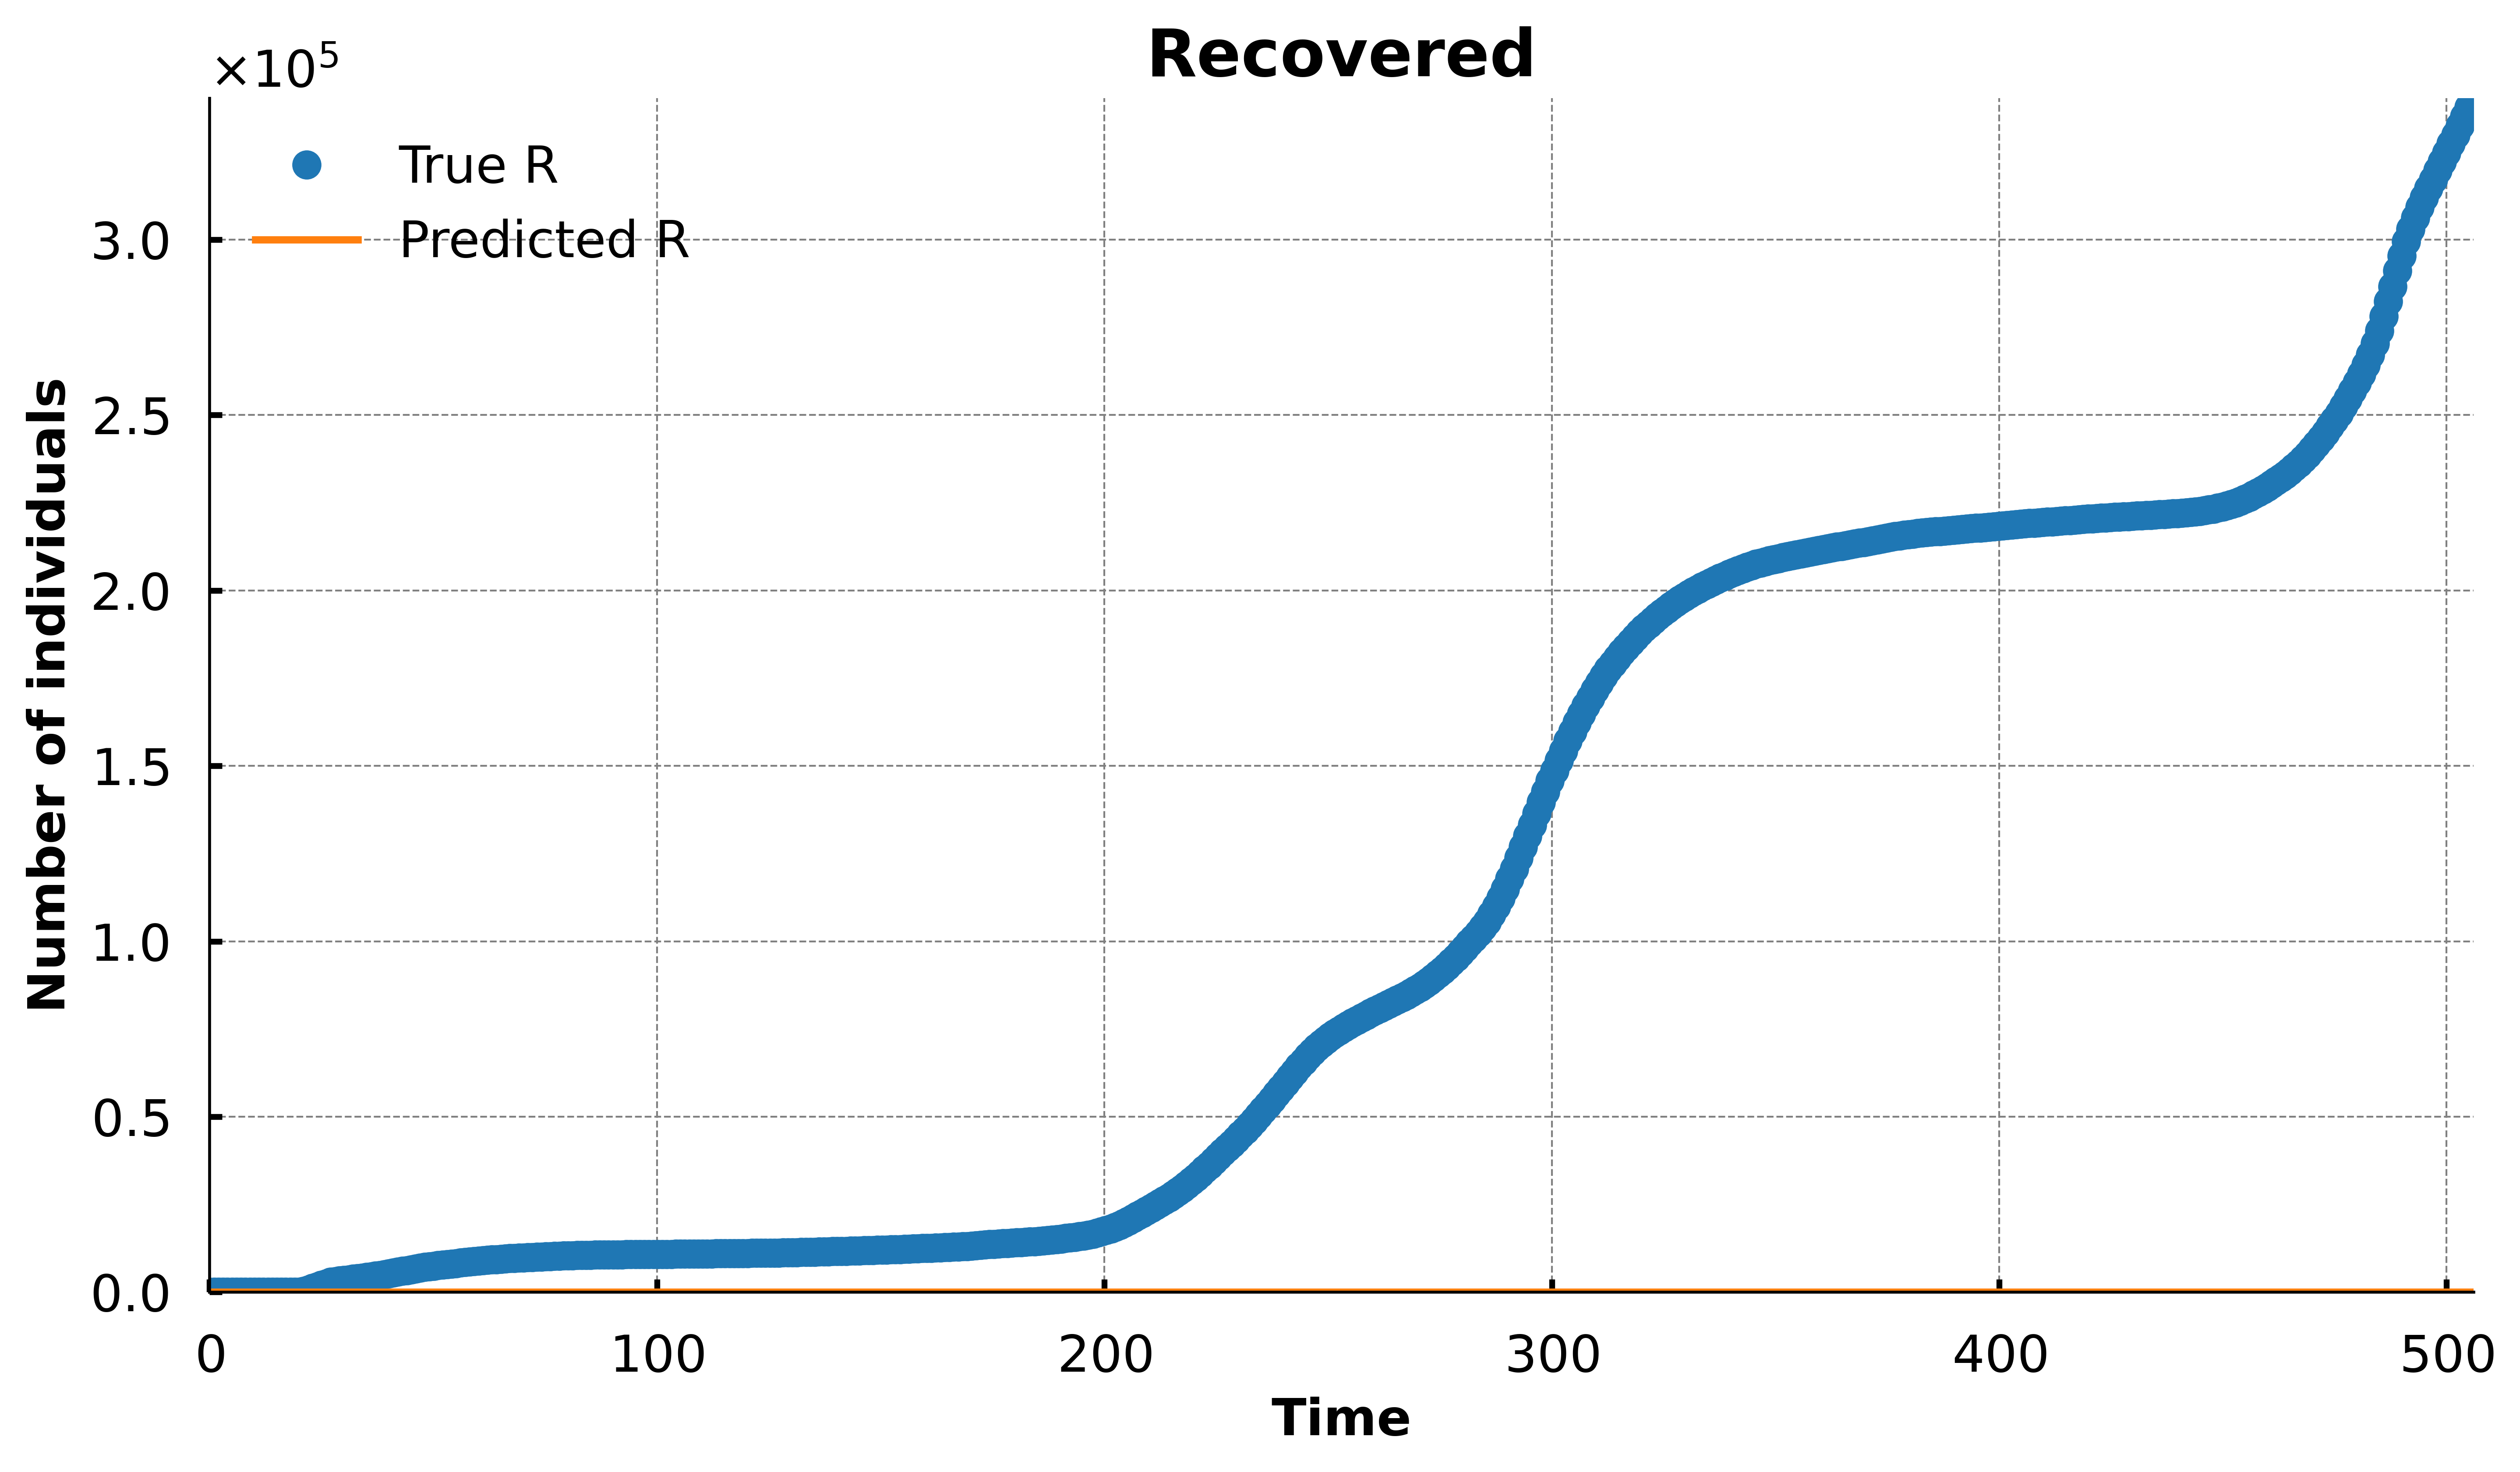

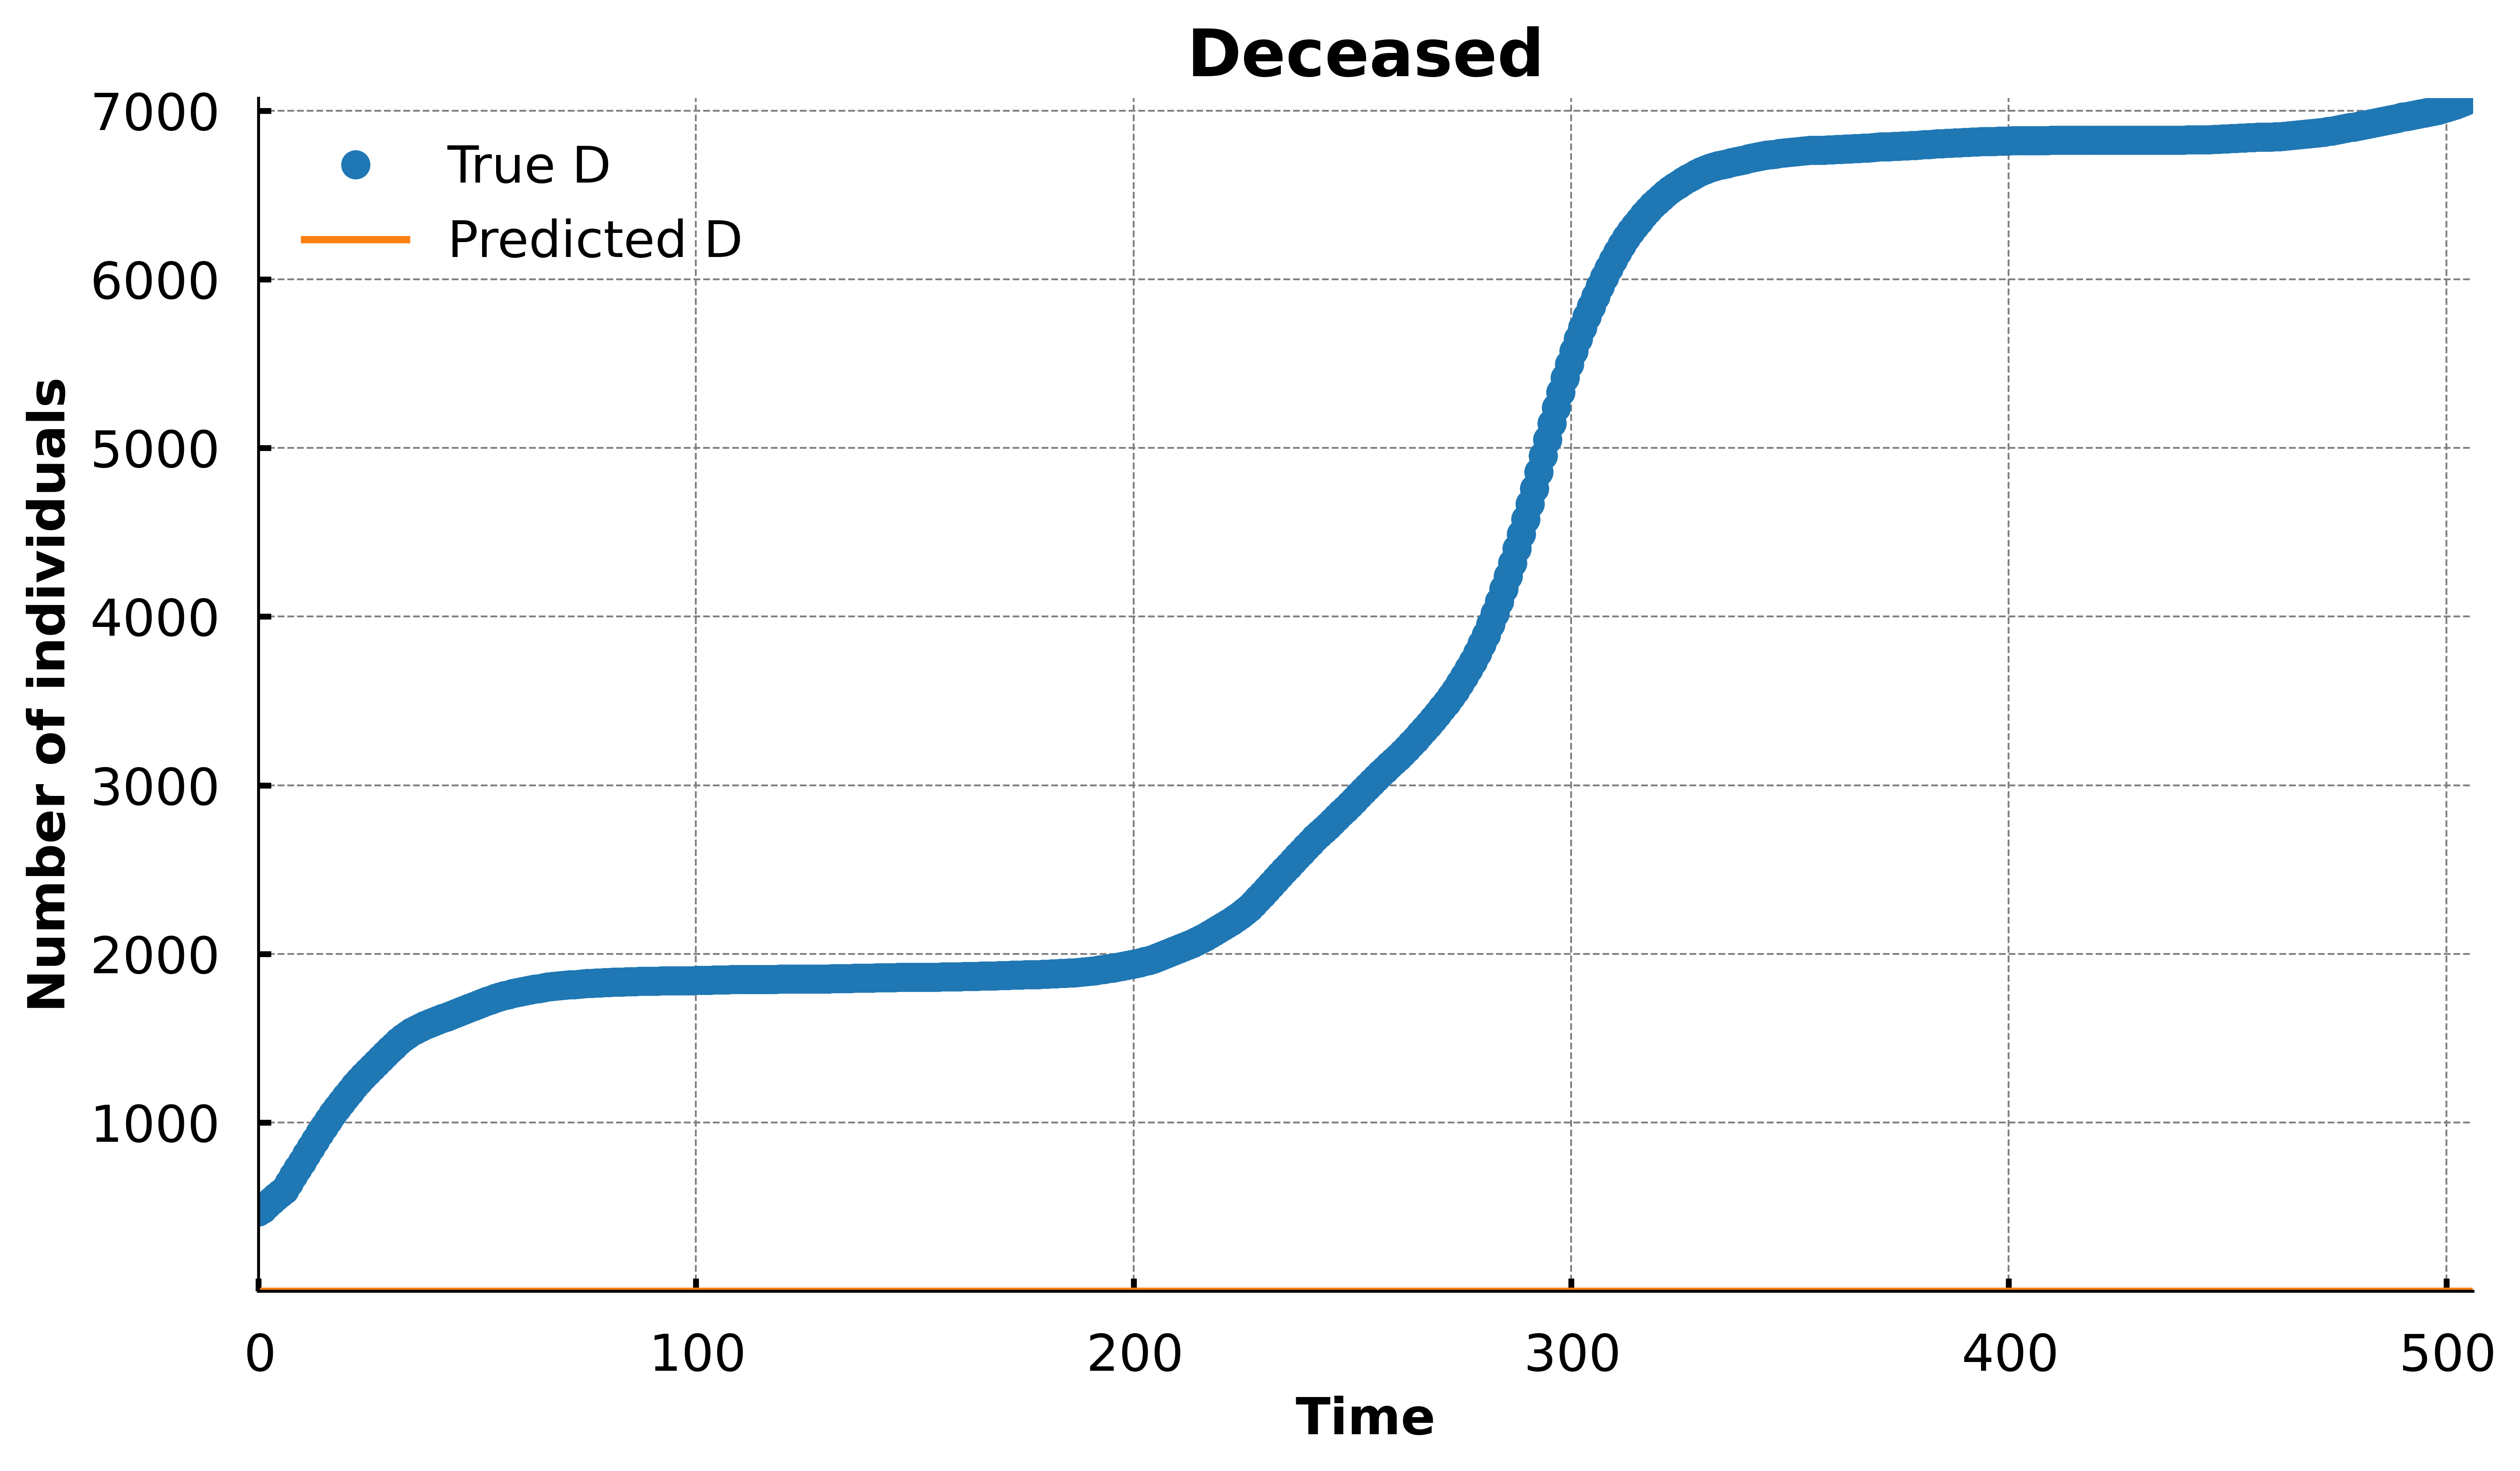

In [11]:
import matplotlib.pyplot as plt

def plot_results(t, true_values, predicted_values, title, ylabel, legend_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(t, true_values, 'o', label=legend_labels[0])
    plt.plot(t, predicted_values, '-', label=legend_labels[1])
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate time points for plotting
t_points = np.linspace(0, len(train_scaled), len(train_scaled))

# Convert to tensor
t_tensor = torch.from_numpy(t_points.reshape(-1, 1)).float().to(device)

# Get predictions from the model
with torch.no_grad():
    predictions = pinn_seird(t_tensor).cpu().numpy()

# Rescale the predictions back to original scale
predicted_S = predictions[:, 0]
predicted_E = predictions[:, 1]
predicted_I = predictions[:, 2]
predicted_R = predictions[:, 3]
predicted_D = predictions[:, 4]

# Rescale the true values back to original scale
true_S = scaler.inverse_transform(train_scaled)[:, 0]
true_E = np.zeros_like(true_S)  # No true data for exposed
true_I = scaler.inverse_transform(train_scaled)[:, 1]
true_R = scaler.inverse_transform(train_scaled)[:, 2]
true_D = scaler.inverse_transform(train_scaled)[:, 3]

# Plot results
plot_results(t_points, true_S, predicted_S, 'Susceptible', 'Number of individuals', ['True S', 'Predicted S'])
plot_results(t_points, true_E, predicted_E, 'Exposed', 'Number of individuals', ['True E', 'Predicted E'])
plot_results(t_points, true_I, predicted_I, 'Infected', 'Number of individuals', ['True I', 'Predicted I'])
plot_results(t_points, true_R, predicted_R, 'Recovered', 'Number of individuals', ['True R', 'Predicted R'])
plot_results(t_points, true_D, predicted_D, 'Deceased', 'Number of individuals', ['True D', 'Predicted D'])
